# Import

In [1172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Functions

In [1173]:
from pandas.api.types import is_numeric_dtype

def describe_box_format(df, col):
    stats = df[col].describe()
    line1 = f"count {stats['count']:,.2f}"
    line2 = f"mean {stats['mean']:.2f}  std {stats['std']:.2f}"
    line3 = f"min {stats['min']:.2f}"
    line4 = f"25% {stats['25%']:.2f}  50% {stats['50%']:.2f}  75% {stats['75%']:.2f}"
    line5 = f"max {stats['max']:.2f}"
    
    print("="*36)
    print(line1)
    print(line2)
    print(line3)
    print(line4)
    print(line5)
    print("="*36)
    print()

def check(df, column):
    if is_numeric_dtype(df[column]):
        describe_box_format(df, column)
    na_count = df[column].isna().sum()
    na_ratio = round(na_count / len(df) * 100, 2)
    print('nan_num =', na_count)
    print('nan_ratio =', na_ratio, '%')
    print('unique =', df[column].unique())
    print('unique_num =', df[column].nunique())
    print('type =', df[column].dtype)

In [1174]:
raw_df = pd.read_csv('./data/lending_club_2020_train.csv')

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_62719/1801365359.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('./data/lending_club_2020_train.csv')


In [1175]:
len(raw_df), len(raw_df.columns)

(1755295, 141)

In [1176]:
# loan_status 정제
raw_df = raw_df[raw_df['loan_status'].isin(
    ['Fully Paid', 
     'Charged Off',
     'Does not meet the credit policy. Status:Fully Paid',
     'Does not meet the credit policy. Status:Charged Off',
     'Default']
)]

In [1177]:
label_map = {
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Default': 1
}
label_text_map = {
    0: '정상상환',
    1: '연체/부실'
}

raw_df['loan_status_bin'] = raw_df['loan_status'].map(label_map)
raw_df['loan_status_label'] = raw_df['loan_status_bin'].map(label_text_map)

In [1178]:
df = raw_df.copy()

# application_type == 'Joint App' 제거

In [1179]:
df['application_type'].unique()

array(['Joint App', 'Individual'], dtype=object)

In [1180]:
df = df[df['application_type'] == 'Individual']

In [1181]:
df.shape

(1076173, 143)

In [1182]:
sec_app_cols = [col for col in df.columns if 'sec' in col]

In [1183]:
df = df[df.columns.difference(sec_app_cols)]

In [1184]:
joint_cols = [col for col in df.columns if 'joint' in col]

In [1185]:
df = df[df.columns.difference(joint_cols)]

In [1186]:
hardship_cols = [col for col in df.columns if 'hardship' in col]

In [1187]:
df = df[df.columns.difference(hardship_cols)]

In [1188]:
settle_cols = [col for col in df.columns if 'settle' in col]

In [1189]:
df = df[df.columns.difference(settle_cols)]

In [1190]:
remove_col = ['orig_projected_additional_accrued_interest', 
              'initial_list_status',
              'last_fico_range_high', 
              'last_fico_range_low', 'last_pymnt_amnt',
              'last_pymnt_d', 'next_pymnt_d',
              'out_prncp', 'out_prncp_inv', 'policy_code', 'pymnt_plan',
              'url', 'recoveries', 'delinq_amnt', 'funded_amnt', 'total_pymnt_inv',
              'funded_amnt_inv', 'total_rec_prncp',
              'num_sats', # open_acc 와 상관관계 0.9 이상
              'num_rev_tl_bal_gt_0', # num_actv_rev_tl 상관관계 0.9 이상
              'total_bal_il',  # total_bal_ex_mort
              'avg_cur_bal', # tot_cur_bal
              'tot_cur_bal', 
              'total_il_high_credit_limit', #total_bal_ex_mort
              'percent_bc_gt_75', # bc_util
              'open_rv_24m', # acc_open_past_24mths
              'total_bc_limit', # bc_open_to_by
              'open_rv_12m', # num_tl_op_past_12m
              'zip_code',
              'application_type', 'title',
              'emp_title', 'emp_length', 'collection_recovery_fee',
              'deferral_term', 'payment_plan_start_date',
               'total_rec_int', 'total_rec_late_fee',
              ]

In [1191]:
df = df[df.columns.difference(remove_col)]

In [1192]:
categorical_cols = []
preprocess_df = df[['id']].copy()

# 상관계수 확인

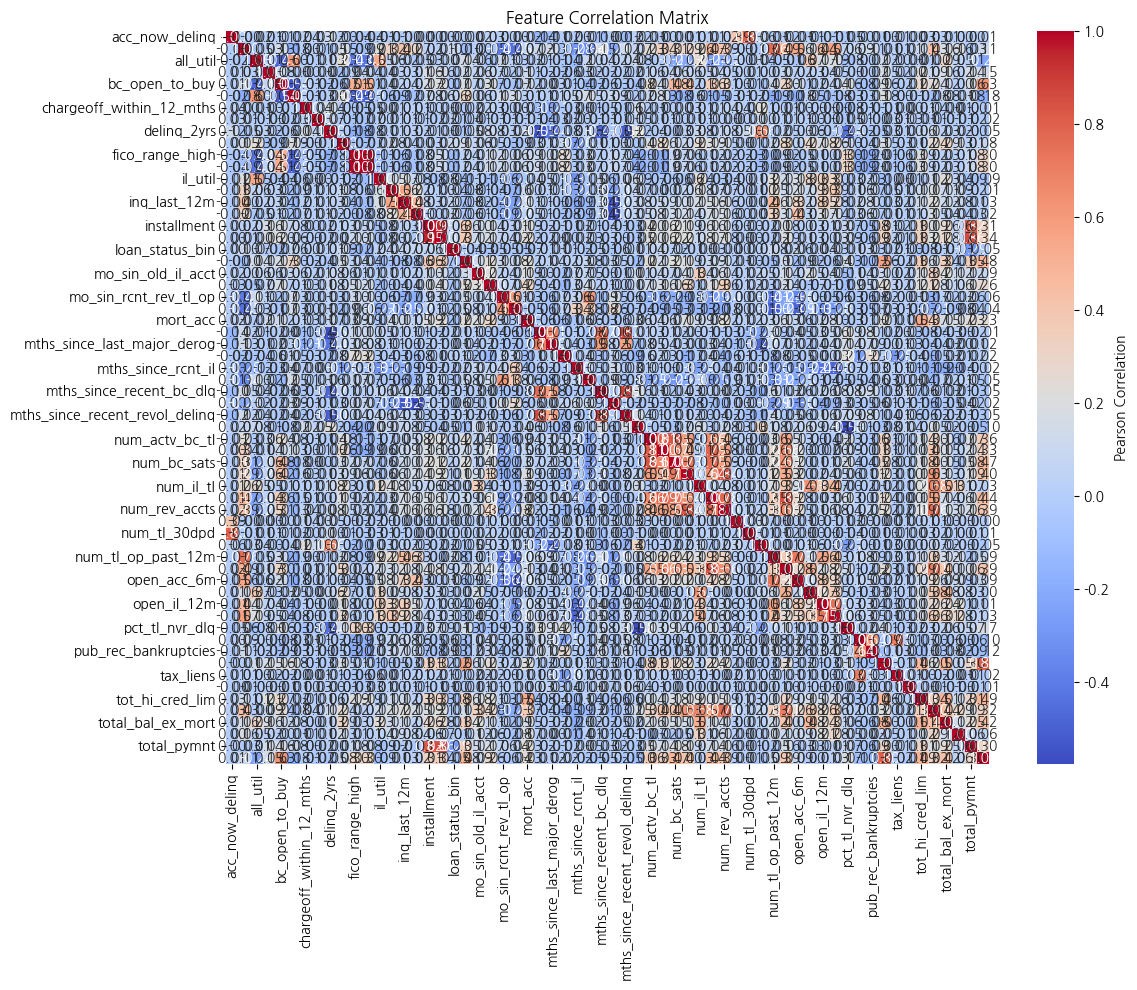

                        feature_1                       feature_2      corr
631               fico_range_high                  fico_range_low  1.000000
1009                  installment                       loan_amnt  0.952092
1892     mths_since_recent_bc_dlq  mths_since_recent_revol_delinq  0.889735
1582       mths_since_last_delinq  mths_since_recent_revol_delinq  0.866187
1114                    loan_amnt                     total_pymnt  0.863623
2517                num_rev_accts                       num_bc_tl  0.839125
2829                     open_acc                   num_op_rev_tl  0.834713
2144               num_actv_bc_tl                     num_bc_sats  0.829199
3736                  total_pymnt                     installment  0.820415
2143               num_actv_bc_tl                 num_actv_rev_tl  0.814796
3347                    revol_bal                total_rev_hi_lim  0.804623
42                 acc_now_delinq                    num_tl_30dpd  0.798020
2209        

In [1193]:
# 1) 상관계수 매트릭스 계산
corr_matrix = df.corr(numeric_only=True)

# 2) 상관계수 히트맵 시각화
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar_kws={'label': 'Pearson Correlation'}
)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 3) 절댓값 기준으로 상위 n 쌍만 추출하기 (예: |corr| > 0.7)
high_corr = (
    corr_matrix.abs()
    .unstack()
    .reset_index()
    .query("level_0 != level_1 and  abs(0) < 1")
)
high_corr.columns = ['feature_1', 'feature_2', 'corr']
high_corr = high_corr[high_corr['corr'] > 0.7].sort_values('corr', ascending=False)
print(high_corr.drop_duplicates(subset=['corr']))  # 중복 제외하여 출력

# 결측치가 50% 이상인 컬럼 제거

In [1194]:
missing_ratios = df.isna().mean()

# 결측치 비율이 40%를 넘는 컬럼만 필터링
high_missing = missing_ratios[missing_ratios > 0.4]

# 컬럼명 리스트로 추출 및 출력
cols_over_50pct = high_missing.index.tolist()
print("결측치 비율 > 40%인 컬럼들:", cols_over_50pct)

결측치 비율 > 40%인 컬럼들: ['all_util', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'total_cu_tl']


In [1195]:
remove_col = ['all_util', 'il_util', 'inq_fi', 'inq_last_12m', 
              'max_bal_bc', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'total_cu_tl']
df = df[df.columns.difference(remove_col)]

In [1196]:
df.columns.values

array(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state',
       'annual_inc', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'delinq_2yrs', 'dti', 'earliest_cr_line', 'fico_range_high',
       'fico_range_low', 'grade', 'home_ownership', 'id',
       'inq_last_6mths', 'installment', 'int_rate', 'issue_d',
       'last_credit_pull_d', 'loan_amnt', 'loan_status',
       'loan_status_bin', 'loan_status_label', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_tl_120dpd_2m',

# mort_acc

In [1197]:
check(df, 'mort_acc')

count 1,046,189.00
mean 1.60  std 1.95
min 0.00
25% 0.00  50% 1.00  75% 3.00
max 51.00

nan_num = 29984
nan_ratio = 2.79 %
unique = [ 2.  3.  1.  0.  4.  5.  6. nan  7.  9. 10. 12. 16.  8. 17. 11. 14. 13.
 19. 27. 15. 18. 21. 20. 23. 22. 47. 31. 24. 25. 32. 37. 35. 34. 36. 51.
 29. 28. 26. 33. 45.]
unique_num = 40
type = float64


In [1198]:
df['mort_acc'] = df['mort_acc'].fillna(0)

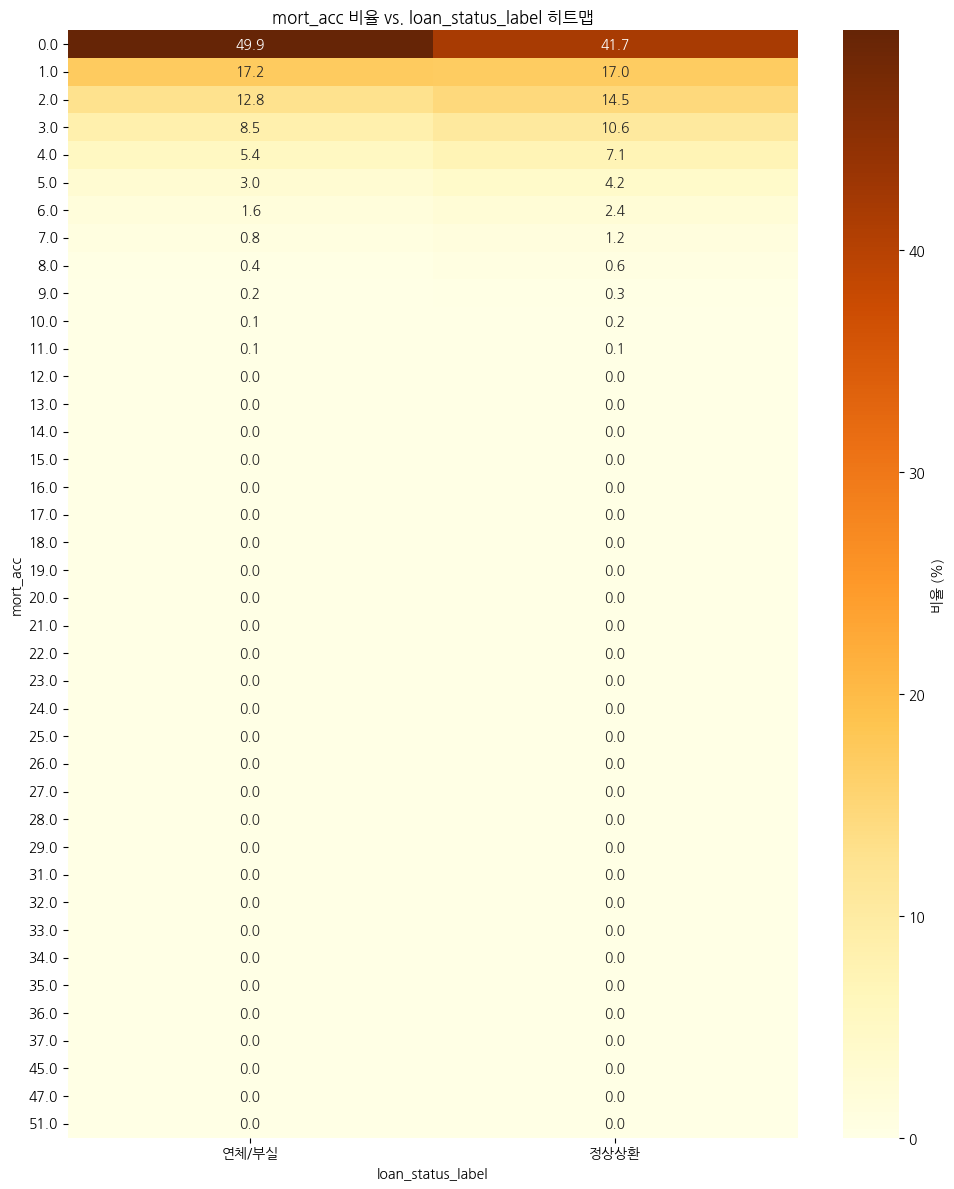

In [1199]:
pivot_pct = pd.crosstab(
    df['mort_acc'],
    df['loan_status_label'],
    normalize='columns'   # 열별 비율
) * 100

# 2. y축(계좌개수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3. 히트맵 그리기 (비율 기반)
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlOrBr',
    annot=True,            # 셀에 비율 표기
    fmt='.1f',             # 소수점 한 자리
    cbar_kws={'label': '비율 (%)'}
)
plt.title('mort_acc 비율 vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mort_acc')
plt.tight_layout()
plt.show()

In [1200]:
df['mort_acc'] = df['mort_acc'].clip(upper=6)

# addr_state

In [1201]:
check(df, 'addr_state')

nan_num = 0
nan_ratio = 0.0 %
unique = ['OK' 'TX' 'FL' 'IL' 'NC' 'IN' 'CT' 'MN' 'CO' 'NJ' 'MO' 'NY' 'OH' 'WI'
 'CA' 'OR' 'DE' 'PA' 'HI' 'VA' 'NH' 'WA' 'AR' 'AL' 'NV' 'MD' 'MI' 'RI'
 'MT' 'AZ' 'LA' 'TN' 'MA' 'GA' 'SC' 'KY' 'UT' 'SD' 'NM' 'ND' 'MS' 'WV'
 'KS' 'VT' 'NE' 'ID' 'WY' 'DC' 'AK' 'ME' 'IA']
unique_num = 51
type = object


In [1202]:
categorical_cols.append('addr_state')

# acc_now_delinq

In [1203]:
check(df, 'acc_now_delinq')

count 1,076,157.00
mean 0.00  std 0.08
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 14.00

nan_num = 16
nan_ratio = 0.0 %
unique = [ 0.  1.  2.  3. nan  4.  6. 14.  5.]
unique_num = 8
type = float64


In [1204]:
df['acc_now_delinq'] = df['acc_now_delinq'].fillna(0)

# acc_open_past_24mths

In [1205]:
check(df, 'acc_open_past_24mths')

count 1,046,189.00
mean 4.66  std 3.20
min 0.00
25% 2.00  50% 4.00  75% 6.00
max 61.00

nan_num = 29984
nan_ratio = 2.79 %
unique = [ 8.  5.  3.  6.  9.  2.  7. 12.  1. 11. 15.  4. 10.  0. 24. 16. 17. 14.
 13. nan 37. 18. 21. 20. 23. 19. 25. 22. 27. 26. 42. 32. 33. 29. 28. 56.
 36. 30. 45. 46. 31. 49. 39. 34. 61. 38. 35. 43. 40. 48. 44. 54.]
unique_num = 51
type = float64


In [1206]:
df['acc_open_past_24mths'] = df['acc_open_past_24mths'].fillna(0)

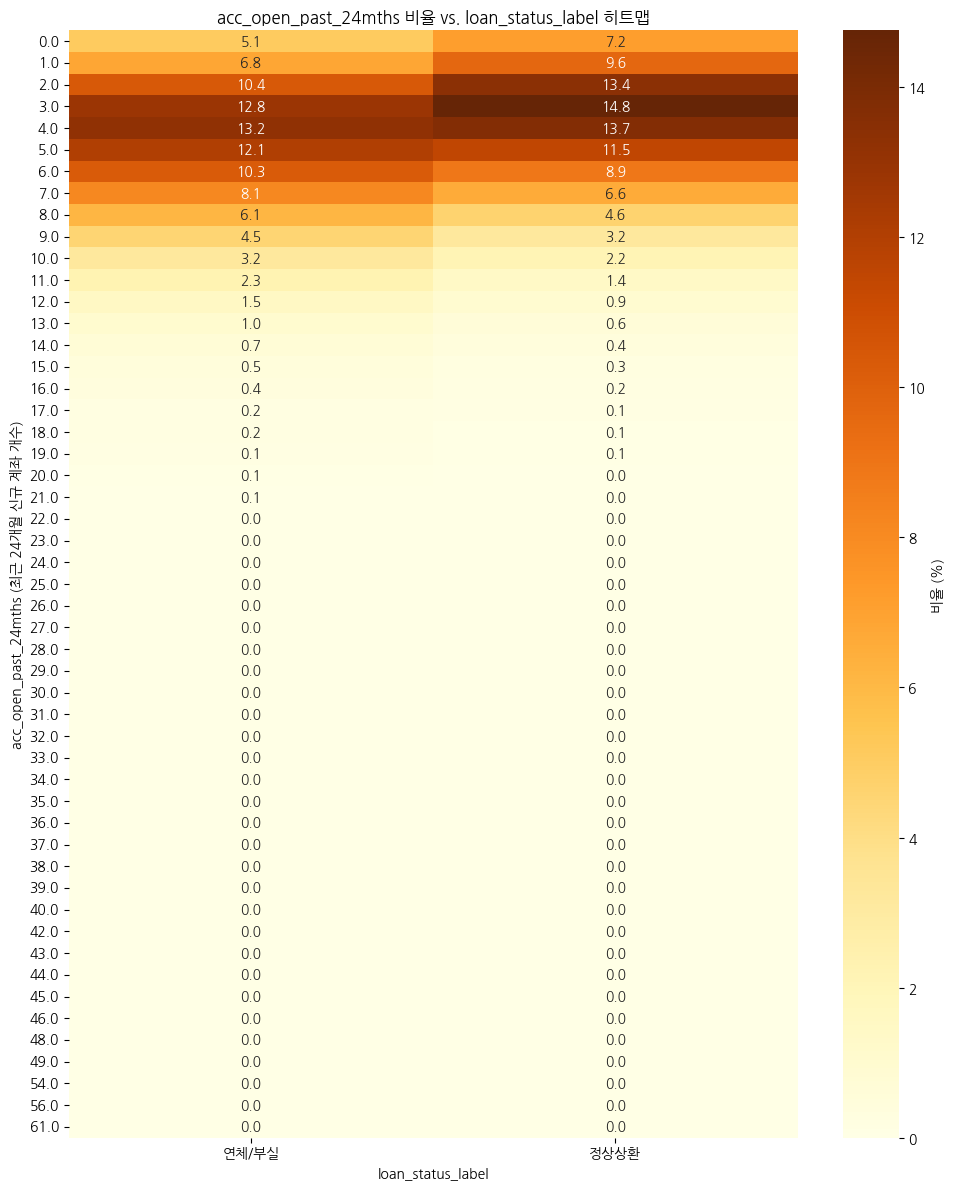

In [1207]:
# 1. acc_open_past_24mths별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['acc_open_past_24mths'],
    df['loan_status_label'],
    normalize='columns'   # 열별 비율
) * 100

# 2. y축(계좌개수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3. 히트맵 그리기 (비율 기반)
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlOrBr',
    annot=True,            # 셀에 비율 표기
    fmt='.1f',             # 소수점 한 자리
    cbar_kws={'label': '비율 (%)'}
)
plt.title('acc_open_past_24mths 비율 vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('acc_open_past_24mths (최근 24개월 신규 계좌 개수)')
plt.tight_layout()
plt.show()

In [1208]:
df['acc_open_past_24mths'] = df['acc_open_past_24mths'].clip(upper=10)

# annual_inc

In [1209]:
check(df, 'annual_inc')

count 1,076,171.00
mean 78065.91  std 141403.38
min 1896.00
25% 47000.00  50% 65000.00  75% 93000.00
max 110000000.00

nan_num = 2
nan_ratio = 0.0 %
unique = [110000.    65000.    50000.   ...  56611.19  30310.   181150.  ]
unique_num = 54673
type = float64


In [1210]:
df = df[df['annual_inc'].notna()]

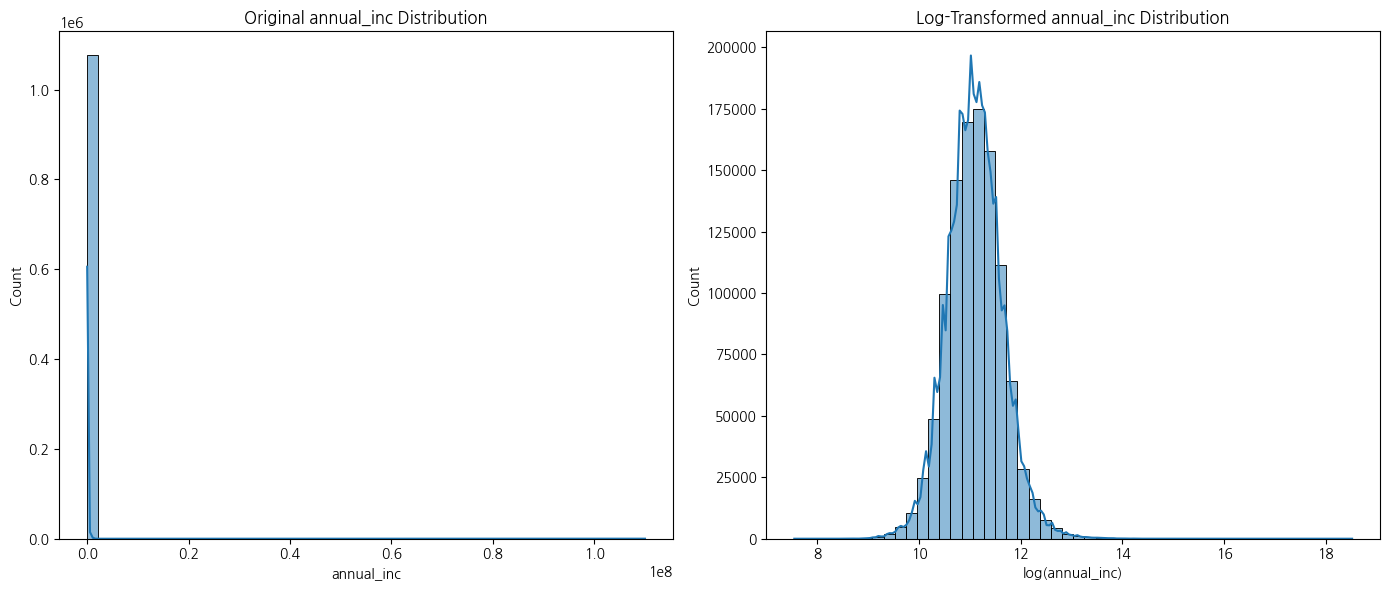

In [1211]:
temp = df.copy()
temp['annual_inc_log'] = np.log1p(temp['annual_inc'])  
df['annual_inc'] = np.log1p(df['annual_inc'])  

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['annual_inc'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Original annual_inc Distribution')
axes[0].set_xlabel('annual_inc')

# 로그 변환 후 분포
sns.histplot(temp['annual_inc_log'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed annual_inc Distribution')
axes[1].set_xlabel('log(annual_inc)')

plt.tight_layout()
plt.show()

# open_acc

In [1212]:
check(df, 'open_acc')

count 1,076,157.00
mean 11.62  std 5.57
min 0.00
25% 8.00  50% 11.00  75% 14.00
max 90.00

nan_num = 14
nan_ratio = 0.0 %
unique = [24. 18.  7. 19. 10. 20. 12.  9. 11.  6. 16. 15. 14. 23. 22. 26.  5.  8.
 30. 21.  4. 37. 29. 17. 13.  3. 28. 35. 34. 25.  1. 33. 31.  2. 32. 27.
 40. 39.  0. 36. 50. 38. 52. 46. 82. 43. 42. 47. 41. 55. 44. 45. 48. nan
 51. 68. 60. 53. 49. 58. 86. 56. 63. 65. 75. 90. 57. 59. 76. 54. 67. 80.
 74. 61. 69. 81. 64. 66. 62. 88. 78. 72.]
unique_num = 81
type = float64


In [1213]:
df[df['open_acc'].isna()]['loan_status_label'].value_counts()

loan_status_label
정상상환     13
연체/부실     1
Name: count, dtype: int64

In [1214]:
df['open_acc'] = df['open_acc'].fillna(0)

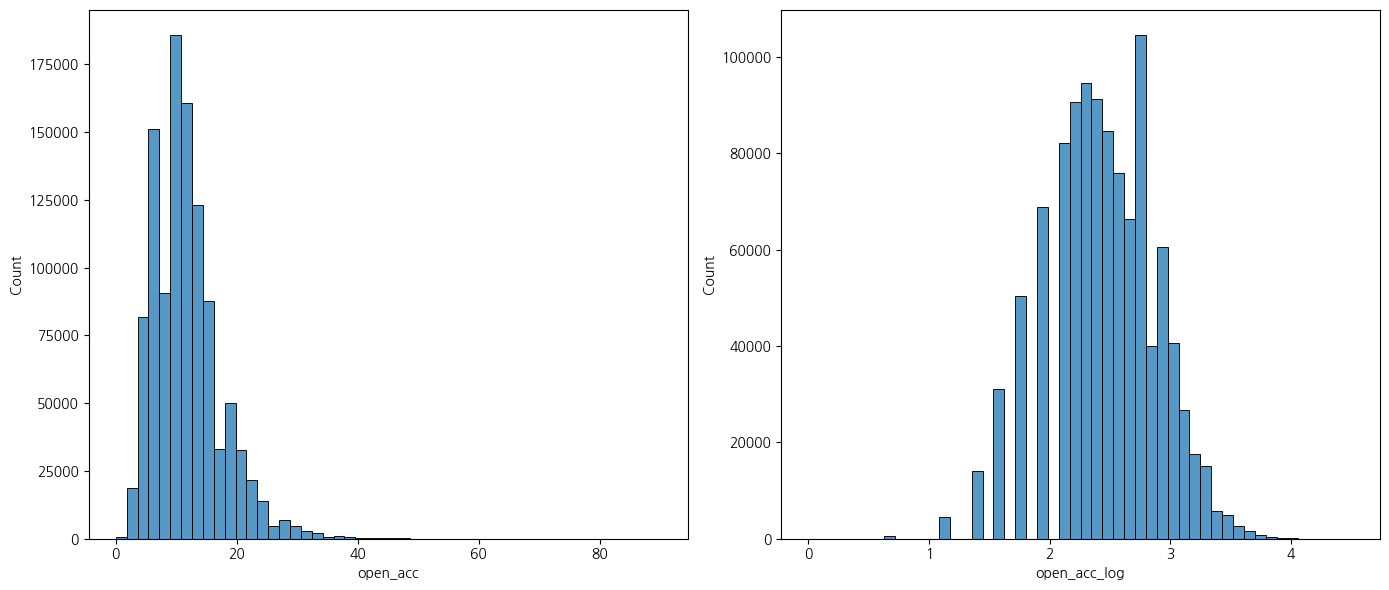

In [1215]:
df['open_acc_log'] = np.log1p(df['open_acc'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(df['open_acc'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(df['open_acc_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1216]:
df['open_acc'] = np.log1p(1 + df['open_acc'])  

# tax_liens

In [1217]:
check(df, "tax_liens")

count 1,076,101.00
mean 0.05  std 0.40
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 85.00

nan_num = 70
nan_ratio = 0.01 %
unique = [ 0.  1.  2. 10. nan  4.  3.  5.  6.  7.  8. 28. 14. 11. 21. 13. 27.  9.
 12. 15. 39. 45. 16. 18. 17. 37. 61. 24. 20. 63. 30. 53. 22. 23. 44. 85.]
unique_num = 35
type = float64


/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_62719/2747330157.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='loan_status_label', y='tax_flag', data=rate, palette='pastel')


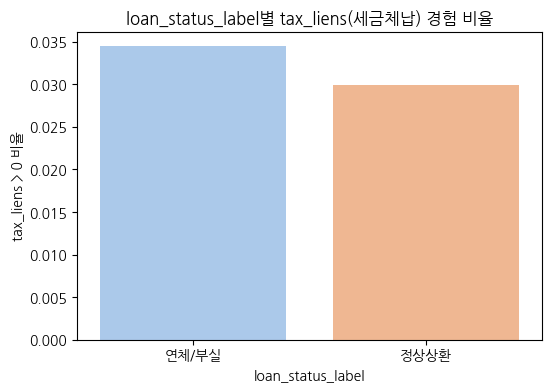

In [1218]:
df['tax_flag'] = (df['tax_liens'] > 0).astype(int)
rate = df.groupby('loan_status_label')['tax_flag'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='loan_status_label', y='tax_flag', data=rate, palette='pastel')
plt.ylabel('tax_liens > 0 비율')
plt.title('loan_status_label별 tax_liens(세금체납) 경험 비율')
plt.show()

In [1219]:
df['tax_liens'].value_counts(normalize=True)

tax_liens
0.0     9.692612e-01
1.0     2.070345e-02
2.0     5.803359e-03
3.0     2.149426e-03
4.0     9.683106e-04
5.0     4.767211e-04
6.0     2.787842e-04
7.0     1.226651e-04
8.0     6.597894e-05
9.0     5.668613e-05
10.0    2.787842e-05
11.0    2.230274e-05
12.0    9.292808e-06
13.0    7.434246e-06
15.0    6.504966e-06
14.0    5.575685e-06
17.0    5.575685e-06
16.0    4.646404e-06
18.0    3.717123e-06
27.0    2.787842e-06
21.0    1.858562e-06
61.0    1.858562e-06
24.0    1.858562e-06
20.0    1.858562e-06
30.0    9.292808e-07
44.0    9.292808e-07
23.0    9.292808e-07
22.0    9.292808e-07
53.0    9.292808e-07
37.0    9.292808e-07
63.0    9.292808e-07
45.0    9.292808e-07
39.0    9.292808e-07
28.0    9.292808e-07
85.0    9.292808e-07
Name: proportion, dtype: float64

In [1220]:
df[df['tax_liens'].isna()]['loan_status_label'].value_counts()

loan_status_label
정상상환     64
연체/부실     6
Name: count, dtype: int64

In [1221]:
df['tax_liens'] = df['tax_liens'].fillna(0)

In [1222]:
df['tax_liens'] = (df['tax_liens'] > 0).astype(int)

# revol_bal

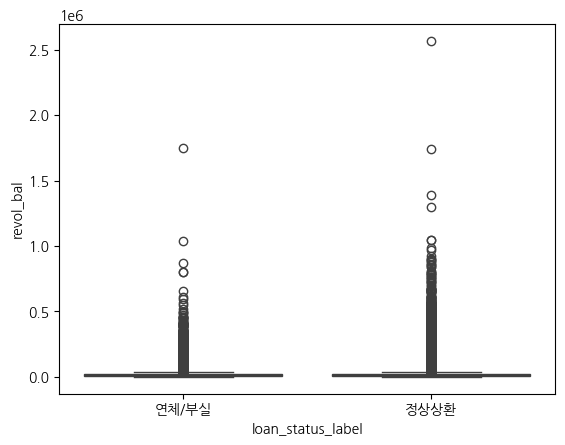

In [1223]:
sns.boxplot(df, x='loan_status_label', y='revol_bal')
plt.show()

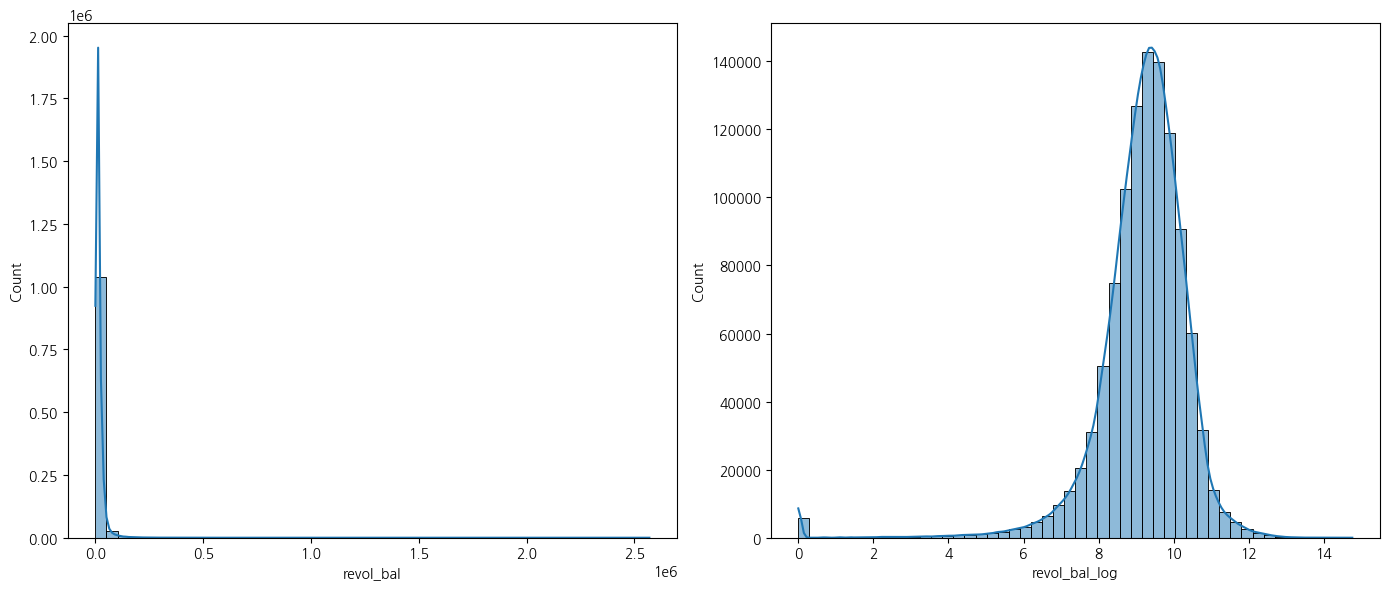

In [1224]:
df['revol_bal_log'] = np.log1p(df['revol_bal'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(df['revol_bal'], bins=50, kde=True, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(df['revol_bal_log'], bins=50, kde=True, ax=axes[1])

plt.tight_layout()
plt.show()

In [1225]:
check(df, "revol_bal")

count 1,076,171.00
mean 16284.87  std 22245.69
min 0.00
25% 5865.00  50% 11076.00  75% 19754.00
max 2568995.00

nan_num = 0
nan_ratio = 0.0 %
unique = [ 16909.   3881.   6824. ...  85895.  93707. 149626.]
unique_num = 79070
type = float64


In [1226]:
df['revol_bal'] = np.log1p(1 + df['revol_bal'])  

# pub_rec_bankruptcies

In [1227]:
check(df, "pub_rec_bankruptcies")

count 1,075,322.00
mean 0.13  std 0.37
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 12.00

nan_num = 849
nan_ratio = 0.08 %
unique = [ 0.  2.  1. nan  3.  4.  5.  7.  6.  8. 11. 12.  9.]
unique_num = 12
type = float64


In [1228]:
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

In [1229]:
df['pub_rec_bankruptcies'].value_counts(normalize=True)

pub_rec_bankruptcies
0.0     8.765410e-01
1.0     1.167314e-01
2.0     5.222218e-03
3.0     1.075108e-03
4.0     2.796953e-04
5.0     9.942658e-05
6.0     3.066427e-05
7.0     1.115064e-05
8.0     5.575322e-06
9.0     1.858441e-06
11.0    9.292204e-07
12.0    9.292204e-07
Name: proportion, dtype: float64

In [1230]:
df['pub_rec_bankruptcies'] = (df['pub_rec_bankruptcies'] > 0).astype(int)

# collections_12_mths_ex_med

In [1231]:
check(df, 'collections_12_mths_ex_med')

count 1,076,079.00
mean 0.02  std 0.15
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 20.00

nan_num = 92
nan_ratio = 0.01 %
unique = [ 0.  1. nan  2.  4.  3.  6.  8.  5. 12. 10.  7. 14. 20. 16.  9. 11.]
unique_num = 16
type = float64


/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_62719/3049142371.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='loan_status_label', y='collections_12_mths_ex_med_flag', data=rate, palette='pastel')


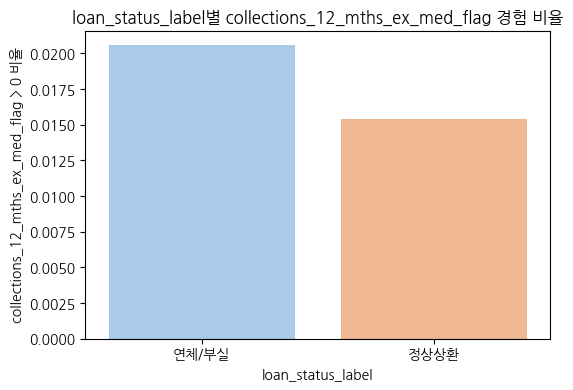

In [1232]:
df['collections_12_mths_ex_med_flag'] = (df['collections_12_mths_ex_med'] > 0).astype(int)
rate = df.groupby('loan_status_label')['collections_12_mths_ex_med_flag'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='loan_status_label', y='collections_12_mths_ex_med_flag', data=rate, palette='pastel')
plt.ylabel('collections_12_mths_ex_med_flag > 0 비율')
plt.title('loan_status_label별 collections_12_mths_ex_med_flag 경험 비율')
plt.show()

In [1233]:
df['collections_12_mths_ex_med'].value_counts(normalize=True)

collections_12_mths_ex_med
0.0     9.835802e-01
1.0     1.517268e-02
2.0     1.055685e-03
3.0     1.217383e-04
4.0     3.810129e-05
5.0     1.393950e-05
6.0     8.363698e-06
7.0     1.858600e-06
8.0     9.292998e-07
12.0    9.292998e-07
10.0    9.292998e-07
14.0    9.292998e-07
20.0    9.292998e-07
16.0    9.292998e-07
9.0     9.292998e-07
11.0    9.292998e-07
Name: proportion, dtype: float64

In [1234]:
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].fillna(0)

In [1235]:
df['collections_12_mths_ex_med'] = (df['collections_12_mths_ex_med'] > 0).astype(int)

# delinq_2yrs

In [1236]:
check(df, "delinq_2yrs")

count 1,076,157.00
mean 0.31  std 0.88
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 42.00

nan_num = 14
nan_ratio = 0.0 %
unique = [ 1.  0.  2.  4.  6. 16.  3.  7.  5. 12.  8. 15. 17. 11. 10.  9. 30. 14.
 nan 13. 21. 18. 36. 19. 20. 25. 42. 29. 27. 28. 24. 32. 26. 22.]
unique_num = 33
type = float64


In [1237]:
df['delinq_2yrs'].value_counts(normalize=True)

delinq_2yrs
0.0     8.096876e-01
1.0     1.265977e-01
2.0     3.671304e-02
3.0     1.347201e-02
4.0     6.075322e-03
5.0     3.057175e-03
6.0     1.730231e-03
7.0     9.719771e-04
8.0     5.696195e-04
9.0     3.624007e-04
10.0    2.490343e-04
11.0    1.403141e-04
12.0    1.254464e-04
13.0    7.062167e-05
14.0    5.854164e-05
15.0    3.252314e-05
16.0    2.230158e-05
17.0    1.486772e-05
18.0    1.486772e-05
19.0    9.292324e-06
20.0    8.363092e-06
21.0    4.646162e-06
25.0    1.858465e-06
22.0    1.858465e-06
36.0    9.292324e-07
42.0    9.292324e-07
29.0    9.292324e-07
27.0    9.292324e-07
28.0    9.292324e-07
24.0    9.292324e-07
32.0    9.292324e-07
26.0    9.292324e-07
30.0    9.292324e-07
Name: proportion, dtype: float64

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_62719/1306091405.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='loan_status_label', y='delinq_2yrs_flag', data=rate, palette='pastel')


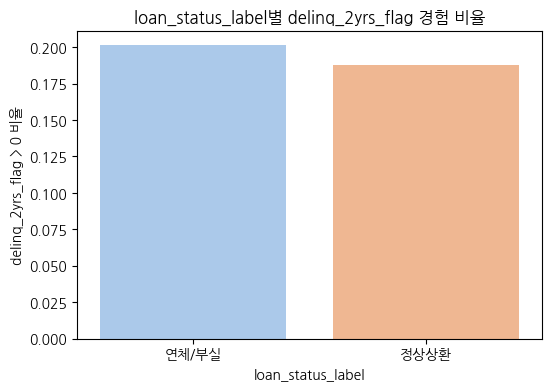

In [1238]:
df['delinq_2yrs_flag'] = (df['delinq_2yrs'] > 0).astype(int)
rate = df.groupby('loan_status_label')['delinq_2yrs_flag'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='loan_status_label', y='delinq_2yrs_flag', data=rate, palette='pastel')
plt.ylabel('delinq_2yrs_flag > 0 비율')
plt.title('loan_status_label별 delinq_2yrs_flag 경험 비율')
plt.show()

In [1239]:
df['delinq_2yrs'] = (df['delinq_2yrs'] > 0).astype(int)

# pub_rec

In [1240]:
check(df, "pub_rec")

count 1,076,157.00
mean 0.21  std 0.60
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 86.00

nan_num = 14
nan_ratio = 0.0 %
unique = [ 0.  2.  1. 10.  4.  5.  3.  9.  6.  7.  8. 28. 14. 11. 21. nan 13. 12.
 19. 16. 40. 46. 17. 18. 37. 61. 25. 20. 15. 24. 63. 31. 54. 22. 44. 86.]
unique_num = 35
type = float64


In [1241]:
df['pub_rec'].value_counts(normalize=True)

pub_rec
0.0     8.342825e-01
1.0     1.399471e-01
2.0     1.676893e-02
3.0     5.190692e-03
4.0     1.895634e-03
5.0     9.143647e-04
6.0     4.516070e-04
7.0     2.146527e-04
8.0     1.105787e-04
9.0     7.248013e-05
10.0    4.367392e-05
11.0    2.973544e-05
12.0    1.672618e-05
13.0    1.115079e-05
15.0    7.433860e-06
16.0    5.575395e-06
14.0    4.646162e-06
18.0    4.646162e-06
17.0    3.716930e-06
28.0    3.716930e-06
21.0    3.716930e-06
19.0    2.787697e-06
61.0    1.858465e-06
24.0    1.858465e-06
46.0    9.292324e-07
37.0    9.292324e-07
25.0    9.292324e-07
20.0    9.292324e-07
40.0    9.292324e-07
63.0    9.292324e-07
31.0    9.292324e-07
54.0    9.292324e-07
22.0    9.292324e-07
44.0    9.292324e-07
86.0    9.292324e-07
Name: proportion, dtype: float64

In [1242]:
df['pub_rec'] = (df['pub_rec'] > 0).astype(int)

# revol_util

In [1243]:
df['revol_util'] = df['revol_util'].str.rstrip('%').astype(float)

In [1244]:
check(df, "revol_util")

count 1,075,399.00
mean 50.61  std 24.73
min 0.00
25% 31.80  50% 50.70  75% 69.70
max 366.60

nan_num = 772
nan_ratio = 0.07 %
unique = [ 55.9    5.5   49.4  ...  29.77 119.1  118.3 ]
unique_num = 1312
type = float64


In [1245]:
df[df['revol_util'].isna()]['loan_status_label'].value_counts()

loan_status_label
정상상환     625
연체/부실    147
Name: count, dtype: int64

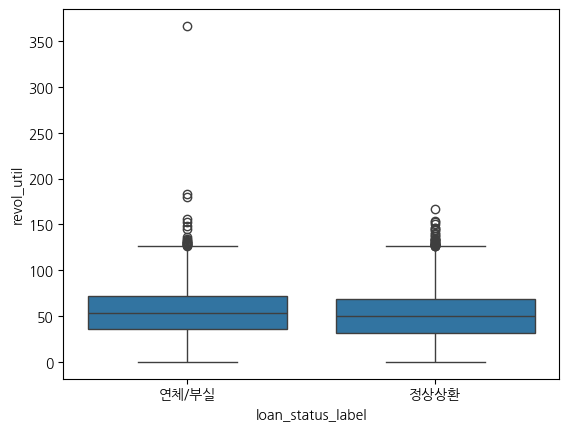

In [1246]:
sns.boxplot(df, x="loan_status_label", y="revol_util")
plt.show()

In [1247]:
df = df[df['revol_util'] < 350]

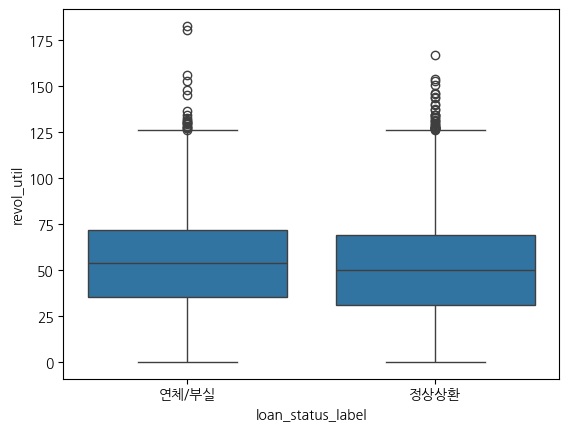

In [1248]:
sns.boxplot(df, x="loan_status_label", y="revol_util")
plt.show()

- revol_util 의 계산식 = raw_df['revol_bal'] / raw_df['total_rev_hi_lim'] * 100

In [1249]:
(raw_df['revol_bal'] / raw_df['total_rev_hi_lim']) * 100

0          13.981900
2          55.888283
5           5.536377
6          49.449275
7          60.021661
             ...    
1755288    67.765027
1755290    90.757009
1755291    41.380435
1755292    95.569444
1755293    11.885219
Length: 1117839, dtype: float64

In [1250]:
raw_df['revol_util']

0            14%
2          55.9%
5           5.5%
6          49.4%
7            60%
           ...  
1755288    67.8%
1755290    90.8%
1755291    41.4%
1755292    95.6%
1755293    11.9%
Name: revol_util, Length: 1117839, dtype: object

In [1251]:
# revol_util이 NaN인 경우, (revol_bal / total_rev_hi_lim) * 100 으로 채우기
mask = df['revol_util'].isna() & df['revol_bal'].notna() & df['total_rev_hi_lim'].notna() & (df['total_rev_hi_lim'] != 0)
df.loc[mask, 'revol_util'] = (df.loc[mask, 'revol_bal'] / df.loc[mask, 'total_rev_hi_lim']) * 100

In [1252]:
check(df, 'revol_util')

count 1,075,398.00
mean 50.61  std 24.73
min 0.00
25% 31.80  50% 50.70  75% 69.70
max 182.80

nan_num = 0
nan_ratio = 0.0 %
unique = [ 55.9    5.5   49.4  ...  29.77 119.1  118.3 ]
unique_num = 1311
type = float64


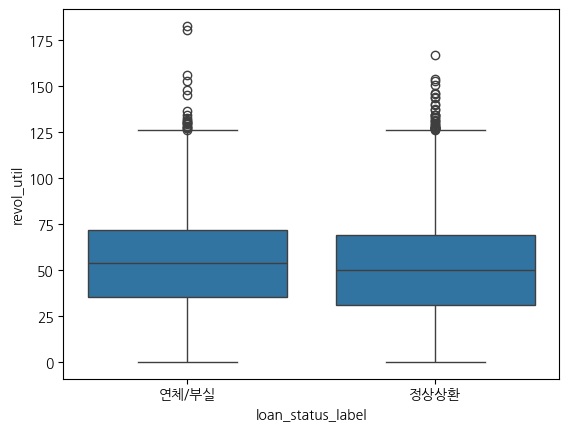

In [1253]:
sns.boxplot(df, x="loan_status_label", y="revol_util")
plt.show()

In [1254]:
temp = df[df['revol_util'] > 175]

In [1255]:
display((temp['revol_bal'] / temp['total_rev_hi_lim']) * 100)
display(temp['revol_util'])

484666    0.122635
955106    0.286533
dtype: float64

484666    182.8
955106    180.3
Name: revol_util, dtype: float64

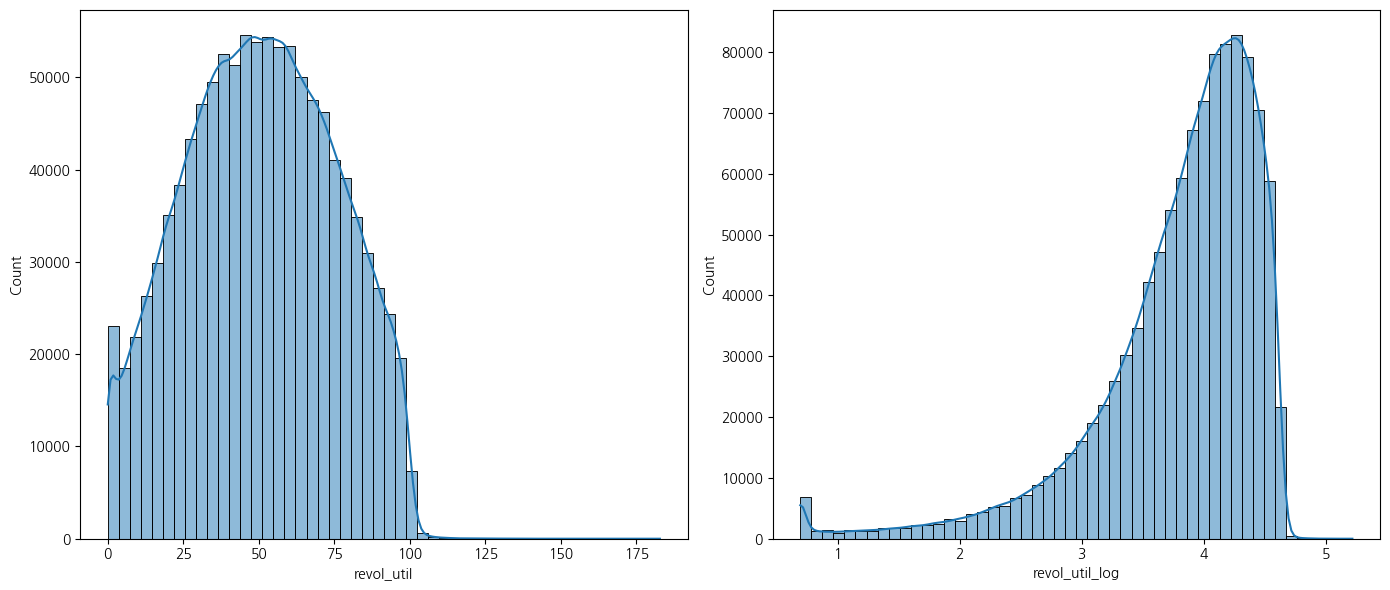

In [ ]:
temp = df.copy()
temp['revol_util_log'] = np.log1p(1 + temp['revol_util'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['revol_util'], bins=50, kde=True, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['revol_util_log'], bins=50, kde=True, ax=axes[1])

plt.tight_layout()
plt.show()

In [1257]:
df['revol_util'] = np.log1p(1 + df['revol_util'])  

# total_acc

In [1258]:
check(df, 'total_acc')

count 1,075,398.00
mean 24.65  std 12.05
min 1.00
25% 16.00  50% 23.00  75% 31.00
max 169.00

nan_num = 0
nan_ratio = 0.0 %
unique = [ 60.  28.   9.  40.  27.  24.  15.  19.  14.  17.  23.  34.  41.  30.
  22.  43.  46.  38.  11.  39.  54.  32.  26.  18.  16.  13.  10.  12.
  20.  47.  36.  62.  63.   6.  37.  61.  25.  21.  35.  33.  31.   7.
  56.  29.  50.   4.  57.   8.  44.  55.  45.  81.  42.  48.   2.  49.
  76.   3.  53.   5.  72.  51.  52.  59.  58.  71.  65. 100.  67.  66.
  77.  70.  87.  64.  69.  79.  73.  68.  80.  92.  84. 140.  75.  85.
 115.  88.  74.  78.  82.  94.  95.  83.  90.  91.  86. 144. 120. 101.
 105.  96. 118. 113.  89. 112.  99. 137.  93. 117.  98.  97. 102. 104.
   1. 114. 122. 126. 107. 108. 151. 119. 106. 111. 135. 130. 103. 109.
 121. 110. 116. 162. 169. 125. 123. 129. 146. 157. 145.]
unique_num = 137
type = float64


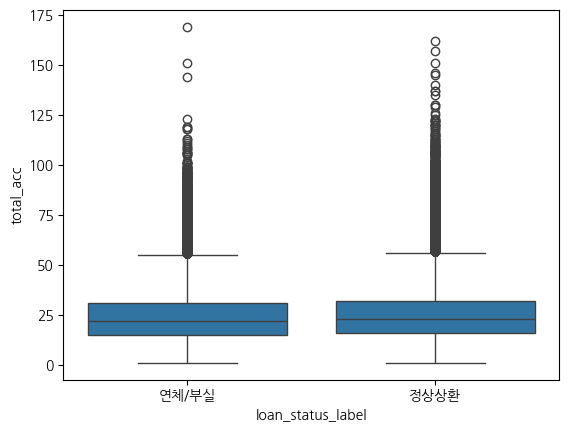

In [1259]:
sns.boxplot(df, x='loan_status_label', y='total_acc')
plt.show()

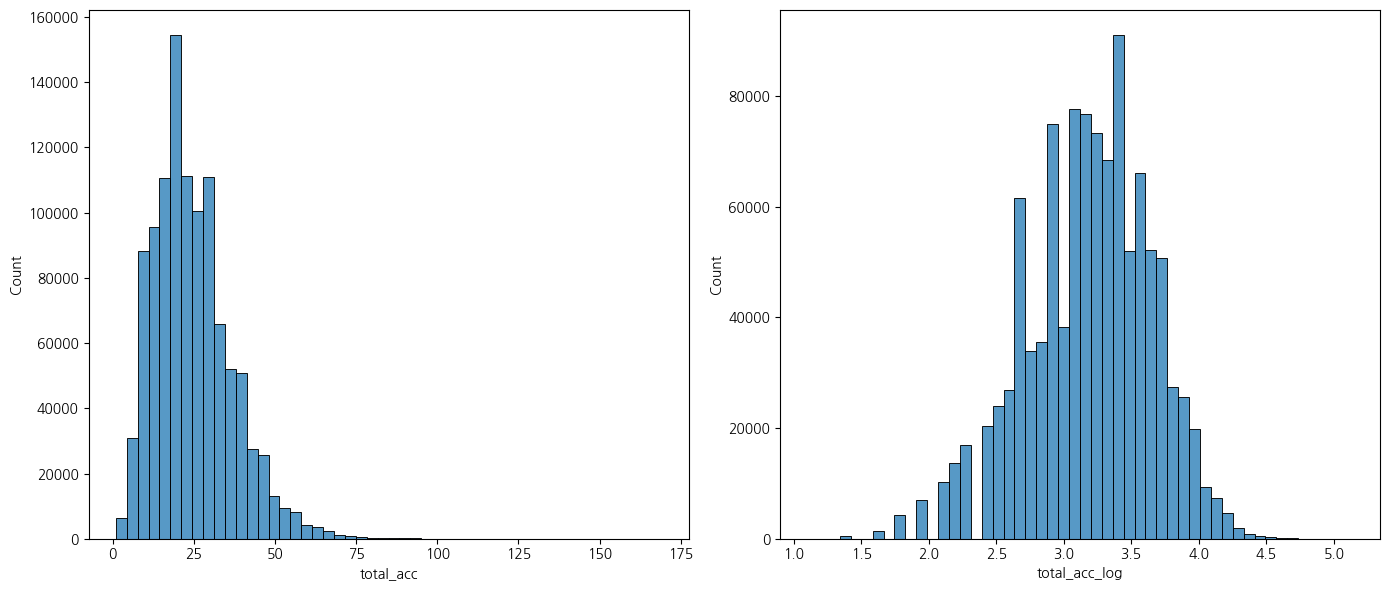

In [1260]:
temp = df.copy()
temp['total_acc_log'] = np.log1p(1 + temp['total_acc'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['total_acc'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['total_acc_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1261]:
df['total_acc'] = np.log1p(1 + df['total_acc'])  

# inq_last_6mths

In [1262]:
check(df, 'inq_last_6mths')

count 1,075,398.00
mean 0.62  std 0.92
min 0.00
25% 0.00  50% 0.00  75% 1.00
max 31.00

nan_num = 0
nan_ratio = 0.0 %
unique = [ 1.  0.  2.  5.  3.  4.  6.  7. 13.  9. 10.  8. 16. 14. 11. 12. 15. 18.
 19. 28. 17. 25. 31. 24.]
unique_num = 24
type = float64


In [1263]:
df['inq_last_6mths'].value_counts(normalize=True)

inq_last_6mths
0.0     5.875127e-01
1.0     2.681603e-01
2.0     9.605281e-02
3.0     3.460207e-02
4.0     9.309112e-03
5.0     3.401531e-03
6.0     7.011358e-04
7.0     1.106567e-04
8.0     6.974162e-05
9.0     3.068631e-05
10.0    1.673799e-05
12.0    9.298883e-06
15.0    4.649441e-06
11.0    4.649441e-06
14.0    3.719553e-06
16.0    1.859777e-06
13.0    1.859777e-06
18.0    9.298883e-07
19.0    9.298883e-07
28.0    9.298883e-07
17.0    9.298883e-07
25.0    9.298883e-07
31.0    9.298883e-07
24.0    9.298883e-07
Name: proportion, dtype: float64

In [1264]:
df['inq_last_6mths'] = pd.cut(
    df['inq_last_6mths'],
    bins=[-1,0,1,100],
    labels=[0, 1, 2]
)

In [1265]:
df['inq_last_6mths'].value_counts(normalize=True)

inq_last_6mths
0    0.587513
1    0.268160
2    0.144327
Name: proportion, dtype: float64

In [1266]:
categorical_cols.append('inq_last_6mths')

# term

In [1267]:
check(df, 'term')

nan_num = 0
nan_ratio = 0.0 %
unique = [' 60 months' ' 36 months']
unique_num = 2
type = object


In [1268]:
df['term'] = df['term'].str.replace(' months', '').str.strip().astype(int)

In [1269]:
check(df, 'term')

count 1,075,398.00
mean 41.92  std 10.34
min 36.00
25% 36.00  50% 36.00  75% 36.00
max 60.00

nan_num = 0
nan_ratio = 0.0 %
unique = [60 36]
unique_num = 2
type = int64


In [1270]:
df['term'] = (df['term'] == 36).astype(int)

# emp_length

In [1271]:
if 'emp_length' not in df.columns:
    df = df.merge(raw_df[['id', 'emp_length']], on='id', how='left')

In [1272]:
check(df, 'emp_length')

nan_num = 64316
nan_ratio = 5.98 %
unique = ['10+ years' nan '5 years' '3 years' '< 1 year' '4 years' '7 years'
 '2 years' '6 years' '1 year' '8 years' '9 years']
unique_num = 11
type = object


In [1273]:
df['emp_length'] = df['emp_length'].fillna('unknown')

In [1274]:
categorical_cols.append('emp_length')

# home_ownership

In [1275]:
check(df, 'home_ownership')

nan_num = 0
nan_ratio = 0.0 %
unique = ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'OTHER' 'NONE']
unique_num = 6
type = object


In [1276]:
df['home_ownership'].value_counts(normalize=True)

home_ownership
MORTGAGE    0.486576
RENT        0.401848
OWN         0.110779
ANY         0.000668
OTHER       0.000104
NONE        0.000025
Name: proportion, dtype: float64

In [1277]:
df['home_ownership'] = df['home_ownership'].replace({'ANY': 'OTHER', 'NONE': 'OTHER', 'OTHER': 'OTHER'})

In [1278]:
categorical_cols.append('home_ownership')

# purpose

In [1279]:
check(df, 'purpose')

nan_num = 0
nan_ratio = 0.0 %
unique = ['debt_consolidation' 'home_improvement' 'credit_card' 'other' 'vacation'
 'house' 'medical' 'major_purchase' 'small_business' 'car' 'moving'
 'renewable_energy' 'wedding' 'educational']
unique_num = 14
type = object


In [1280]:
df['purpose'].value_counts(normalize=True)

purpose
debt_consolidation    0.570652
credit_card           0.223545
home_improvement      0.065681
other                 0.060933
major_purchase        0.022591
medical               0.011908
small_business        0.011190
car                   0.010954
vacation              0.007251
moving                0.007027
house                 0.006056
wedding               0.001278
renewable_energy      0.000715
educational           0.000219
Name: proportion, dtype: float64

In [1281]:
categorical_cols.append('purpose')

# mths_since_last_delinq

In [1282]:
check(df, 'mths_since_last_delinq')

count 530,828.00
mean 34.42  std 21.92
min 0.00
25% 16.00  50% 31.00  75% 50.00
max 202.00

nan_num = 544570
nan_ratio = 50.64 %
unique = [ 10.  nan  40.  33.  66.  43.   2.  65.  41.  12.  14.  22.  69.  76.
  26.  51.   5.  67.  78.   3.  74.  24.  15.  50.  57.   1.  17.  23.
  58.  80.   8.  75.  59.  52.  44.  13.  18.  38.  60.   6.   0.  49.
  39.  42.   4.  81.  48.  64.   9.  54.  16.  73.  19.  37.  21.  36.
  46.  30.  25.  31.   7.  70.  32.  97.  28.  35.  11.  34.  29.  79.
  68.  72.  20.  27.  47.  63.  62.  55. 103.  53.  77.  45.  61. 106.
  71.  56.  82.  89.  86.  84.  98.  94. 102. 109.  87.  83. 124. 170.
 105. 126. 101.  93.  95.  85. 129.  92. 111. 115. 108. 120. 133.  88.
  99.  90. 110.  96.  91. 100. 113. 160. 117. 159. 118. 114. 135. 136.
 125. 104. 107. 122. 119. 132. 116. 112. 149. 162. 146. 169. 121. 156.
 161. 143. 134. 141. 131. 140. 176. 154. 195. 178. 130. 158. 153. 151.
 180. 142. 138. 137. 145. 123. 192. 148. 171. 152. 202. 157.]
unique_num = 165
ty

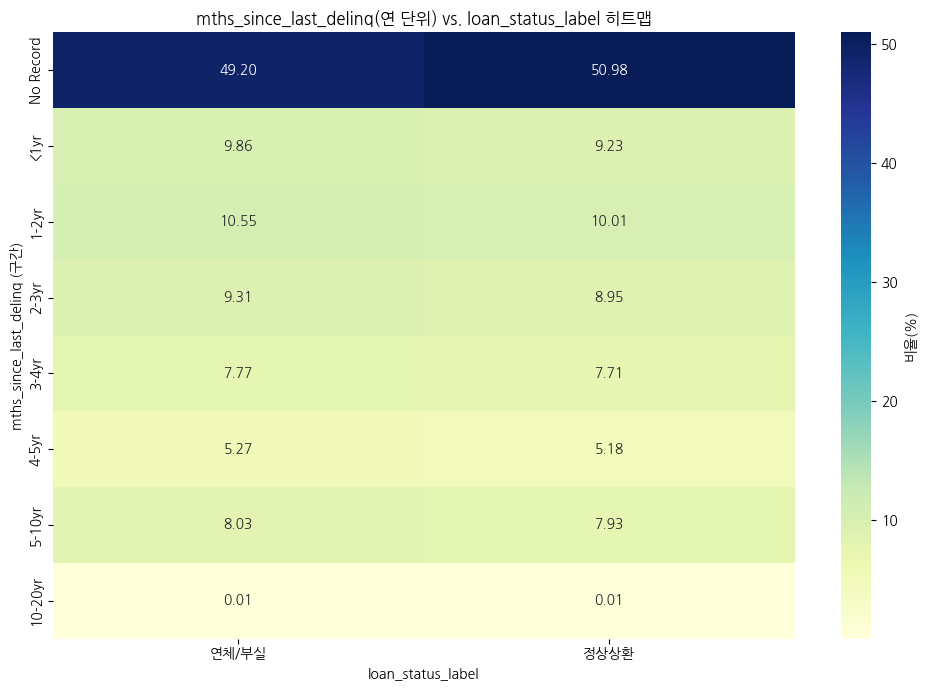

In [1283]:
def delinq_cat(x):
    if pd.isna(x):
        return 'No Record'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 120:
        return '5-10yr'
    elif x <= 240:
        return '10-20yr'
    else:
        return '20yr+'

df['mths_since_last_delinq_cat'] = df['mths_since_last_delinq'].apply(delinq_cat)

cat_order = ['No Record', '<1yr', '1-2yr', '2-3yr', '3-4yr', '4-5yr', '5-10yr', '10-20yr', '20yr+']
df['mths_since_last_delinq_cat'] = pd.Categorical(df['mths_since_last_delinq_cat'], categories=cat_order, ordered=True)

pivot = pd.crosstab(
    df['mths_since_last_delinq_cat'],
    df['loan_status_label'],
    normalize='columns'
) * 100

plt.figure(figsize=(10,7))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': '비율(%)'}
)
plt.title('mths_since_last_delinq(연 단위) vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mths_since_last_delinq (구간)')
plt.tight_layout()
plt.show()

In [1284]:
def delinq_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    else:
        return '5yr+'

df['mths_since_last_delinq'] = df['mths_since_last_delinq'].apply(delinq_cat)

In [1285]:
df['mths_since_last_delinq'].value_counts(normalize=True)

mths_since_last_delinq
unknown    0.506389
1-2yr      0.101119
<1yr       0.093519
2-3yr      0.090203
5yr+       0.079563
3-4yr      0.077223
4-5yr      0.051984
Name: proportion, dtype: float64

In [1286]:
categorical_cols.append('mths_since_last_delinq')

# mths_since_last_major_derog

In [1287]:
check(df, "mths_since_last_major_derog")

count 282,155.00
mean 43.93  std 21.44
min 0.00
25% 27.00  50% 44.00  75% 61.00
max 202.00

nan_num = 793243
nan_ratio = 73.76 %
unique = [ nan  54.  50.  66.  27.  14.  22.  69.  26.  52.  36.  40.  62.  74.
  58.  57.  31.  23.  43.  80.  75.  44.  18.  30.   0.  70.  78.  39.
  53.  56.   4.  73.   9.  48.  55.  47.  33.  41.  21.  37.  65.  46.
  42.  38.  76.  81.  28.  79.  17.  45.  49.   6.  97.   1.  10.  34.
  60.  11.  12.  15.   8.  13.  61.  32.  72.  59.  67.  68.  24.  20.
 103.  35.  51.  19.  25.  71.  77.  29.  63. 106.  82.  64.   7.   5.
  89.  16.   3.   2.  86.  84. 130.  98.  94. 102.  91. 109.  87.  95.
  88. 107.  83.  92.  96. 104. 124.  90. 121. 170. 105. 126. 101.  93.
 113.  85. 129.  99. 111. 115. 108. 120. 133. 114. 110. 118. 122. 117.
 100. 119. 160. 127. 159. 135. 125. 136. 132. 175. 116. 140. 112. 149.
 162. 154. 144. 158. 146. 139. 169. 123. 155. 156. 148. 161. 131. 143.
 165. 134. 141. 176. 195. 138. 147. 178. 145. 128. 153. 152. 137. 151.
 180. 142.

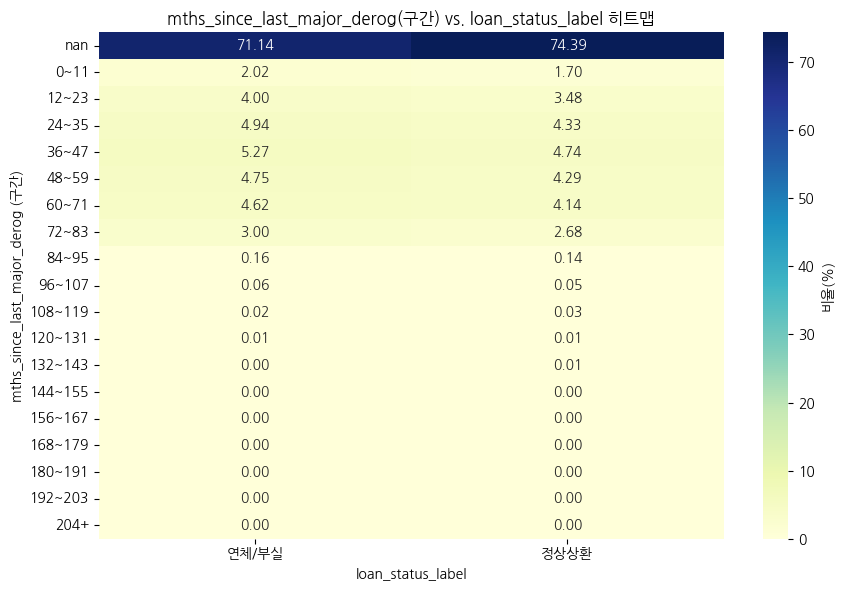

In [1288]:
temp = df.copy()

# 1. 구간(binning) 설정 (12개월 단위 예시, max=202 → 204까지 커버)
bins = list(range(0, 205, 12)) + [999]
labels = [f'{i}~{i+11}' for i in range(0, 204, 12)] + ['204+']
temp['major_derog_bin'] = pd.cut(
    temp['mths_since_last_major_derog'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 2. 피봇테이블 (dropna=False로 NaN행도 포함)
pivot = pd.crosstab(
    temp['major_derog_bin'],
    temp['loan_status_label'],
    normalize='columns',
    dropna=False
) * 100

# 3. 히트맵 시각화
plt.figure(figsize=(9,6))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': '비율(%)'}
)
plt.title('mths_since_last_major_derog(구간) vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mths_since_last_major_derog (구간)')
plt.tight_layout()
plt.show()

In [1289]:
def major_derog_cat_simple(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 72:
        return '5-6yr'
    else:
        return '6yr+'

df['mths_since_last_major_derog'] = df['mths_since_last_major_derog'].apply(major_derog_cat_simple)

In [1290]:
df['mths_since_last_major_derog'].value_counts(normalize=True)

mths_since_last_major_derog
unknown    0.737627
3-4yr      0.048435
2-3yr      0.044909
4-5yr      0.043353
5-6yr      0.042198
1-2yr      0.036639
6yr+       0.026544
<1yr       0.020295
Name: proportion, dtype: float64

In [1291]:
categorical_cols.append('mths_since_last_major_derog')

# mths_since_last_record

In [1292]:
check(df, "mths_since_last_record")

count 179,095.00
mean 71.26  std 26.66
min 0.00
25% 54.00  50% 73.00  75% 91.00
max 127.00

nan_num = 896303
nan_ratio = 83.35 %
unique = [ nan  34.  61.  59.  68.  73.  50.  60.  29.  78.  26.  91.  69.  89.
  12.  58.  96.  94.  49.   0. 103. 108.   2.  42.  64.  93.  84.  62.
  47.  36.  88.  74.  85. 114.  90.  81.  14. 113.  75.  18.  25.  70.
  95. 115.  97. 106.  48.  99.  76. 116. 109.  72.  98.  39.  53.  86.
  51.  82.  32. 100.  79. 117.  63.  33.  57.  40. 118. 107.  66.  31.
  83.  30.  27.  54.  17.  80. 102.  92.  55.  22.  46.  67.  52.  56.
  35.  37.  16. 111. 105.  44. 101.  71.  38.  11.  65.  19.  77.  28.
  20.  45. 104. 119.  24.  87.  41. 112. 110.  43.   6. 120.   8.   4.
   7.  15.   9.  23.  10.  13.  21. 126.   5.   3.   1. 122. 121. 123.
 124. 127.]
unique_num = 127
type = float64


In [1293]:
mask = df['mths_since_last_record'].notna()
df.loc[mask, 'mths_since_last_record'] = df.loc[mask, 'mths_since_last_record'].astype(int)

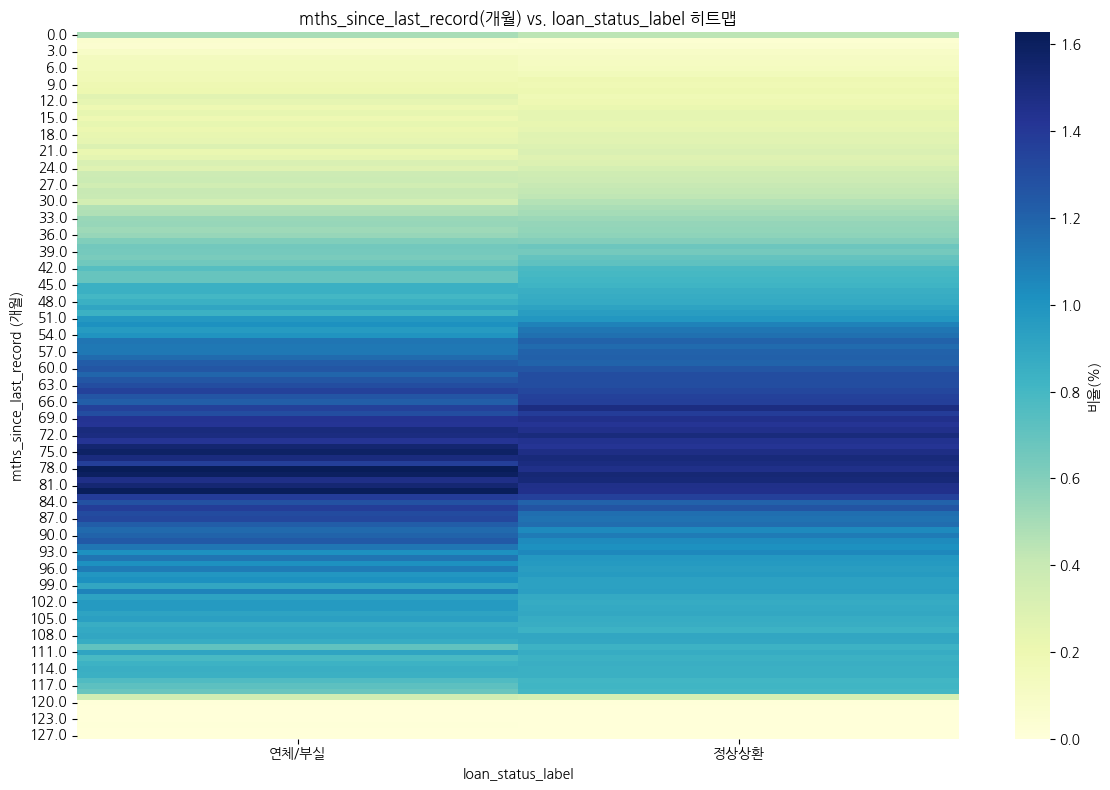

In [1294]:
# 피봇테이블 생성: y축은 mths_since_last_record, x축은 loan_status_label, 값은 컬럼 내 비율(%)
pivot = pd.crosstab(
    df['mths_since_last_record'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# y축 값 오름차순 정렬 (NaN은 자동 미포함)
pivot = pivot.sort_index()

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=False,
    fmt='.2f',
    cbar_kws={'label': '비율(%)'}
)
plt.title('mths_since_last_record(개월) vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mths_since_last_record (개월)')
plt.tight_layout()
plt.show()

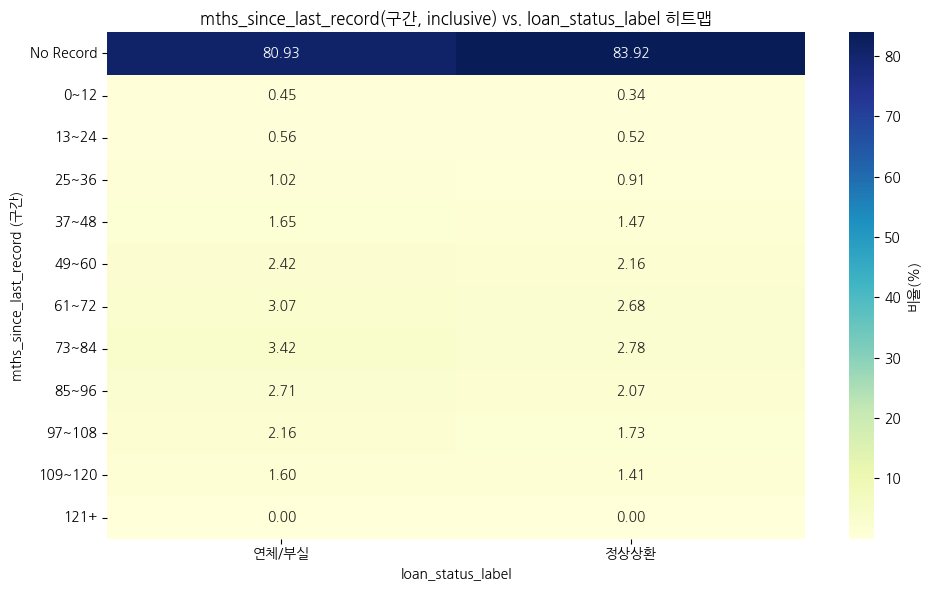

In [1295]:
# 1. bin 구간과 라벨 직접 설정 (inclusive: 0~12, 13~24, ...)
bins = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132]
labels = ['0~12','13~24','25~36','37~48','49~60','61~72','73~84','85~96','97~108','109~120','121+']

temp = df.copy()

# 2. cut, NaN은 'No Record'로 별도 처리
def bin_with_nan(x):
    if pd.isna(x):
        return 'No Record'
    for i, b in enumerate(bins):
        if i < len(bins)-1 and b <= x <= bins[i+1]:
            return labels[i]
    return '121+'

temp['record_bin'] = temp['mths_since_last_record'].apply(bin_with_nan)

# 3. 피봇테이블 (NaN 포함, 비율 normalize)
pivot = pd.crosstab(
    temp['record_bin'],
    temp['loan_status_label'],
    normalize='columns'
) * 100

# 4. label 순서 맞추기
cat_order = ['No Record'] + labels
pivot = pivot.reindex(cat_order)

# 5. 히트맵 시각화
plt.figure(figsize=(10,6))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': '비율(%)'}
)
plt.title('mths_since_last_record(구간, inclusive) vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mths_since_last_record (구간)')
plt.tight_layout()
plt.show()

In [1296]:
def record_bin_1to9plus(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 36:
        return '<3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 72:
        return '5-6yr'
    elif x <= 84:
        return '6-7yr'
    elif x <= 96:
        return '7-8yr'
    else:
        return '9yr+'

df['mths_since_last_record'] = df['mths_since_last_record'].apply(record_bin_1to9plus)

In [1297]:
df['mths_since_last_record'].value_counts(normalize=True)

mths_since_last_record
unknown    0.833462
9yr+       0.032633
6-7yr      0.029063
5-6yr      0.027538
4-5yr      0.022131
7-8yr      0.021949
<3yr       0.018186
3-4yr      0.015039
Name: proportion, dtype: float64

In [1298]:
categorical_cols.append('mths_since_last_record')

# mths_since_rcnt_il

In [1299]:
check(df, 'mths_since_rcnt_il')

count 550,240.00
mean 20.08  std 25.14
min 0.00
25% 7.00  50% 12.00  75% 23.00
max 511.00

nan_num = 525158
nan_ratio = 48.83 %
unique = [ 10.  15. 226.  nan  17.  53.   3.   9.   2.  30.  19.   7.  28.  22.
  49.   6.  12.  11.   1.  90.   5.   8.  27.  36.  25.  14.  18.  31.
  13.   4.  42.  26.  16. 109.  73.  66.  21.  23.  32.  20.  24.  87.
  41. 117.  40.  39.  45.  29.  94. 104.  58.  38.  34.  33. 119. 260.
 148.  93.  59. 127.  96.  44. 114.  51.  46.  47.  92.  68. 103. 173.
  52. 113.  60.  48.  62.  35.  57. 140.  82. 123.  91.  61.  69.  71.
 137.  85. 101.  83.  43.  65.  70.  67. 131.  37. 151.  55.  50.  54.
 139. 124. 111. 118.  72.  99.  95.  56.  84.  88. 144. 102.  74. 133.
 193.  79.  64. 112.  97. 177.  81.  77. 129. 106. 134. 100. 105.   0.
 166. 154. 125.  80.  86. 153. 128.  63. 164. 158. 155. 115. 217.  76.
  75. 170. 146. 138. 202. 121. 107.  78. 122.  98. 108. 142. 176. 156.
 145. 162.  89. 120. 110. 116. 132. 130. 163. 184. 135. 161. 228. 126.
 147. 377. 

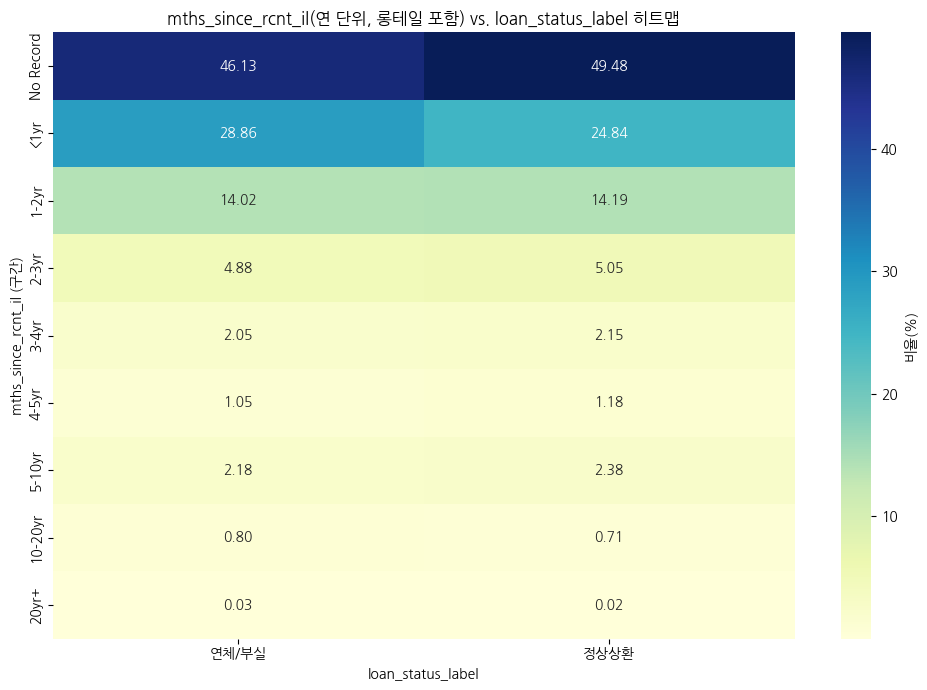

In [1300]:
def rcnt_il_cat(x):
    if pd.isna(x):
        return 'No Record'
    elif x<= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 120:
        return '5-10yr'
    elif x <= 240:
        return '10-20yr'
    else:
        return '20yr+'

df['rcnt_il_cat'] = df['mths_since_rcnt_il'].apply(rcnt_il_cat)

cat_order = ['No Record', '<1yr', '1-2yr', '2-3yr', '3-4yr', '4-5yr', '5-10yr', '10-20yr', '20yr+']
df['rcnt_il_cat'] = pd.Categorical(df['rcnt_il_cat'], categories=cat_order, ordered=True)

pivot = pd.crosstab(
    df['rcnt_il_cat'],
    df['loan_status_label'],
    normalize='columns'
) * 100

plt.figure(figsize=(10,7))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': '비율(%)'}
)
plt.title('mths_since_rcnt_il(연 단위, 롱테일 포함) vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mths_since_rcnt_il (구간)')
plt.tight_layout()
plt.show()

In [1301]:
def rcnt_il_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x<= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    else:
        return '2yr+'

df['mths_since_rcnt_il'] = df['mths_since_rcnt_il'].apply(rcnt_il_cat)

In [1302]:
df['mths_since_rcnt_il'].value_counts(normalize=True)

mths_since_rcnt_il
unknown    0.488338
<1yr       0.256121
1-2yr      0.141557
2yr+       0.113984
Name: proportion, dtype: float64

In [1303]:
categorical_cols.append('mths_since_rcnt_il')

# mths_since_recent_bc

In [1304]:
check(df, 'mths_since_recent_bc')

count 1,035,617.00
mean 24.01  std 31.09
min 0.00
25% 6.00  50% 13.00  75% 29.00
max 656.00

nan_num = 39781
nan_ratio = 3.7 %
unique = [  7.   6.  14.  20.  19.   8.  21.  34.  29.   5.  18.   3.  33.  12.
  27.   9.  13.  22.  62.  55. 183.   4.  10.  80.  24.  28.   0.  42.
  15.  16.  44.  35.  25.  23.   2.  11.  78.  41.  96.  50. 136.  30.
   1.  40. 122.  56.  17.  49.  nan  77. 144.  81.  46.  47.  36.  74.
  32.  39.  68.  61.  31.  82.  57. 175. 143.  52.  79.  60.  26.  58.
  76.  51. 120. 161.  87.  71.  37.  73.  84.  53.  63. 100.  64. 133.
  90. 197.  48. 139.  65.  86. 167. 117.  66.  67.  69. 114.  43. 134.
  45. 297.  38. 121.  59.  89. 112. 105. 141. 109. 191.  75.  54.  92.
  70. 179.  91. 140. 135. 113. 165. 132. 106. 166. 108. 115. 104. 279.
  83. 111.  93. 107.  95. 123. 149. 118. 192.  85.  98. 304. 155. 147.
 124.  72. 201.  97. 283. 265.  99. 119. 173. 116. 110. 128. 235. 101.
 196. 169. 204.  94. 145. 159. 156. 138. 182. 125. 177. 158. 152. 130.
 129. 127. 1

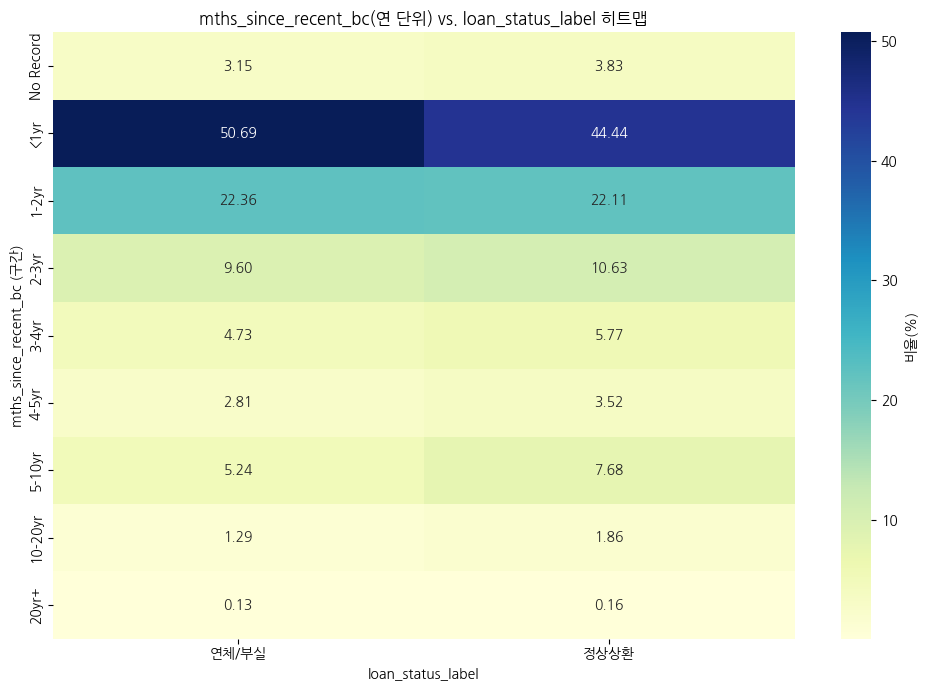

In [1305]:
def recent_bc_cat(x):
    if pd.isna(x):
        return 'No Record'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 120:
        return '5-10yr'
    elif x <= 240:
        return '10-20yr'
    else:
        return '20yr+'

df['mths_since_recent_bc_cat'] = df['mths_since_recent_bc'].apply(recent_bc_cat)

cat_order = ['No Record', '<1yr', '1-2yr', '2-3yr', '3-4yr', '4-5yr', '5-10yr', '10-20yr', '20yr+']
df['mths_since_recent_bc_cat'] = pd.Categorical(df['mths_since_recent_bc_cat'], categories=cat_order, ordered=True)

pivot = pd.crosstab(
    df['mths_since_recent_bc_cat'],
    df['loan_status_label'],
    normalize='columns'
) * 100

plt.figure(figsize=(10,7))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': '비율(%)'}
)
plt.title('mths_since_recent_bc(연 단위) vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mths_since_recent_bc (구간)')
plt.tight_layout()
plt.show()

In [1306]:
def recent_bc_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    else:
        return '3yr+'

df['mths_since_recent_bc'] = df['mths_since_recent_bc'].apply(recent_bc_cat)

In [1307]:
df['mths_since_recent_bc'].value_counts(normalize=True)

mths_since_recent_bc
<1yr       0.456471
1-2yr      0.221563
3yr+       0.180627
2-3yr      0.104347
unknown    0.036992
Name: proportion, dtype: float64

In [1308]:
categorical_cols.append('mths_since_recent_bc')

# mths_since_recent_bc_dlq

In [1309]:
check(df, "mths_since_recent_bc_dlq")

count 252,239.00
mean 39.40  std 22.64
min 0.00
25% 21.00  50% 37.00  75% 58.00
max 202.00

nan_num = 823159
nan_ratio = 76.54 %
unique = [ 10.  nan  48.   2.  41.  32.  65.  43.  40.  74.  24.  58.  54.   1.
  17.  77.  69.   8.  75.  66.  44.  13.  18.   6.   0.  49.  53.  68.
  81.  42.  73.  31.  14.  19.  37.  26.  30.  34.  80.   7.  97.  28.
  45.  35.  11.  25.  51.  71.  55.  39.  50.  29.  78.  46.  59.  67.
  15.  23.  52.  22.  64.  79.   3.  70.  56.  38.  12.  72.  21.  61.
  57.  36.  47.  27.   4.  82.  63.  76.  33.  62.  16.   5.   9.  60.
  86.  96.  92.  20.  84. 108.  87.  89.  94.  91. 101.  90. 107.  83.
  88. 104. 103. 121. 170.  85. 105. 138. 126. 118.  93.  95. 113. 102.
 111. 106.  99. 145. 136. 122. 140. 110.  98. 117. 100. 119. 123. 109.
 127. 159. 135. 112. 115. 125. 114. 129. 191. 124. 116. 149. 162. 198.
 144. 139. 134. 133. 132. 155. 120. 143. 146. 131. 176. 141. 130. 158.
 137. 151. 142. 128. 189. 171. 148. 154. 152. 153. 165. 202. 157.]
unique_num = 1

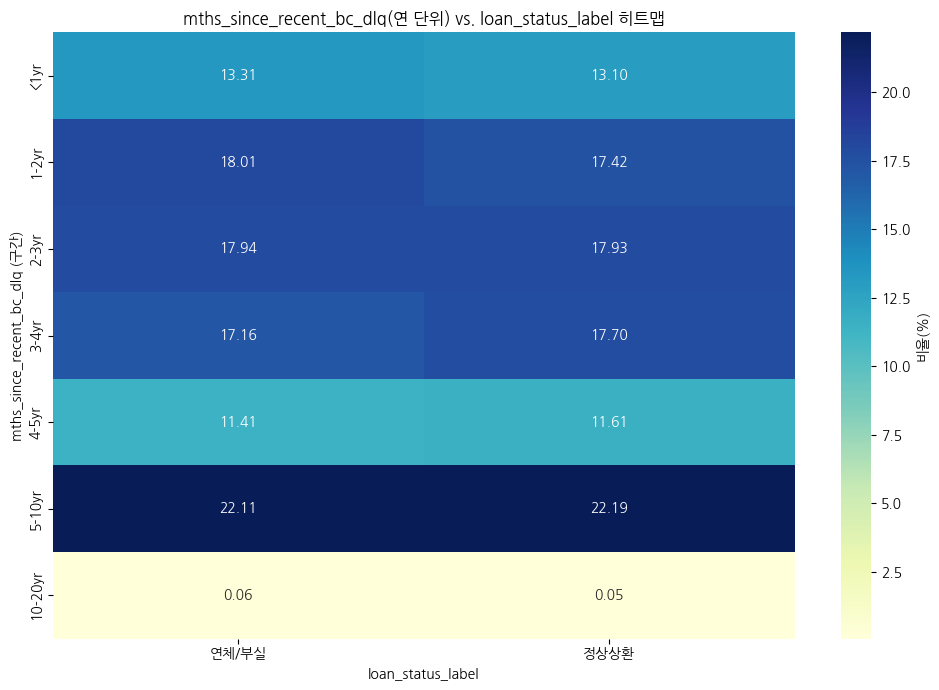

In [1310]:
temp = df.copy()
def recent_bc_dlq_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 120:
        return '5-10yr'
    elif x <= 240:
        return '10-20yr'
    else:
        return '20yr+'

temp['mths_since_recent_bc_dlq_cat'] = temp['mths_since_recent_bc_dlq'].apply(recent_bc_dlq_cat)

cat_order = ['No Record', '<1yr', '1-2yr', '2-3yr', '3-4yr', '4-5yr', '5-10yr', '10-20yr', '20yr+']
temp['mths_since_recent_bc_dlq_cat'] = pd.Categorical(temp['mths_since_recent_bc_dlq_cat'], categories=cat_order, ordered=True)

pivot = pd.crosstab(
    temp['mths_since_recent_bc_dlq_cat'],
    temp['loan_status_label'],
    normalize='columns'
) * 100

plt.figure(figsize=(10,7))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': '비율(%)'}
)
plt.title('mths_since_recent_bc_dlq(연 단위) vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mths_since_recent_bc_dlq (구간)')
plt.tight_layout()
plt.show()

In [1311]:
def recent_bc_dlq_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    else:
        return '5yr+'

df['mths_since_recent_bc_dlq'] = df['mths_since_recent_bc_dlq'].apply(recent_bc_dlq_cat)

In [1312]:
df['mths_since_recent_bc_dlq'].value_counts(normalize=True)

mths_since_recent_bc_dlq
unknown    0.765446
5yr+       0.052141
2-3yr      0.042069
3-4yr      0.041254
1-2yr      0.041128
<1yr       0.030823
4-5yr      0.027139
Name: proportion, dtype: float64

In [1313]:
categorical_cols.append('mths_since_recent_bc_dlq')

# mths_since_recent_inq

In [1314]:
check(df, "mths_since_recent_inq")

count 939,849.00
mean 6.82  std 5.88
min 0.00
25% 2.00  50% 5.00  75% 10.00
max 25.00

nan_num = 135549
nan_ratio = 12.6 %
unique = [ 0. 15.  6.  5.  7.  3.  9. 22.  2. 11. nan 10.  4.  1. 20.  8. 18. 19.
 14. 16. 12. 21. 13. 17. 23. 24. 25.]
unique_num = 26
type = float64


In [1315]:
(df['mths_since_recent_inq'].value_counts(normalize=True) * 100).round(2)

mths_since_recent_inq
1.0     11.21
2.0      9.04
0.0      8.95
3.0      8.21
4.0      7.44
5.0      6.58
6.0      5.90
7.0      5.61
8.0      4.91
9.0      4.28
10.0     3.76
11.0     3.36
12.0     3.03
13.0     2.67
14.0     2.39
15.0     2.06
16.0     1.79
17.0     1.62
18.0     1.44
19.0     1.30
20.0     1.17
21.0     1.04
22.0     0.95
23.0     0.88
24.0     0.44
25.0     0.00
Name: proportion, dtype: float64

In [1316]:
def inq_bin(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 0:
        return '0'
    elif x == 1:
        return '1'
    elif x == 2:
        return '2'
    elif x == 3:
        return '3'
    elif x == 4:
        return '4'
    elif x == 5:
        return '5'
    elif x == 6:
        return '6'
    elif x == 7:
        return '7'
    elif x == 8:
        return '8'
    elif x == 9:
        return '9'
    else:
        return '10+'

df['mths_since_recent_inq'] = df['mths_since_recent_inq'].apply(inq_bin)

In [1317]:
df['mths_since_recent_inq'].value_counts(normalize=True)

mths_since_recent_inq
10+        0.243670
unknown    0.126045
1          0.098006
2          0.078980
0          0.078193
3          0.071746
4          0.065064
5          0.057477
6          0.051539
7          0.049001
8          0.042908
9          0.037370
Name: proportion, dtype: float64

In [1318]:
categorical_cols.append('mths_since_recent_inq')

# mths_since_recent_revol_delinq

In [1319]:
check(df, "mths_since_recent_revol_delinq")

count 357,885.00
mean 35.76  std 22.39
min 0.00
25% 17.00  50% 33.00  75% 52.00
max 202.00

nan_num = 717513
nan_ratio = 66.72 %
unique = [ 10.  nan  43.  33.   2.  41.  73.  78.  32.  65.  67.  26.   3.  74.
  24.  58.  54.  57.   1.  17.  77.  69.   8.  75.  66.  44.  13.  35.
  18.   6.   0.  49.  38.  12.  39.  53.  23.  68.  81.  42.  31.  64.
  45.  19.  62.  37.  70.  14.  30.  25.   5.  79.   7.  97.  28.  16.
  11.  34.  29.  40.  60.  55.   4.  22.  20.  27.  50.  21.  63.  46.
  48.  15.  51.  52.  56.  80.  36.   9.  61.  72. 106.  71.  82.  76.
  59.  47.  89.  86. 107.  84. 108.  94.  87.  98. 102.  91. 103.  90.
  83. 104.  96. 124. 170. 105.  92. 138.  93. 126. 101.  95. 113.  85.
 129.  99. 111. 115. 133. 114.  88. 145. 122. 123. 110. 118. 117. 100.
 119. 109. 160. 127. 159. 112. 135. 136. 125. 116. 120. 132. 149. 162.
 154. 121. 146. 139. 169. 128. 156. 161. 142. 197. 143. 165. 134. 141.
 131. 140. 176. 178. 130. 158. 153. 151. 180. 137. 177. 171. 148. 152.
 202. 157.

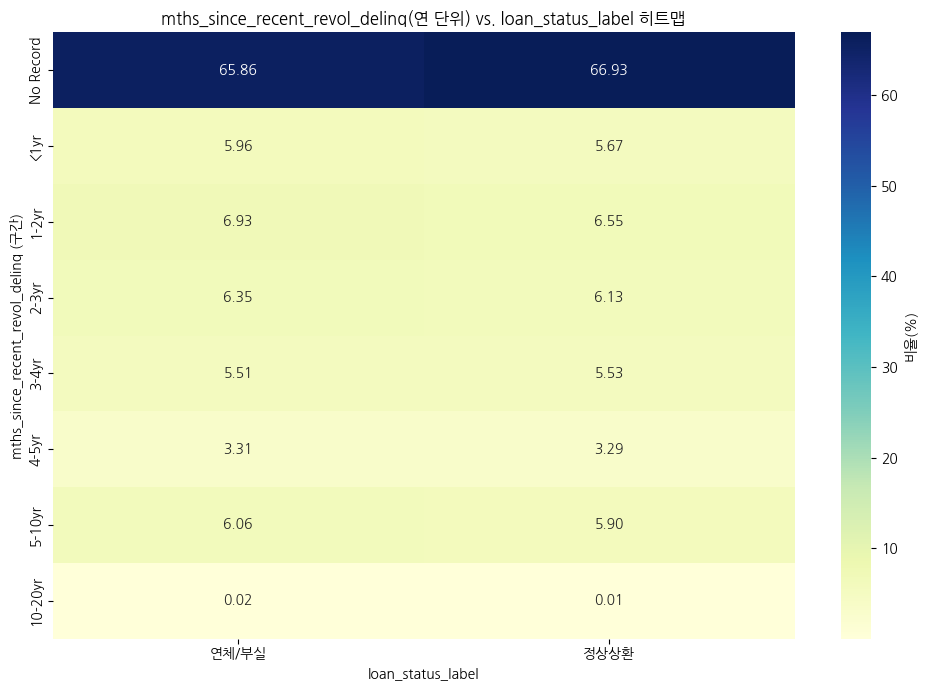

In [1320]:
def revol_delinq_cat(x):
    if pd.isna(x):
        return 'No Record'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    elif x <= 120:
        return '5-10yr'
    elif x <= 240:
        return '10-20yr'
    else:
        return '20yr+'

df['mths_since_recent_revol_delinq_cat'] = df['mths_since_recent_revol_delinq'].apply(revol_delinq_cat)

cat_order = ['No Record', '<1yr', '1-2yr', '2-3yr', '3-4yr', '4-5yr', '5-10yr', '10-20yr', '20yr+']
df['mths_since_recent_revol_delinq_cat'] = pd.Categorical(df['mths_since_recent_revol_delinq_cat'], categories=cat_order, ordered=True)

pivot = pd.crosstab(
    df['mths_since_recent_revol_delinq_cat'],
    df['loan_status_label'],
    normalize='columns'
) * 100

plt.figure(figsize=(10,7))
sns.heatmap(
    pivot,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': '비율(%)'}
)
plt.title('mths_since_recent_revol_delinq(연 단위) vs. loan_status_label 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('mths_since_recent_revol_delinq (구간)')
plt.tight_layout()
plt.show()

In [1321]:
def revol_delinq_cat(x):
    if pd.isna(x):
        return 'unknown'
    elif x <= 12:
        return '<1yr'
    elif x <= 24:
        return '1-2yr'
    elif x <= 36:
        return '2-3yr'
    elif x <= 48:
        return '3-4yr'
    elif x <= 60:
        return '4-5yr'
    else:
        return '5yr+'

df['mths_since_recent_revol_delinq'] = df['mths_since_recent_revol_delinq'].apply(revol_delinq_cat)

In [1322]:
df['mths_since_recent_revol_delinq'].value_counts(normalize=True)

mths_since_recent_revol_delinq
unknown    0.667207
1-2yr      0.066238
2-3yr      0.061691
5yr+       0.059456
<1yr       0.057230
3-4yr      0.055232
4-5yr      0.032947
Name: proportion, dtype: float64

In [1323]:
categorical_cols.append('mths_since_recent_revol_delinq')

In [1324]:
df['loan_status'] = df['loan_status_bin']

In [1325]:
df = df.drop('loan_status_bin', axis=1)

# verification_status

In [1326]:
check(df, 'verification_status')

nan_num = 0
nan_ratio = 0.0 %
unique = ['Verified' 'Not Verified' 'Source Verified']
unique_num = 3
type = object


In [1327]:
categorical_cols.append('verification_status')

# fico

In [1328]:
df['fico'] = (df['fico_range_high'] + df['fico_range_low']) / 2

In [1329]:
df = df.drop(['fico_range_high', 'fico_range_low'], axis=1)

# earliest_cr_line

In [1330]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

df['credit_hist_months'] = (
    df['issue_d'].dt.to_period('M')
  - df['earliest_cr_line'].dt.to_period('M')
).apply(lambda x: x.n)

In [1331]:
check(df, 'credit_hist_months')

count 1,075,398.00
mean 195.26  std 90.94
min 6.00
25% 135.00  50% 177.00  75% 241.00
max 999.00

nan_num = 0
nan_ratio = 0.0 %
unique = [278 401 226 190 206  99  92 162  40 169 197 275 286 376 189 151 168 192
 211  90 184 216 187 214  64 492 221 457 217 346  94 143 164 185 270 209
 198 129  77 119 167 386 183 364 158 250 246 259 482 132 204 191  44 147
 258 150 264 122 175 233 133 232 408 297  45 341 335 130 144 159  89 172
 140 202 238 116 166 349 298 319 224 165  71 256 148 407 128 131  63 234
 180 174 103  43 377 365 127 304  39 142 201 176 507  47 195 252 112 125
 279 247  93 332 359  78 218 126 318 117 118 121 415 235 181 268 145 124
  61 383 219 109  96 322 111 104 283  75 153 317 296 299 223 160 199 171
 207 302 303 208 149 292 136 284 405  48 138  65 156 154 230 193 186 196
 368 179 305 137 115 265 170 100  72 225  87  91 260 200 210 212 173  70
 203 161 139  85 271 301 380 436 108 262 266 288 290 385   8 231 423 248
 439 227 134 152 391 177 276 513  57 333  80 533 257 273 241

In [1332]:
df = df.drop('earliest_cr_line', axis=1)

# tot_coll_amt

In [1333]:
check(df, 'tot_coll_amt')

count 1,033,382.00
mean 234.68  std 5573.93
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 5252395.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [    0.   276.   573. ... 26283. 15424. 16980.]
unique_num = 11709
type = float64


<Axes: xlabel='loan_status_label', ylabel='tot_coll_amt'>

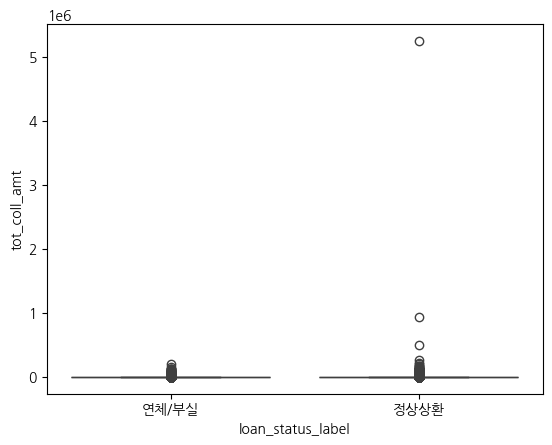

In [1334]:
sns.boxplot(df, x='loan_status_label', y='tot_coll_amt')

In [1335]:
df['tot_coll_amt'] = df['tot_coll_amt'].fillna(0)

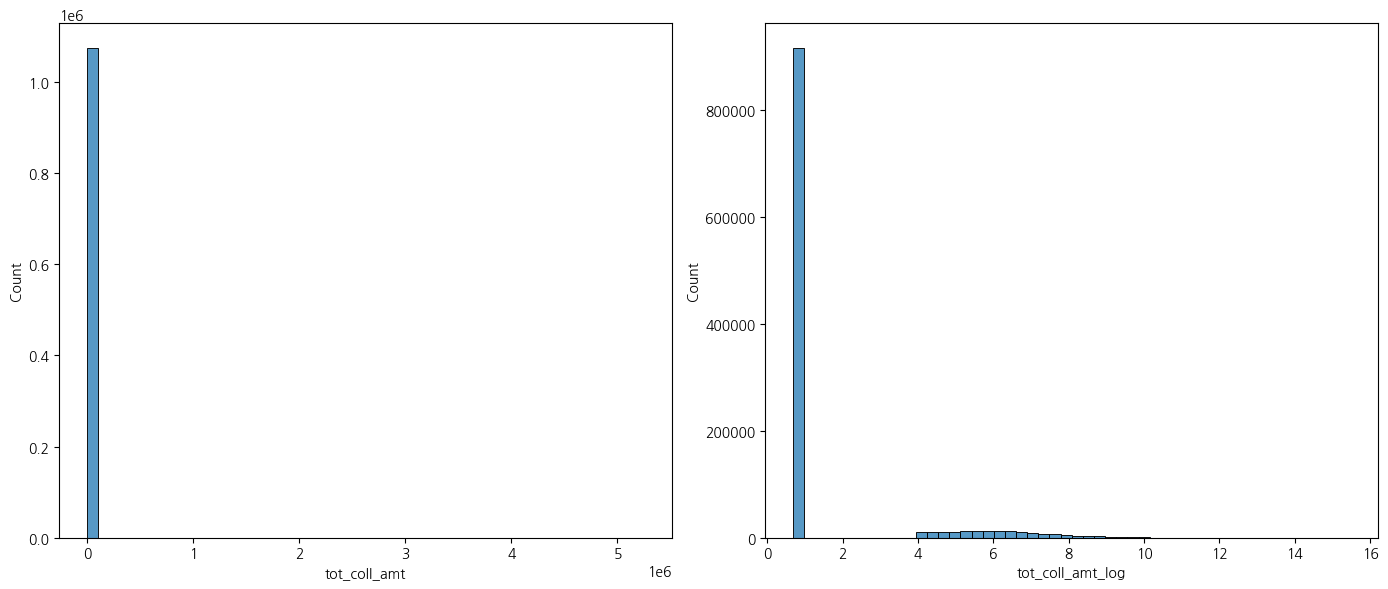

In [1336]:
temp = df.copy()
temp['tot_coll_amt_log'] = np.log1p(1 + temp['tot_coll_amt'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['tot_coll_amt'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['tot_coll_amt_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1337]:
df['tot_coll_amt'] = np.log1p(1 + df['tot_coll_amt'])  

# num_accts_ever_120_pd

In [1338]:
check(df, 'num_accts_ever_120_pd')

count 1,033,382.00
mean 0.51  std 1.36
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 45.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [ 0.  5.  3.  1.  2.  6.  7. nan  4.  9. 10.  8. 12. 13. 19. 11. 17. 15.
 14. 20. 16. 30. 18. 22. 35. 32. 26. 21. 34. 39. 24. 27. 25. 28. 36. 29.
 33. 23. 42. 31. 38. 45.]
unique_num = 41
type = float64


In [1339]:
df['num_accts_ever_120_pd'] = df['num_accts_ever_120_pd'].fillna(0)

<Axes: xlabel='loan_status_label', ylabel='num_accts_ever_120_pd'>

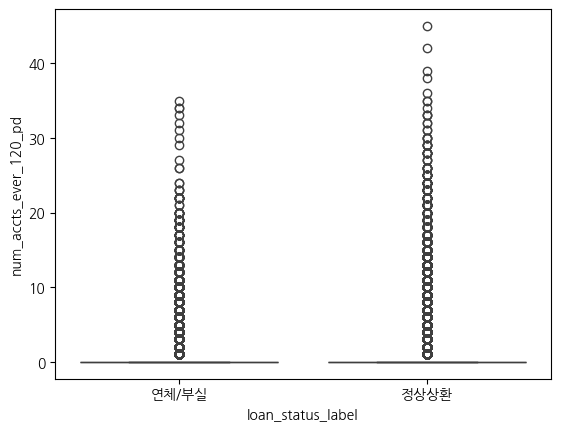

In [1340]:
sns.boxplot(df, x='loan_status_label', y='num_accts_ever_120_pd')

In [1341]:
cols

['grade',
 'installment',
 'int_rate',
 'issue_d',
 'loan_amnt',
 'loan_status_label',
 'sub_grade',
 'total_pymnt',
 'loan_status']

# mo_sin_old_il_acct

In [1342]:
check(df, 'mo_sin_old_il_acct')

count 1,002,641.00
mean 125.58  std 52.94
min 0.00
25% 96.00  50% 129.00  75% 153.00
max 999.00

nan_num = 72757
nan_ratio = 6.77 %
unique = [126. 134. 226. 149. 142.  53.  92.  39.  33. 106. 136. 133. 137. 183.
 167. 146. 211.  26.  99. 158. 219.  78. 155.  41. 118. 143. 144. 114.
  88.  68. 159. 209. 198.  67. 119. 127. 192. 150.  86. 203. 131. 123.
  21. 147. 117. 148. 264. 121.  85.  94. 232. 125. 111.  18.  42. 157.
  47. 172. 139. 132. 238.  95. 116. 141. 120. 140.  91. 173.  nan  89.
 165.  70. 104. 153. 216. 101.  25.  63. 237.  45.  28.  48. 201. 162.
 176. 164. 103.  14.  40.   5.  90.  93.  37. 163.  73.  77. 189. 235.
 130.  87.  74.  61. 160.  71.   8. 169. 112.  49. 109.  75. 166. 108.
 129. 179. 317.  98. 154. 210. 207. 181. 168.  17.  64. 174. 199. 195.
  55.  83. 230. 186.  56. 305. 122. 191. 218. 170.  46.  96. 224. 156.
 200.  13.  20.  27.  81.  69. 202.  32. 184. 197. 135. 185. 110. 161.
 128. 231. 247. 145. 151.  44.  50. 276.  79. 138.  29. 171.  38.  72.
  19. 1

In [1343]:
df[df['mo_sin_old_il_acct'].isna()]['loan_status_label'].value_counts()

loan_status_label
정상상환     59445
연체/부실    13312
Name: count, dtype: int64

In [1344]:
df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].fillna(0)

# chargeoff_within_12_mths

In [1345]:
check(df, 'chargeoff_within_12_mths')

count 1,075,322.00
mean 0.01  std 0.11
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 9.00

nan_num = 76
nan_ratio = 0.01 %
unique = [ 0. nan  1.  2.  3.  5.  6.  4.  9.  7.  8.]
unique_num = 10
type = float64


In [1346]:
df['chargeoff_within_12_mths'] = df['chargeoff_within_12_mths'].fillna(0)

In [1347]:
df['chargeoff_within_12_mths'] = (df['chargeoff_within_12_mths'] >= 1).astype(int)

# total_bal_ex_mort

In [1348]:
check(df, 'total_bal_ex_mort')

count 1,045,475.00
mean 50200.89  std 48731.25
min 0.00
25% 20776.50  50% 37396.00  75% 63196.50
max 2644442.00

nan_num = 29923
nan_ratio = 2.78 %
unique = [294461.  32551.   9573. ... 174686. 154883. 208674.]
unique_num = 169439
type = float64


In [1349]:
# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = df['total_bal_ex_mort'].median()

# 결측값(NaN)을 중앙값으로 대체
df['total_bal_ex_mort'] = df['total_bal_ex_mort'].fillna(median_val)

<Axes: xlabel='loan_status_label', ylabel='total_bal_ex_mort'>

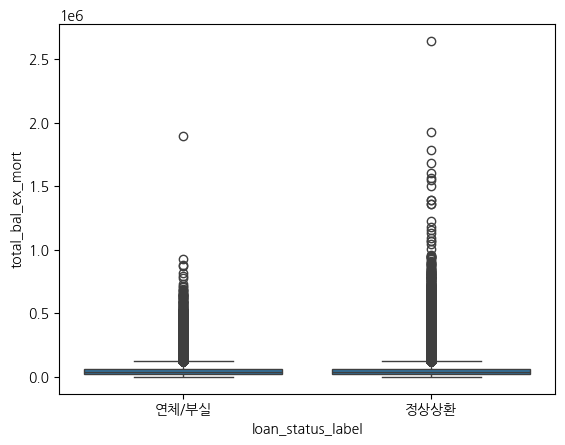

In [1350]:
sns.boxplot(df, x='loan_status_label', y = 'total_bal_ex_mort')

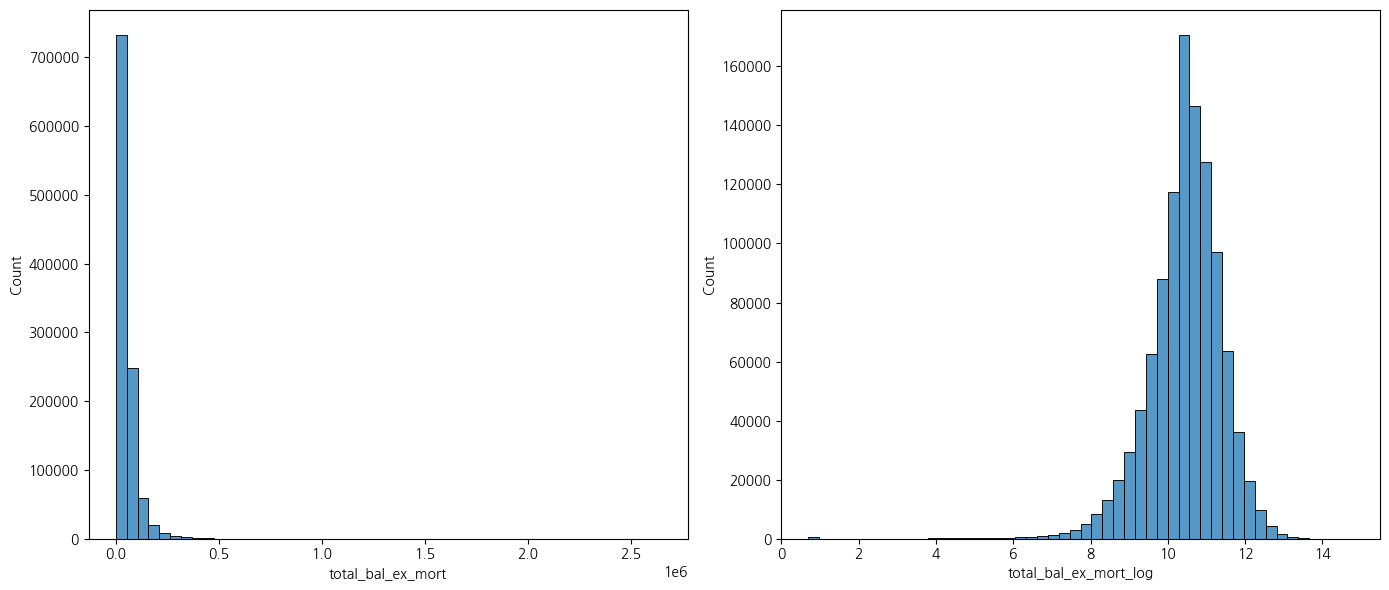

In [1351]:
temp = df.copy()
temp['total_bal_ex_mort_log'] = np.log1p(1 + temp['total_bal_ex_mort'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['total_bal_ex_mort'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['total_bal_ex_mort_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1352]:
df['total_bal_ex_mort'] = np.log1p(1 + df['total_bal_ex_mort'])  

# pct_tl_nvr_dlq

In [1353]:
check(df, 'pct_tl_nvr_dlq')

count 1,033,282.00
mean 94.12  std 8.91
min 0.00
25% 91.30  50% 98.20  75% 100.00
max 100.00

nan_num = 42116
nan_ratio = 3.92 %
unique = [ 94.8 100.   77.8  77.5  91.7  94.1  91.   97.1  90.2  96.7  95.5  86.5
  92.3  95.1  97.6  96.8  94.3  76.9  88.9  67.9  92.9  94.   90.   94.7
  80.6  95.8  82.4  98.4  75.   93.   87.5  97.3  88.5  96.3  97.4  95.2
  49.   88.   95.   92.7  96.2  80.   84.6  92.   88.2  86.   86.2  96.
   nan  85.   90.9  69.   79.   82.   96.4  98.1  89.7  90.6  97.2  84.1
  93.5  94.6  74.1  73.   82.6  79.2  96.6  78.3  87.9  98.6  93.1  97.8
  91.5  97.   63.   86.4  81.   94.4  93.8  53.8  83.3  95.6  71.4  92.6
  81.5  86.1  80.8  93.3  95.7  93.7  89.   77.4  85.7  84.4  79.4  68.8
  72.4  93.9  74.   76.5  81.8  68.7  93.2  50.   69.2  73.3  87.   70.6
  72.7  83.   82.8  97.5  77.   78.1  60.   96.9  98.3  86.7  84.   68.
  90.5  64.7  91.2  63.2  72.   65.6  70.   92.5  78.   89.3  64.5  79.6
  92.1  84.2  66.7  91.9  89.5  61.5  71.9  97.7  73.7  64.  

<Axes: xlabel='loan_status_label', ylabel='pct_tl_nvr_dlq'>

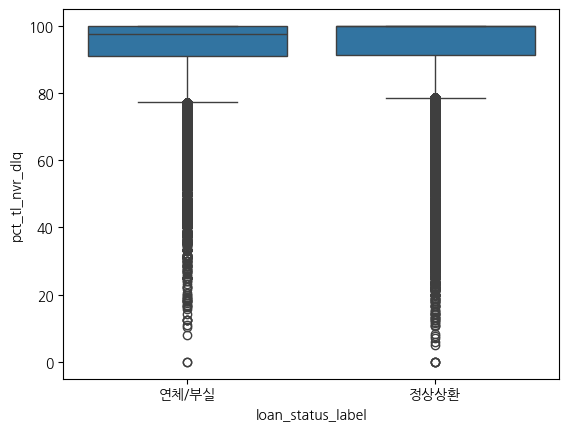

In [1354]:
sns.boxplot(df, x='loan_status_label', y = 'pct_tl_nvr_dlq')

In [1355]:
# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = df['pct_tl_nvr_dlq'].median()

# 결측값(NaN)을 중앙값으로 대체
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'].fillna(median_val)

In [1356]:
df = df.drop('last_credit_pull_d', axis=1) # 사후 변수

# mo_sin_old_rev_tl_op

In [1357]:
check(df, 'mo_sin_old_rev_tl_op')

count 1,033,382.00
mean 180.60  std 95.63
min 2.00
25% 116.00  50% 163.00  75% 230.00
max 909.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [277. 400. 130. 190. 206.  99.  89. 134.  30. 169. 196. 275. 286. 373.
 161. 151.  82. 192. 187. 116. 165. 214.  64. 492. 221. 456. 217. 345.
  93. 143. 163. 185. 274. 189.  39. 128.  35. 118. 166. 386. 183. 364.
 157. 249. 246. 259. 482.  91. 145. 191.  44.  69. 258. 149.  52. 115.
 175. 233.  36. 408. 300.  45. 341. 334. 110. 113.  94. 138. 122. 119.
 201. 164. 237.   7. 123. 159. 298. 319. 224. 202. 168.  nan  76.  37.
 133. 256.  87. 148.  77. 407.  80.  57. 181.  74. 174.  79.  40. 376.
 365. 127. 308.  34. 142. 194. 137. 154. 507. 140.  47. 252. 114.  95.
 278.  92. 331. 359. 162.  78. 121. 125. 318. 117.  75. 415.  56. 180.
 268. 204.  55. 131. 383. 158. 109.  96. 100. 332. 104. 283. 126.  51.
 135. 153. 317. 211. 296. 299.  62. 222. 170. 301. 302.  86.  98. 136.
 219.  81.  65. 405.  48. 129. 177. 150. 193. 198. 367.  24. 132. 218.
  84. 

In [1358]:
# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = df['mo_sin_old_rev_tl_op'].median()

# 결측값(NaN)을 중앙값으로 대체
df['mo_sin_old_rev_tl_op'] = df['mo_sin_old_rev_tl_op'].fillna(median_val)

<Axes: xlabel='loan_status_label', ylabel='mo_sin_old_rev_tl_op'>

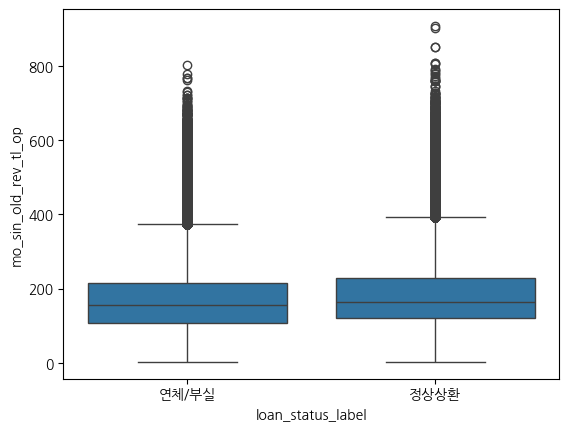

In [1359]:
sns.boxplot(df, x='loan_status_label', y='mo_sin_old_rev_tl_op')

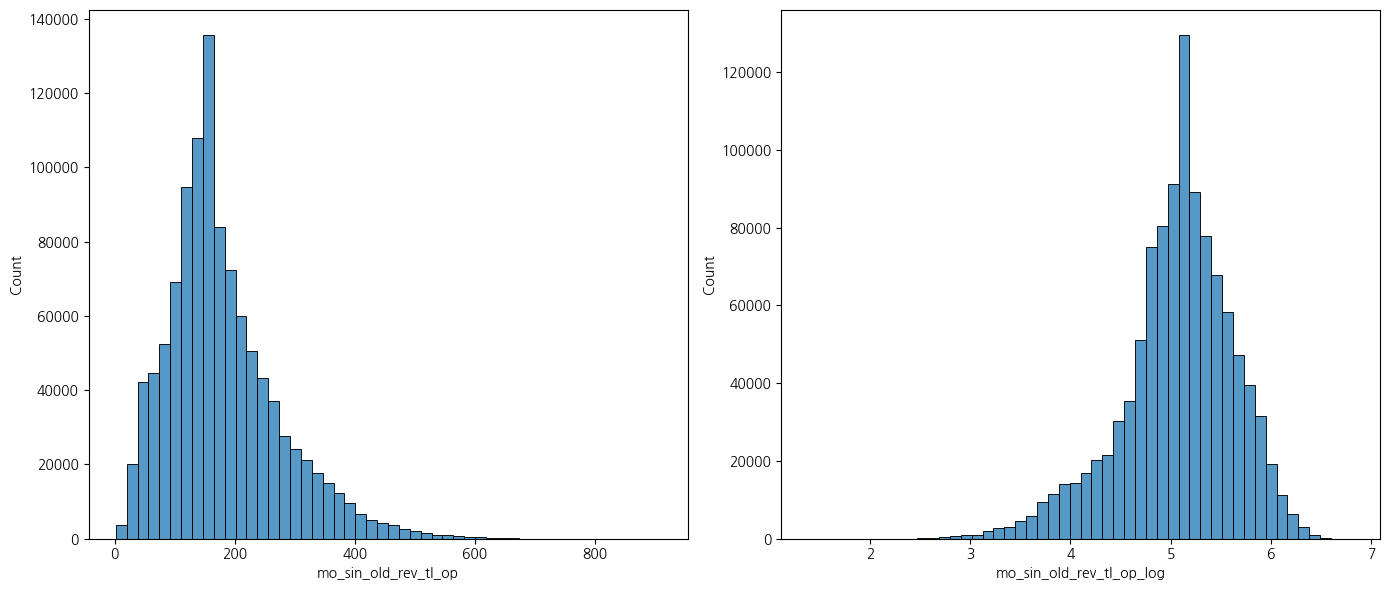

In [1360]:
temp = df.copy()
temp['mo_sin_old_rev_tl_op_log'] = np.log1p(1 + temp['mo_sin_old_rev_tl_op'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['mo_sin_old_rev_tl_op'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['mo_sin_old_rev_tl_op_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1361]:
df['mo_sin_old_rev_tl_op'] = np.log1p(1 + df['mo_sin_old_rev_tl_op'])  

# tot_hi_cred_lim

In [1362]:
check(df, 'tot_hi_cred_lim')

count 1,033,382.00
mean 175284.51  std 179504.39
min 200.00
25% 49902.00  50% 111673.00  75% 252895.00
max 9999999.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [650914. 196139. 211837. ... 258273. 281551. 359215.]
unique_num = 390804
type = float64


<Axes: xlabel='loan_status_label', ylabel='tot_hi_cred_lim'>

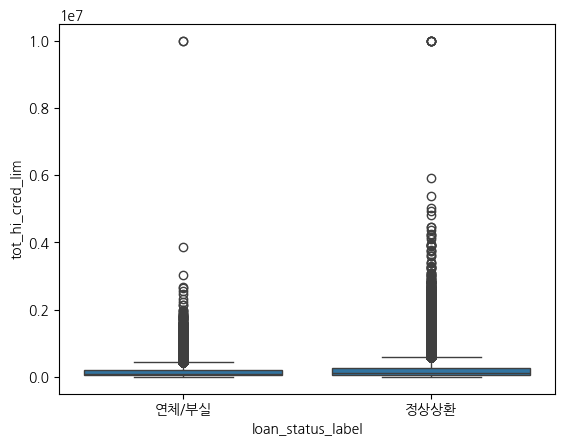

In [1363]:
sns.boxplot(df, x='loan_status_label', y='tot_hi_cred_lim')

In [1364]:
# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = df['tot_hi_cred_lim'].median()

# 결측값(NaN)을 중앙값으로 대체
df['tot_hi_cred_lim'] = df['tot_hi_cred_lim'].fillna(median_val)

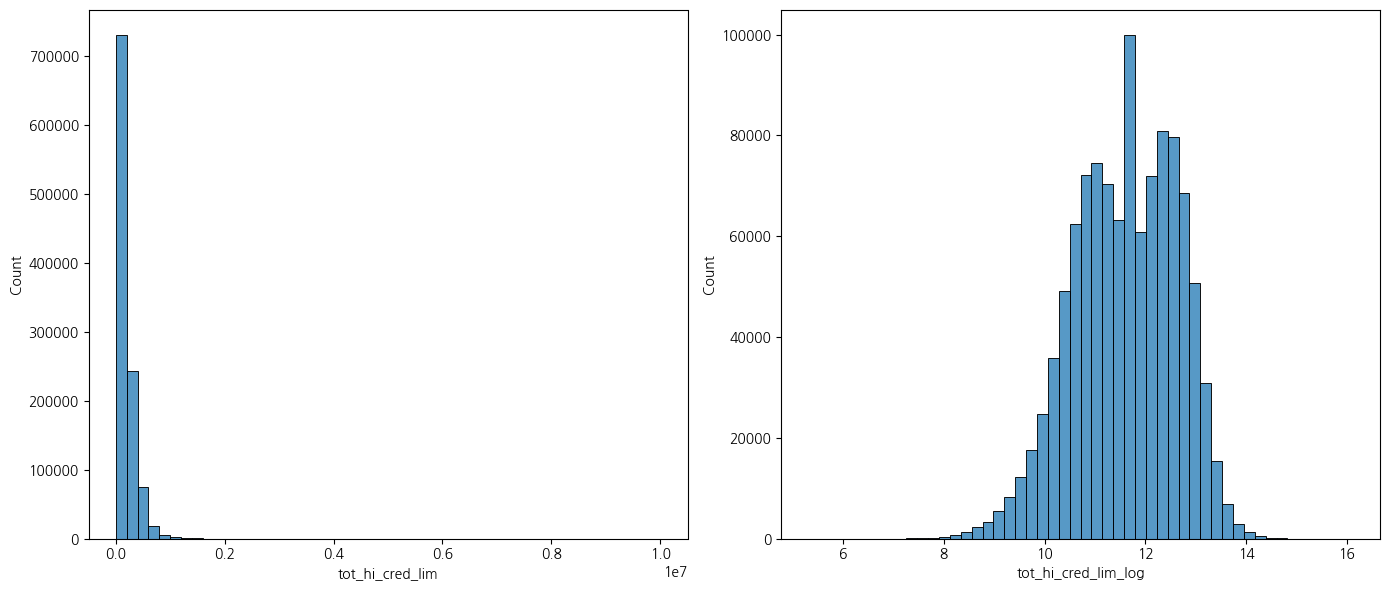

In [1365]:
temp = df.copy()
temp['tot_hi_cred_lim_log'] = np.log1p(1 + temp['tot_hi_cred_lim'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['tot_hi_cred_lim'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['tot_hi_cred_lim_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1366]:
df['tot_hi_cred_lim'] = np.log1p(1 + df['tot_hi_cred_lim']) 

# bc_util & bc_open_to_buy

(total_bc_limit - bc_open_to_buy) / total_bc_limit * 100

In [1367]:
df = df.merge(raw_df[['id', 'total_bc_limit']], on='id', how='left')

In [1368]:
df['bc_util'] = (df['total_bc_limit'] - df['bc_open_to_buy']) / df['total_bc_limit'] * 100

<Axes: xlabel='loan_status_label', ylabel='bc_util'>

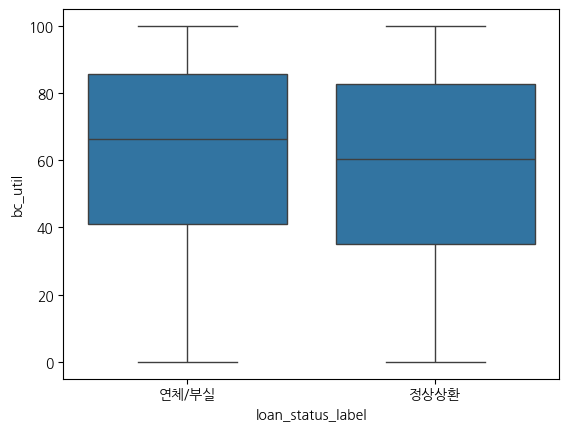

In [1369]:
sns.boxplot(df, x='loan_status_label', y='bc_util')

<Axes: xlabel='loan_status_label', ylabel='bc_open_to_buy'>

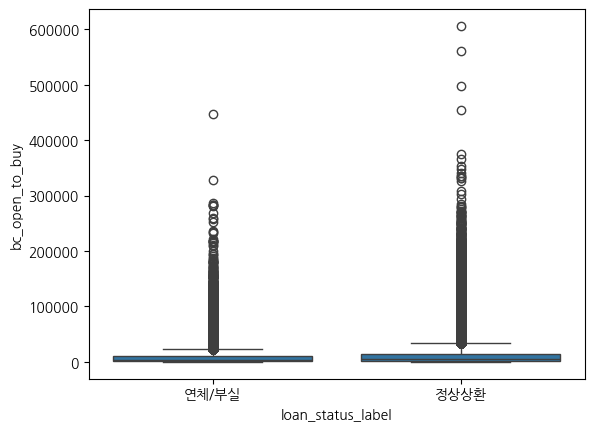

In [1370]:
sns.boxplot(df, x='loan_status_label', y='bc_open_to_buy')

In [1371]:
# “bc_util”과 “bc_open_to_buy”가 모두 NaN인 경우 “have_bc”를 0으로, 나머지는 1로 설정
df['have_bc'] = (~(df['bc_open_to_buy'].isna())).astype(int)

In [1372]:
mean_val = df['bc_util'].mean()

df['bc_util'] = df['bc_util'].fillna(mean_val)

In [1373]:
median_val = df['bc_open_to_buy'].median()

df['bc_open_to_buy'] = df['bc_open_to_buy'].fillna(median_val)

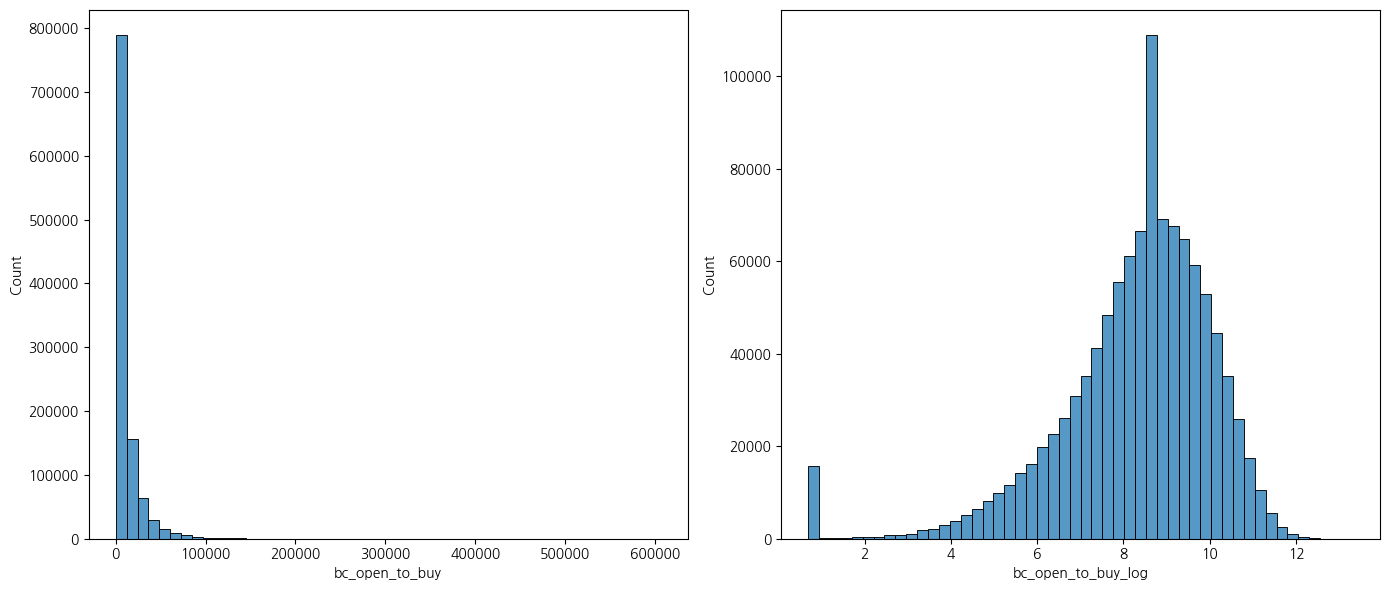

In [1374]:
temp = df.copy()
temp['bc_open_to_buy_log'] = np.log1p(1 + temp['bc_open_to_buy'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['bc_open_to_buy'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['bc_open_to_buy_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1375]:
df['bc_open_to_buy'] = np.log1p(1 + df['bc_open_to_buy'])  

# num_tl_op_past_12m

In [1376]:
check(df, 'num_tl_op_past_12m')

count 1,033,382.00
mean 2.16  std 1.85
min 0.00
25% 1.00  50% 2.00  75% 3.00
max 30.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [ 5.  1.  2.  4.  3.  0.  6.  9.  8.  7. nan 17. 10. 11. 12. 16. 14. 13.
 15. 21. 18. 25. 19. 30. 20. 23. 22. 26. 24. 29. 28.]
unique_num = 30
type = float64


In [1377]:
median_val = df['num_tl_op_past_12m'].median()

df['num_tl_op_past_12m'] = df['num_tl_op_past_12m'].fillna(median_val)

<Axes: xlabel='loan_status_label', ylabel='num_tl_op_past_12m'>

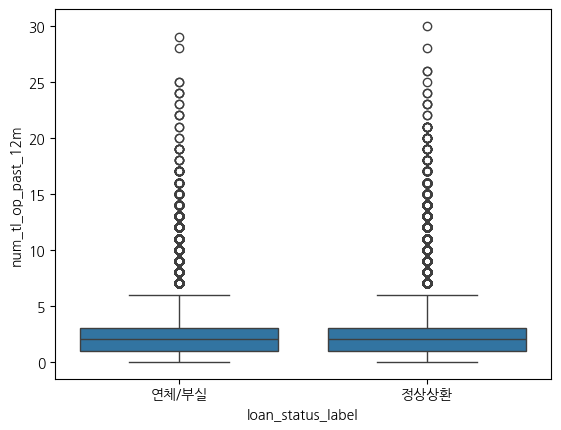

In [1378]:
sns.boxplot(df, x='loan_status_label', y='num_tl_op_past_12m')

# num_tl_90g_dpd_24m

In [1379]:
check(df, 'num_tl_90g_dpd_24m')

count 1,033,382.00
mean 0.09  std 0.50
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 42.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [ 0.  2.  1.  6. 16. nan  3.  5. 12.  8. 15. 14.  4.  7. 11. 10. 30. 13.
  9. 20. 36. 19. 17. 18. 25. 42. 29. 26. 22. 24. 21.]
unique_num = 30
type = float64


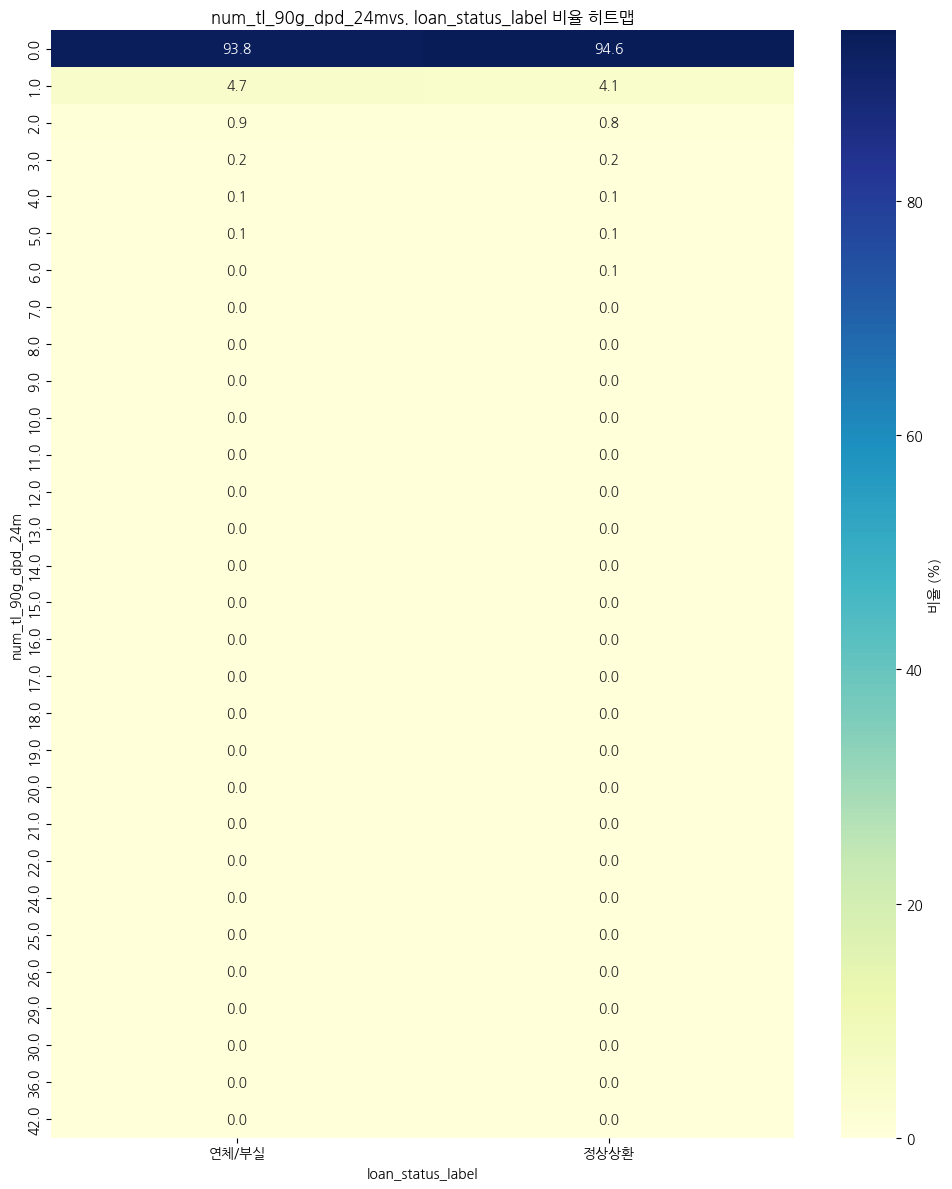

In [1380]:
# 1) mo_sin_old_il_acct별 loan_status_label 비율 집계 (열 기준 정규화)
pivot_pct = pd.crosstab(
    df['num_tl_90g_dpd_24m'],
    df['loan_status_label'],
    normalize='columns'
) * 100

pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_tl_90g_dpd_24mvs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_tl_90g_dpd_24m')
plt.tight_layout()
plt.show()

In [1381]:
df['num_tl_90g_dpd_24m'] = df['num_tl_90g_dpd_24m'].fillna(0)

In [1382]:
df['num_tl_90g_dpd_24m'] = (df['num_tl_90g_dpd_24m'] > 0).astype(int)

# num_rev_accts & num_op_rev_tl

In [1383]:
check(df, 'num_rev_accts')
check(df, 'num_op_rev_tl')

count 1,033,381.00
mean 14.33  std 8.12
min 1.00
25% 8.00  50% 13.00  75% 18.00
max 121.00

nan_num = 42017
nan_ratio = 3.91 %
unique = [ 22.  18.   6.  26.  20.  21.  10.  11.  14.  17.  13.  28.  16.   8.
  12.   5.  15.  24.  47.  25.   4.  45.   3.   7.  23.  33.   9.  37.
  19.  32.  nan  38.  41.  27.  35.  71.  42.  36.  30.   2.  31.  29.
  39.  44.  40.  53.  49.  51.  34.  73.  54.  43.  62.  50.  46.  61.
  56.  63.  48.  52.  55.  57.  60.  77.  69.  65.  58.  68.  99.  67.
  72.  59.  96.  64.   1.  76.  90.  74.  75.  66.  70. 107. 105. 100.
  81.  92.  78.  82.  80.  84.  98.  86. 104. 121.  79. 101.  83.  94.
 103. 117. 113. 102.  87.  89.  85. 112.  93.]
unique_num = 106
type = float64
count 1,033,382.00
mean 8.28  std 4.63
min 0.00
25% 5.00  50% 7.00  75% 11.00
max 83.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [12. 15.  4. 14.  9. 18.  7.  8. 11. 13.  6. 24. 20.  3.  1.  2.  5. 33.
 16. 10. 21. 17. nan 28. 27. 19. 23. 31. 29. 25. 22. 26. 32. 44. 36. 30.
 37. 35. 

In [1384]:
df['num_rev_accts'] = df['num_rev_accts'].fillna(0)
df['num_op_rev_tl'] = df['num_op_rev_tl'].fillna(0)

<Axes: xlabel='loan_status_label', ylabel='num_rev_accts'>

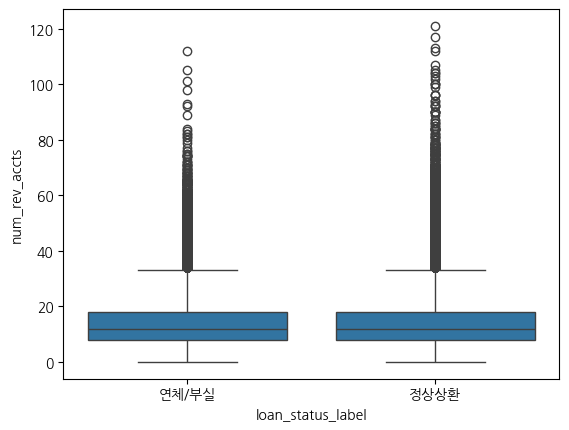

In [1385]:
sns.boxplot(df, x='loan_status_label', y='num_rev_accts')

<Axes: xlabel='loan_status_label', ylabel='num_op_rev_tl'>

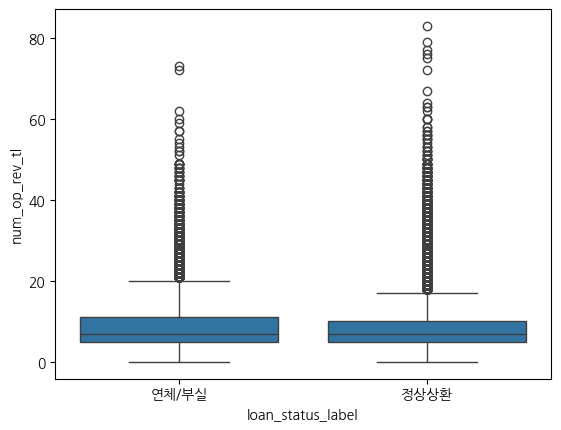

In [1386]:
sns.boxplot(df, x='loan_status_label', y='num_op_rev_tl')

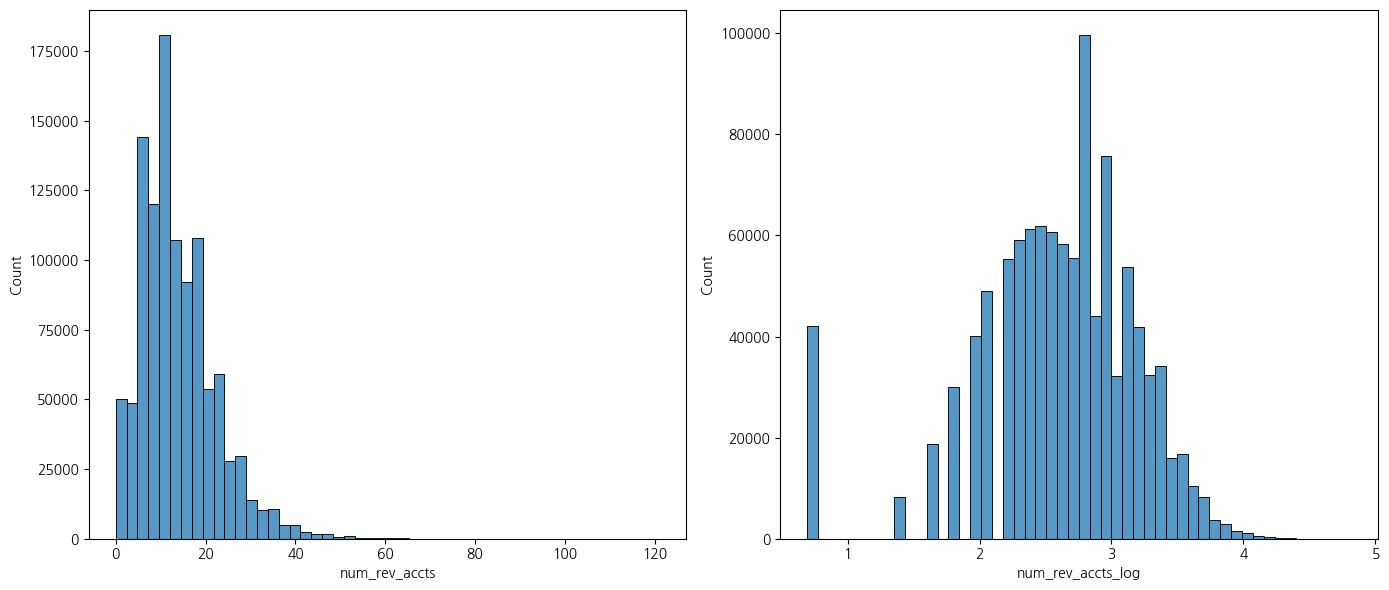

In [1387]:
temp = df.copy()
temp['num_rev_accts_log'] = np.log1p(1 + temp['num_rev_accts'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['num_rev_accts'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['num_rev_accts_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

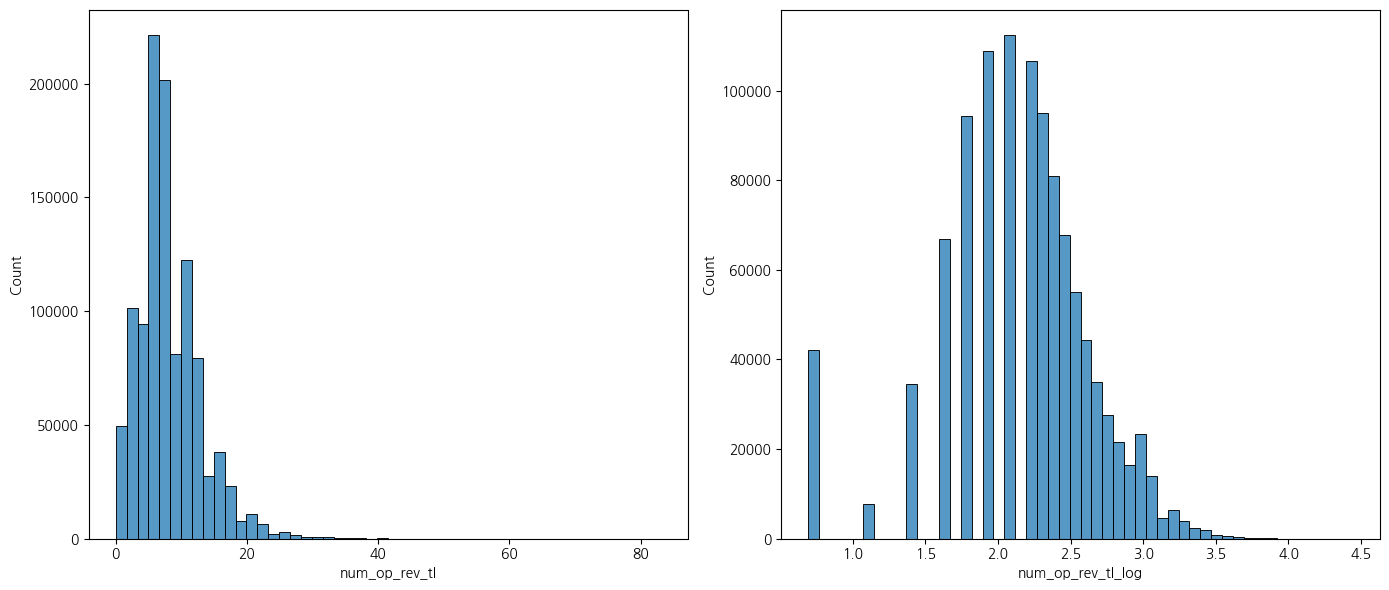

In [1388]:
temp = df.copy()
temp['num_op_rev_tl_log'] = np.log1p(1 + temp['num_op_rev_tl'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['num_op_rev_tl'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['num_op_rev_tl_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1389]:
df['num_rev_accts'] = np.log1p(1 + df['num_rev_accts'])  
df['num_op_rev_tl'] = np.log1p(1 + df['num_op_rev_tl'])  

# mo_sin_rcnt_rev_tl_op & mo_sin_rcnt_tl

In [1390]:
check(df, 'mo_sin_rcnt_rev_tl_op')
check(df, 'mo_sin_rcnt_tl')

count 1,033,382.00
mean 13.40  std 16.67
min 0.00
25% 4.00  50% 8.00  75% 16.00
max 438.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [  6.  14.  13.   5.   7.   8.  34.  21.  29.   3.  18.   4.  27.  10.
   9.   0.  16.  12.  62.  24.  28.  42.  15.  35.   2.   1.  17.  11.
  50.  nan  36.  30.  33.  20.  56.  23.  38.  19.  32.  22.  31.  69.
  52.  60.  26.  37.  61.  82.  67.  53.  39.  71.  46.  57.  80.  47.
  48.  25.  65. 100.  64. 114.  55.  41.  43.  79.  81. 126.  75.  84.
  40.  44. 165.  59.  74.  78.  77.  54.  93.  70.  49. 140.  87.  45.
  89. 123.  66. 192.  85.  92.  76.  58.  51.  83.  72.  63.  95. 102.
 119. 134.  68. 105. 116.  97. 101.  91.  94. 108.  96.  73. 113.  86.
  99. 120.  90. 127. 197. 109. 111. 141. 106. 121. 107. 220.  88.  98.
 178. 133. 190. 110. 118. 103. 115. 122. 170. 117. 157. 125. 104. 138.
 112. 135. 169. 206. 187. 131. 137. 129. 124. 181. 144. 153. 151. 147.
 202. 162. 128. 142. 143. 186. 155. 154. 136. 146. 156. 173. 159. 166.
 161. 207. 1

In [1391]:
# 1) “mo_sin_rcnt_rev_tl_op”과 “mo_sin_rcnt_tl” 모두 NaN인 행 마스크
mask_no_rev = df['mo_sin_rcnt_rev_tl_op'].isna() & df['mo_sin_rcnt_tl'].isna()

# 2) have_rev 컬럼 생성: 리볼빙 계좌 정보 없으면 0, 아니면 1
df['have_rev'] = (~mask_no_rev).astype(int)

# 3) 중앙값 계산 (리볼빙 계좌가 있는 경우만)
medians = {
    col: df.loc[~mask_no_rev, col].median()
    for col in ['mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']
}

# 4) NaN인 행(=mask_no_rev)에 중앙값으로 대체
for col, med in medians.items():
    df.loc[mask_no_rev, col] = med

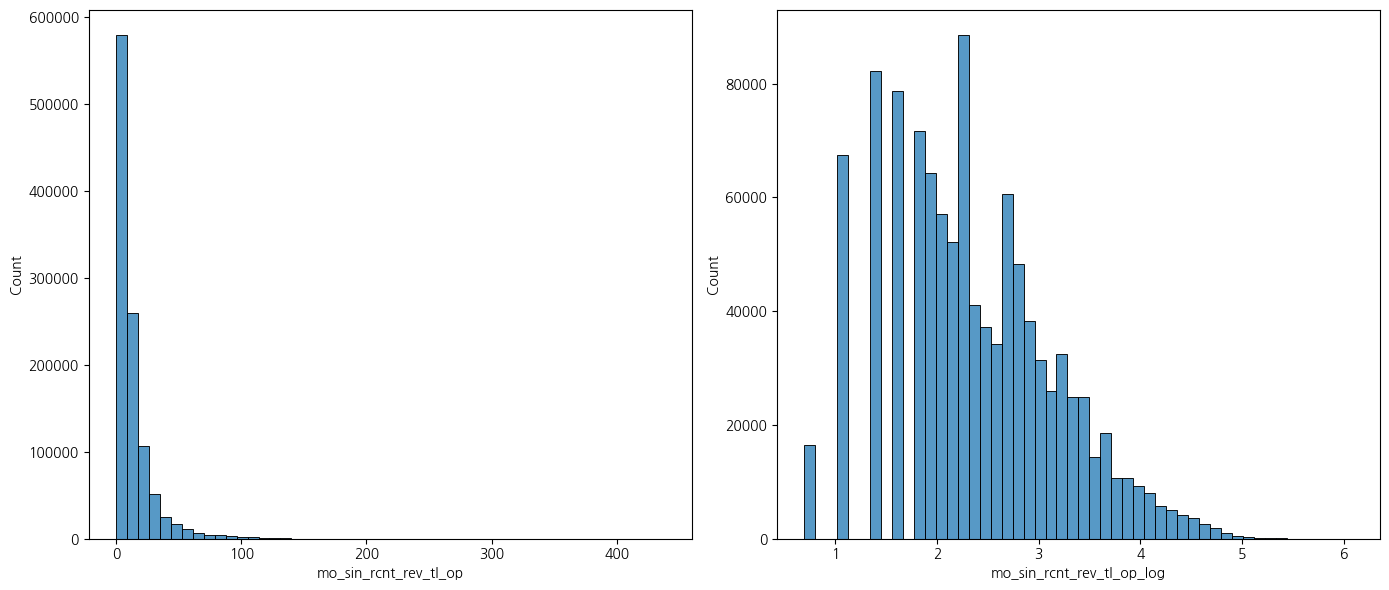

In [1392]:
temp = df.copy()
temp['mo_sin_rcnt_rev_tl_op_log'] = np.log1p(1 + temp['mo_sin_rcnt_rev_tl_op'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['mo_sin_rcnt_rev_tl_op'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['mo_sin_rcnt_rev_tl_op_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

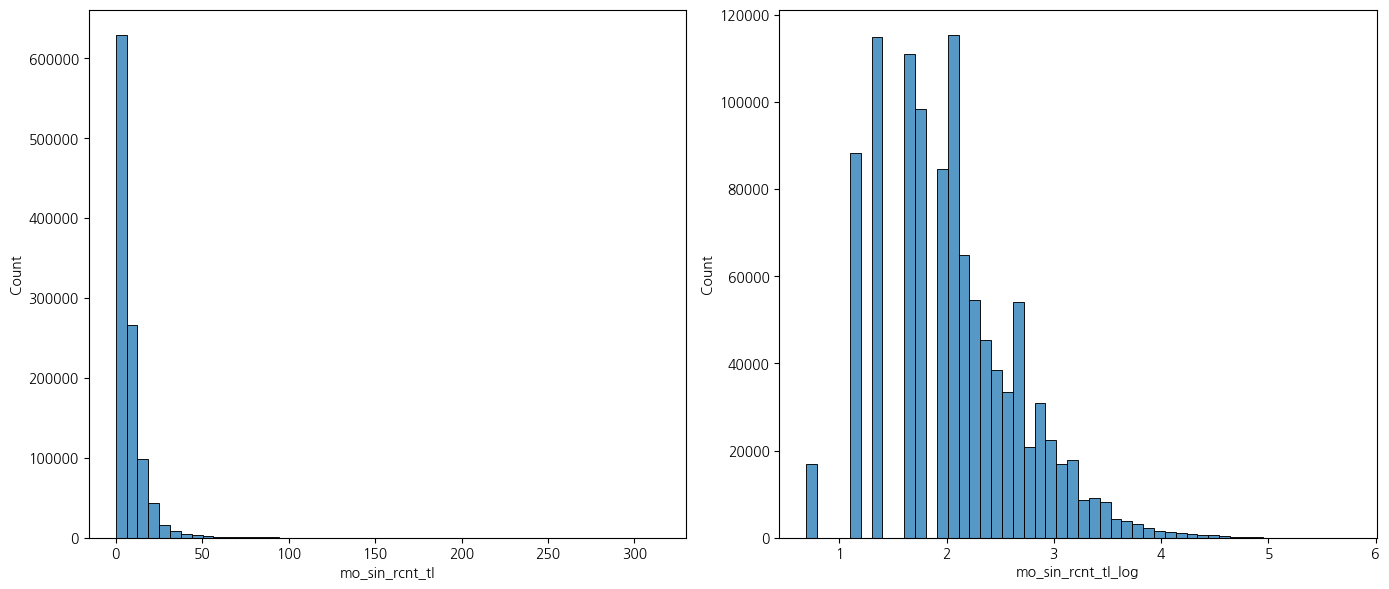

In [1393]:
temp = df.copy()
temp['mo_sin_rcnt_tl_log'] = np.log1p(1 + temp['mo_sin_rcnt_tl'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['mo_sin_rcnt_tl'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['mo_sin_rcnt_tl_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1394]:
df['mo_sin_rcnt_rev_tl_op'] = np.log1p(1 + df['mo_sin_rcnt_rev_tl_op']) 
df['mo_sin_rcnt_tl'] = np.log1p(1 + df['mo_sin_rcnt_tl'])   

# num_actv_rev_tl

In [1395]:
check(df, 'num_actv_rev_tl')

count 1,033,382.00
mean 5.63  std 3.34
min 0.00
25% 3.00  50% 5.00  75% 7.00
max 72.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [10.  6.  3. 13.  5.  7.  4.  8.  9. 20.  2. 14.  1. 11. 27. 17. 12. 18.
 nan  0. 19. 23. 16. 15. 21. 24. 22. 25. 29. 33. 34. 28. 36. 26. 30. 31.
 41. 35. 72. 32. 44. 43. 37. 38. 59. 39. 47. 57. 42. 58. 40. 45. 46. 51.
 54.]
unique_num = 54
type = float64


In [1396]:
df['num_actv_rev_tl'] = df['num_actv_rev_tl'].fillna(0)

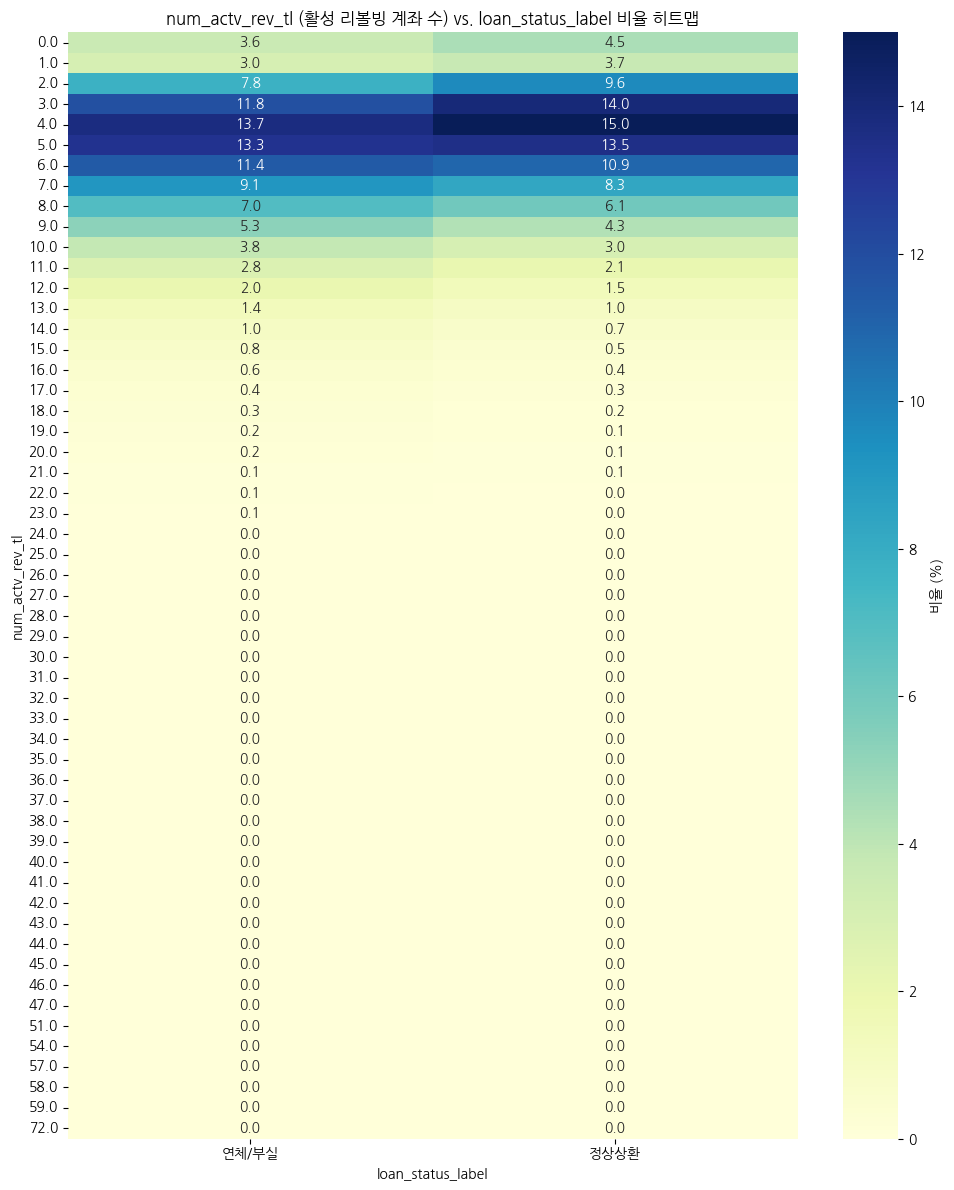

In [1397]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_actv_rev_tl'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_actv_rev_tl (활성 리볼빙 계좌 수) vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_actv_rev_tl')
plt.tight_layout()
plt.show()

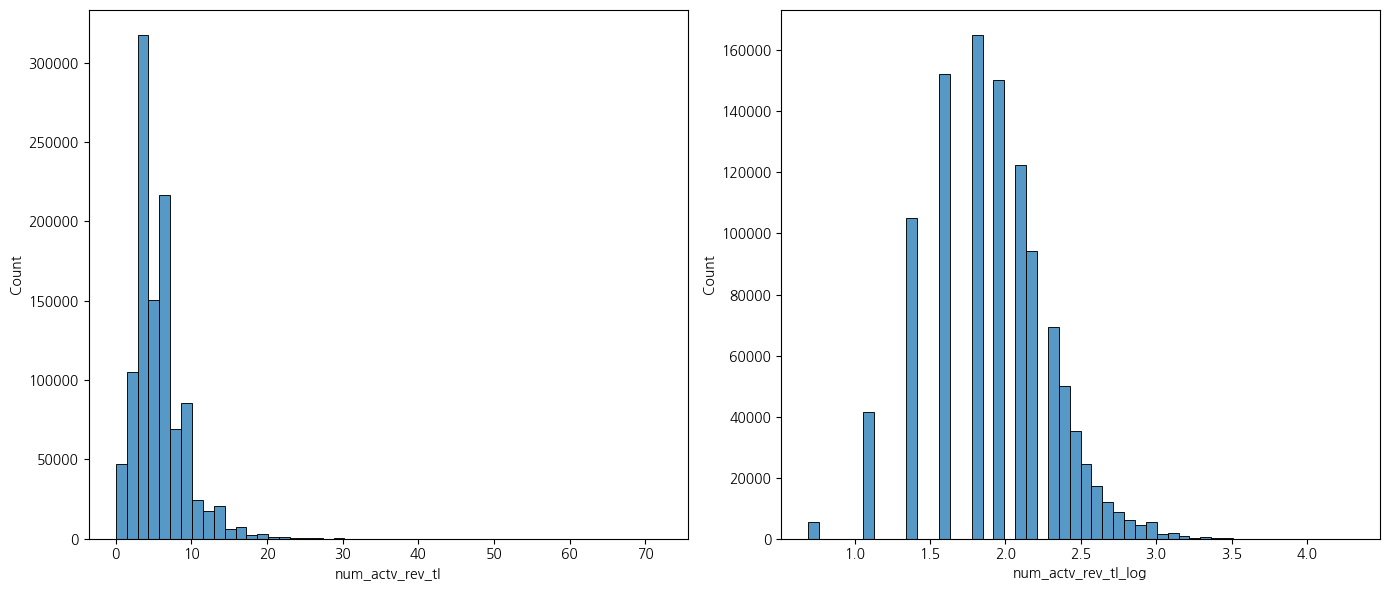

In [1398]:
temp = raw_df.copy()
temp['num_actv_rev_tl_log'] = np.log1p(1 + temp['num_actv_rev_tl'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['num_actv_rev_tl'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['num_actv_rev_tl_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1399]:
# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = df['num_actv_rev_tl'].quantile(0.99)

# 2) 그 값으로 상한(capping) 적용
df['num_actv_rev_tl'] = df['num_actv_rev_tl'].clip(upper=q99)

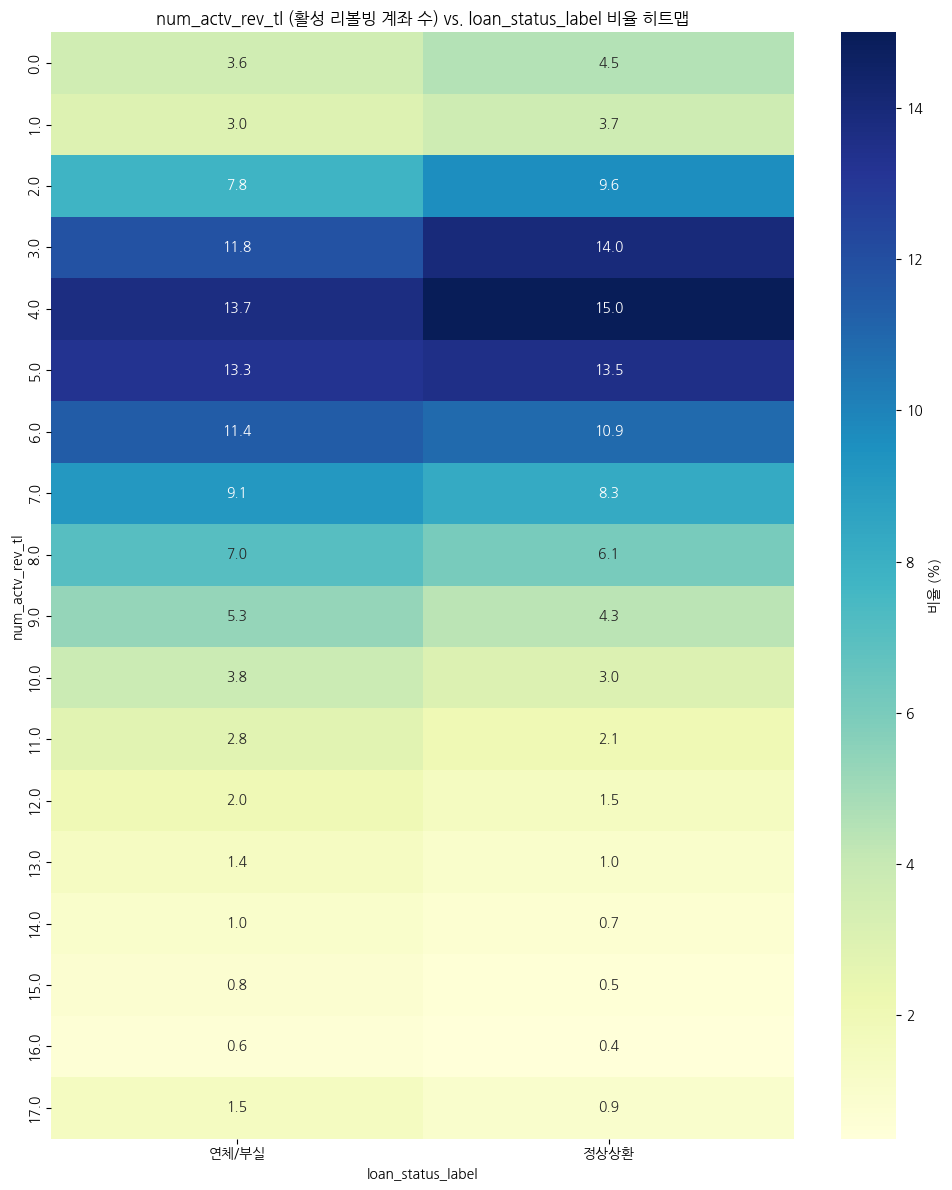

In [1400]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_actv_rev_tl'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_actv_rev_tl (활성 리볼빙 계좌 수) vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_actv_rev_tl')
plt.tight_layout()
plt.show()

# num_bc_tl

In [1401]:
check(df, 'num_bc_tl')

count 1,033,382.00
mean 7.93  std 4.76
min 0.00
25% 5.00  50% 7.00  75% 10.00
max 89.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [14.  9.  4. 11. 12.  7.  5.  8. 15. 10.  6. 18.  3. 19. 16. 26.  1. 13.
 31. 17.  2. nan 24. 25. 20. 23. 36. 21. 28. 29.  0. 22. 27. 37. 32. 33.
 38. 34. 30. 42. 35. 40. 43. 46. 45. 41. 53. 47. 44. 39. 59. 50. 48. 54.
 66. 55. 70. 65. 51. 49. 61. 60. 57. 52. 58. 56. 89. 85.]
unique_num = 67
type = float64


In [1402]:
df['num_bc_tl'] = df['num_bc_tl'].fillna(0)

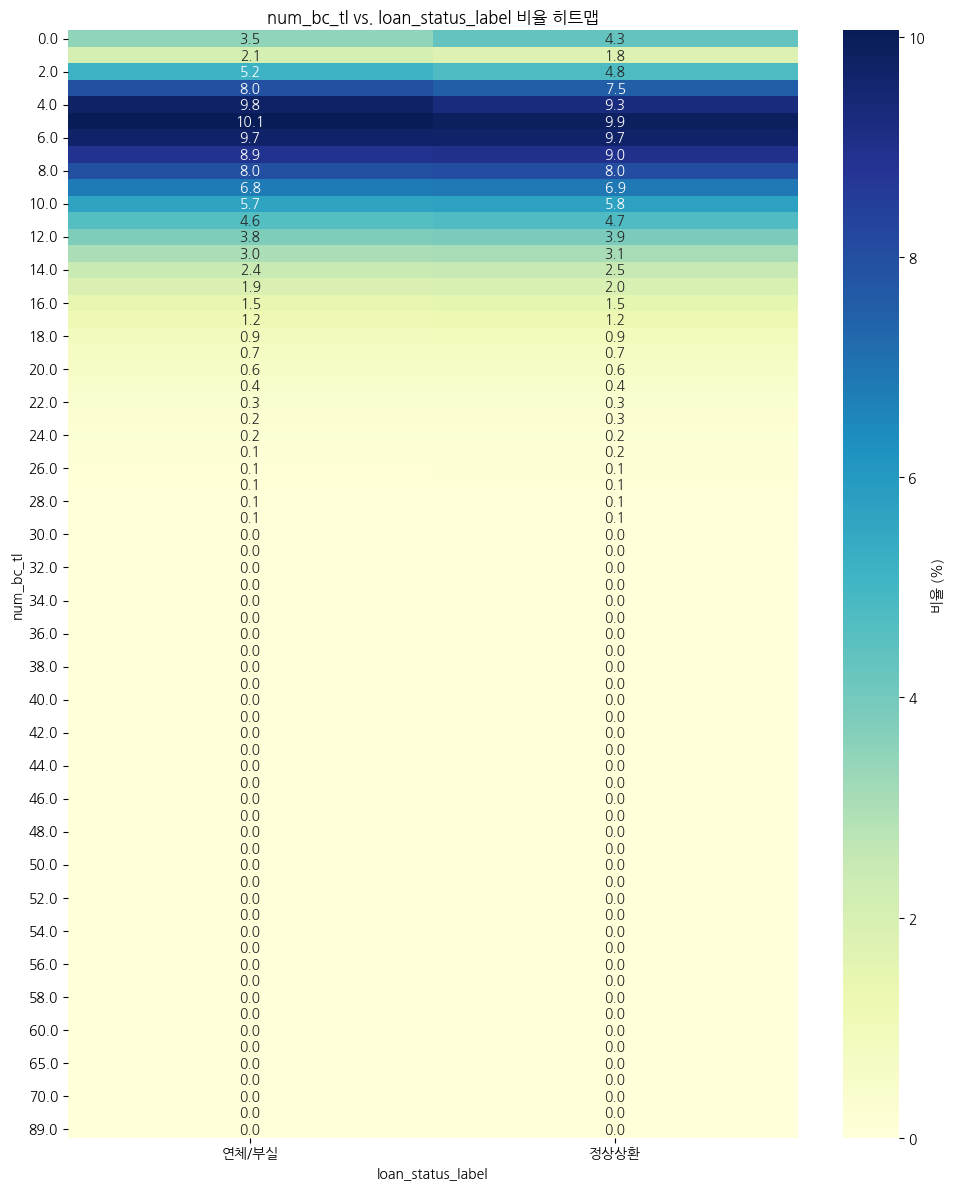

In [1403]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_bc_tl'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_bc_tl vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_bc_tl')
plt.tight_layout()
plt.show()

In [1404]:
# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = df['num_bc_tl'].quantile(0.99)

# 2) 그 값으로 상한(capping) 적용
df['num_bc_tl'] = df['num_bc_tl'].clip(upper=q99)

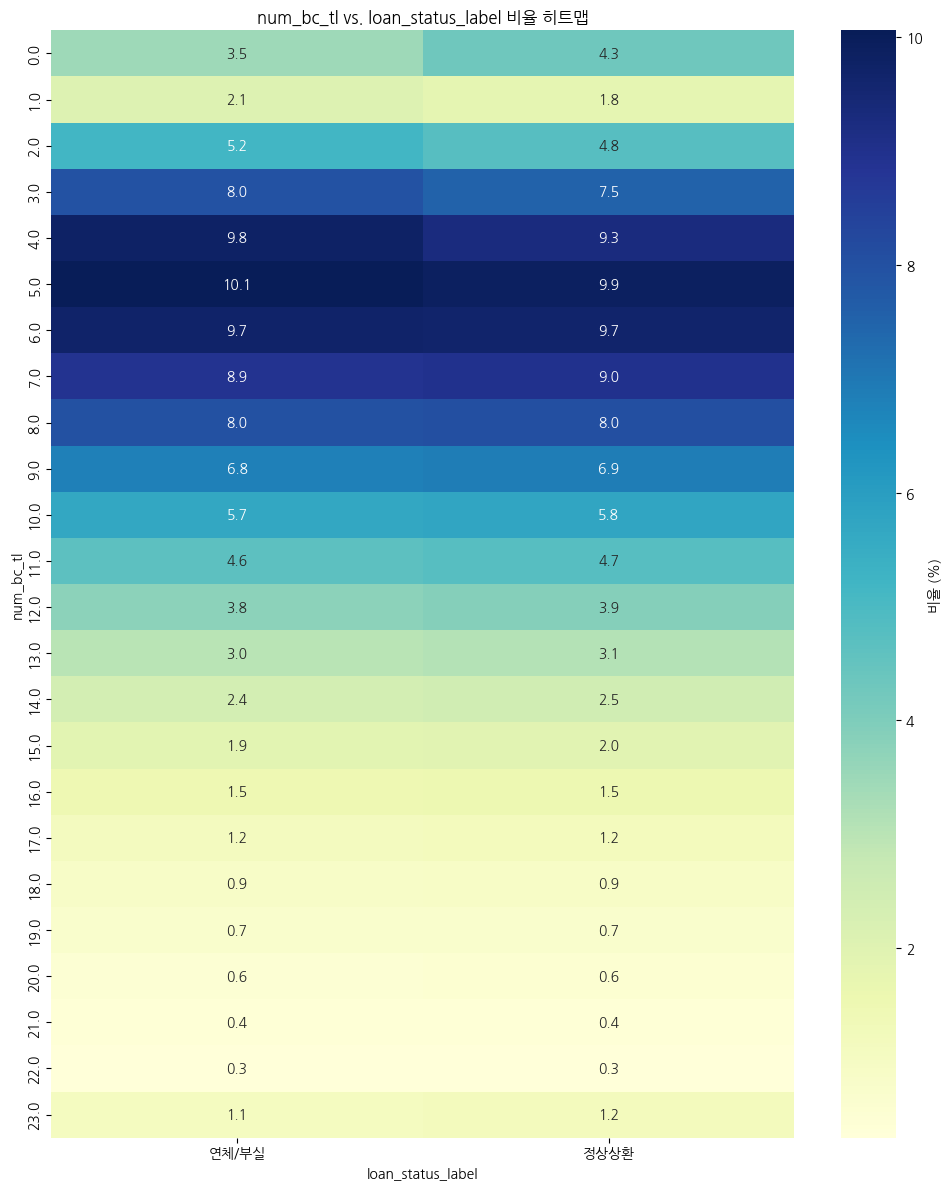

In [1405]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_bc_tl'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_bc_tl vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_bc_tl')
plt.tight_layout()
plt.show()

# num_il_tl

In [1406]:
check(df, 'num_il_tl')

count 1,033,382.00
mean 8.56  std 7.41
min 0.00
25% 3.00  50% 7.00  75% 11.00
max 138.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [ 36.   7.   2.  13.   4.   1.   5.   6.   3.   9.  20.   8.  10.  33.
  16.  24.  31.  28.  11.  12.  23.  15.  22.  17.  21.  14.  nan  19.
  26.  18.  45.  27.   0.  35.  25.  47.  32.  37.  30.  60.  43.  54.
  74.  29.  55.  34.  40.  46.  50.  38.  39.  44.  42.  48.  57.  89.
  41.  53.  51.  61.  75.  83.  49.  65.  52. 104.  58.  66.  67.  80.
  59.  64.  56.  72.  62. 128.  63.  71.  97.  84.  81.  91.  69. 113.
  77.  86.  82.  85.  76.  73.  70.  68.  79.  78. 138.  87.  95. 101.
  90. 107.  88. 117.  94. 102. 131. 118. 103.  98.  96.  93.  99. 130.]
unique_num = 111
type = float64


In [1407]:
df['num_il_tl'] = df['num_il_tl'].fillna(0)

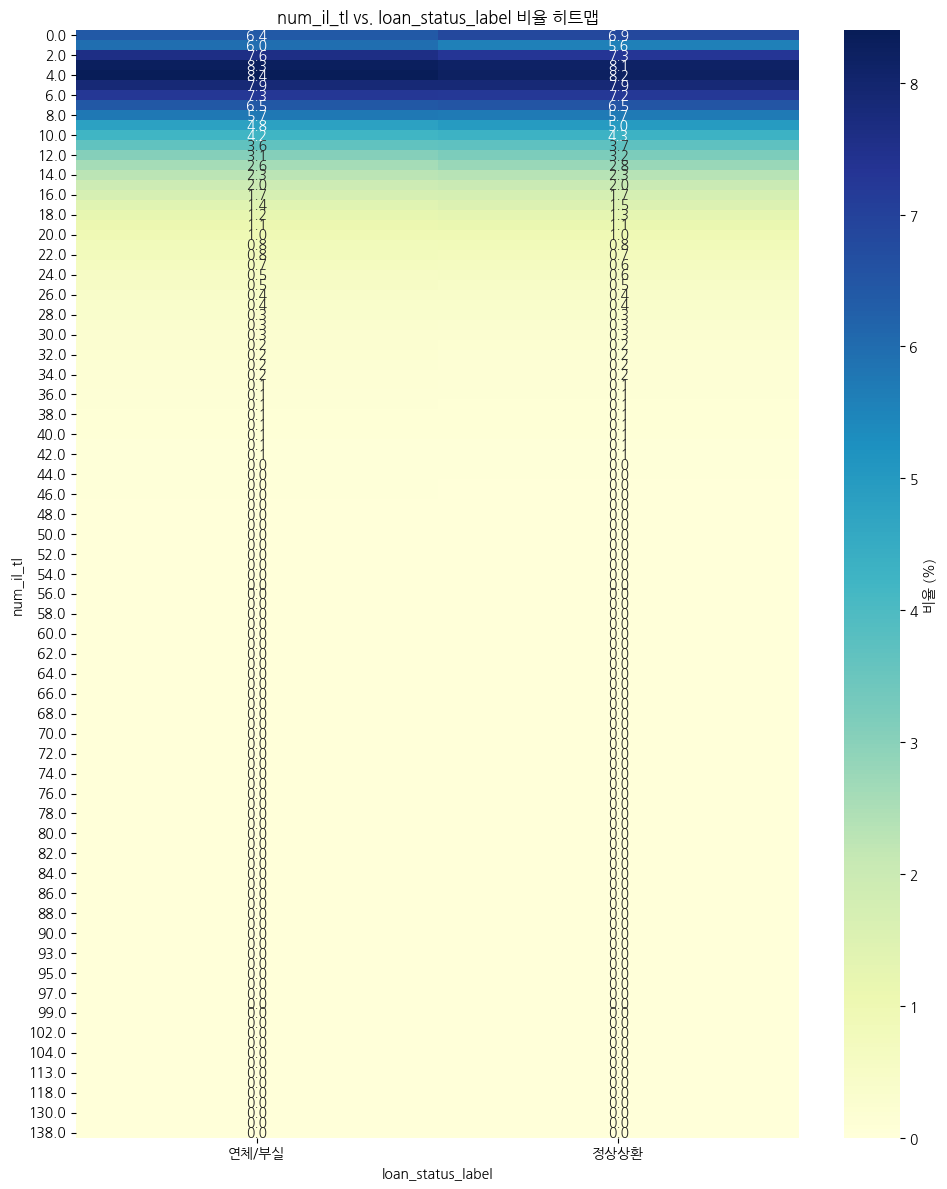

In [1408]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_il_tl'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_il_tl vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_il_tl')
plt.tight_layout()
plt.show()

In [1409]:
# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = df['num_il_tl'].quantile(0.99)

# 2) 그 값으로 상한(capping) 적용
df['num_il_tl'] = df['num_il_tl'].clip(upper=q99)

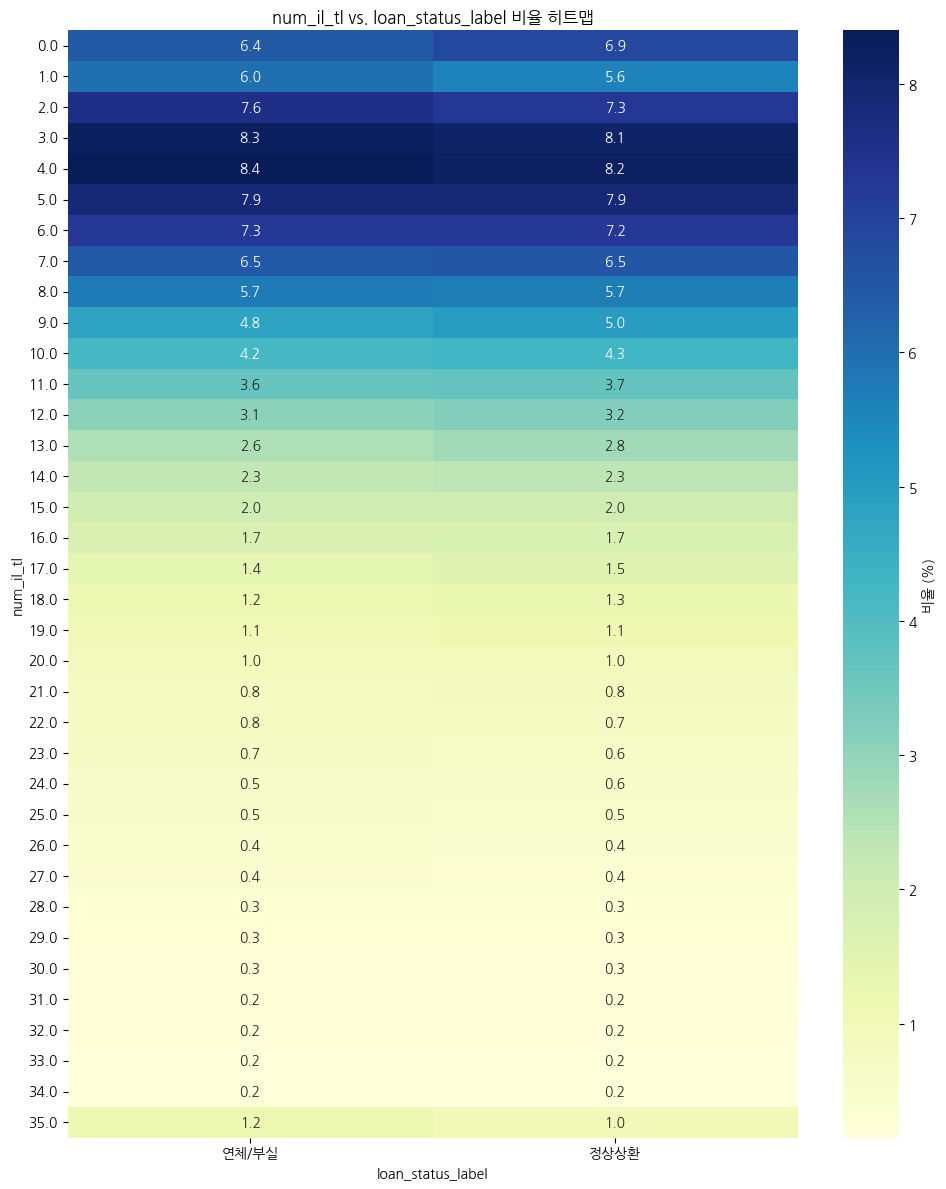

In [1410]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_il_tl'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_il_tl vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_il_tl')
plt.tight_layout()
plt.show()

# num_bc_sats

In [1411]:
check(df, 'num_bc_sats')

count 1,040,352.00
mean 4.77  std 3.01
min 0.00
25% 3.00  50% 4.00  75% 6.00
max 63.00

nan_num = 35046
nan_ratio = 3.26 %
unique = [ 8.  3.  5.  4. 11.  6.  9.  7. 12.  1.  2. 10. 21. 13. 16. nan 17.  0.
 15. 23. 14. 22. 19. 18. 20. 27. 33. 25. 35. 26. 30. 34. 40. 24. 29. 28.
 32. 37. 59. 31. 38. 36. 42. 63. 46. 54. 44. 43. 53. 45. 39. 48. 49. 55.]
unique_num = 53
type = float64


<Axes: xlabel='loan_status_label', ylabel='num_bc_sats'>

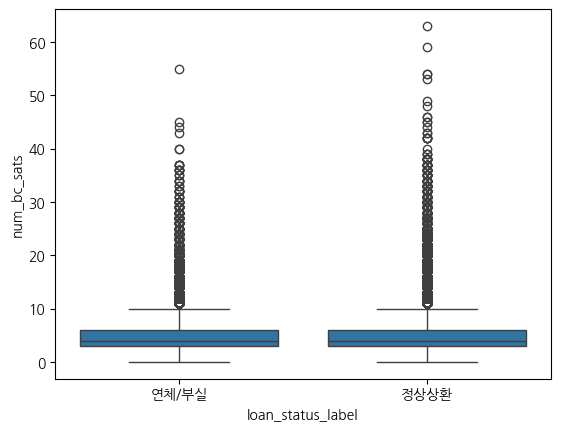

In [1412]:
sns.boxplot(df, x='loan_status_label', y='num_bc_sats')

In [1413]:
# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = df['num_bc_sats'].median()

# 결측값(NaN)을 중앙값으로 대체
df['num_bc_sats'] = df['num_bc_sats'].fillna(median_val)

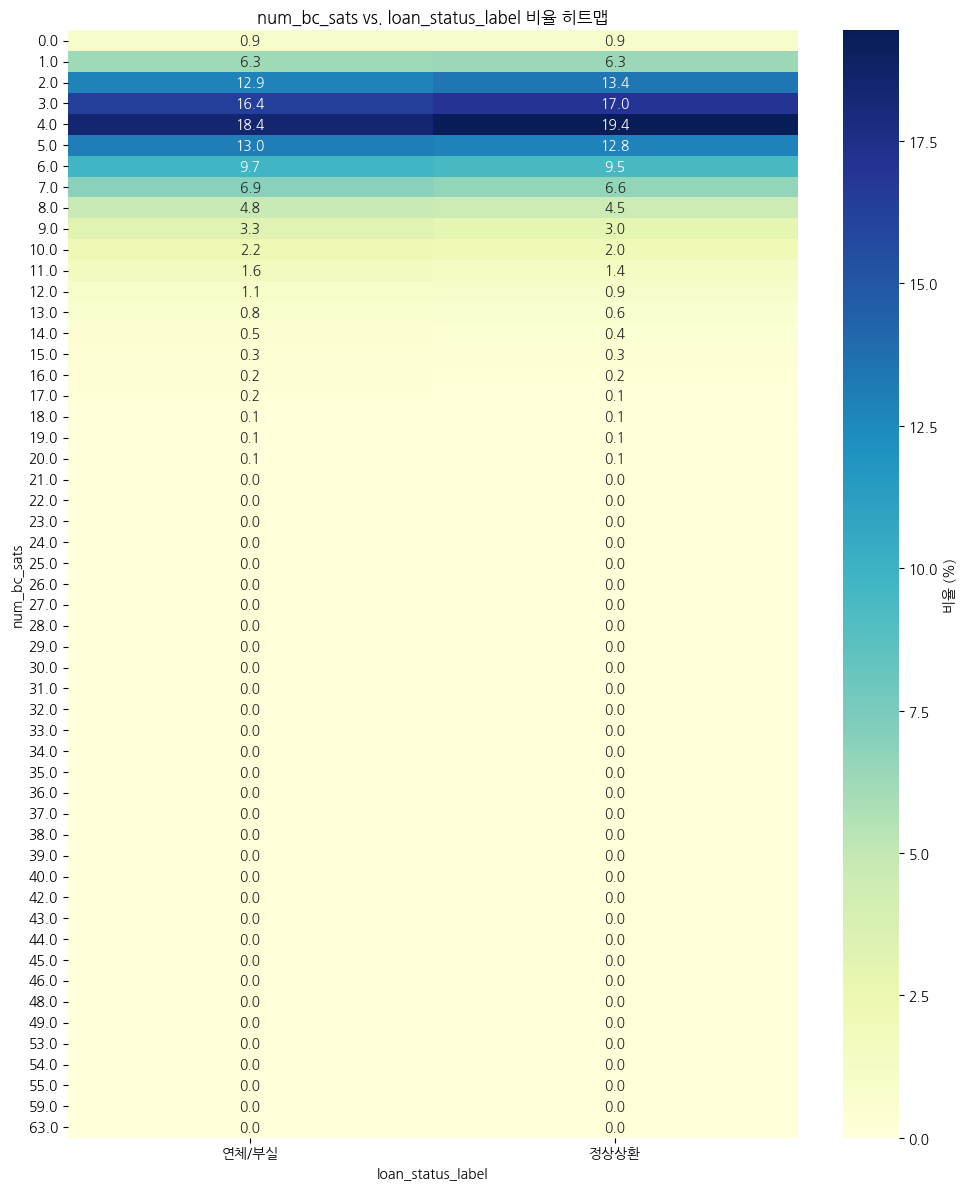

In [1414]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_bc_sats'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_bc_sats vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_bc_sats')
plt.tight_layout()
plt.show()

In [1415]:
# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = df['num_bc_sats'].quantile(0.99)

# 2) 그 값으로 상한(capping) 적용
df['num_bc_sats'] = df['num_bc_sats'].clip(upper=q99)

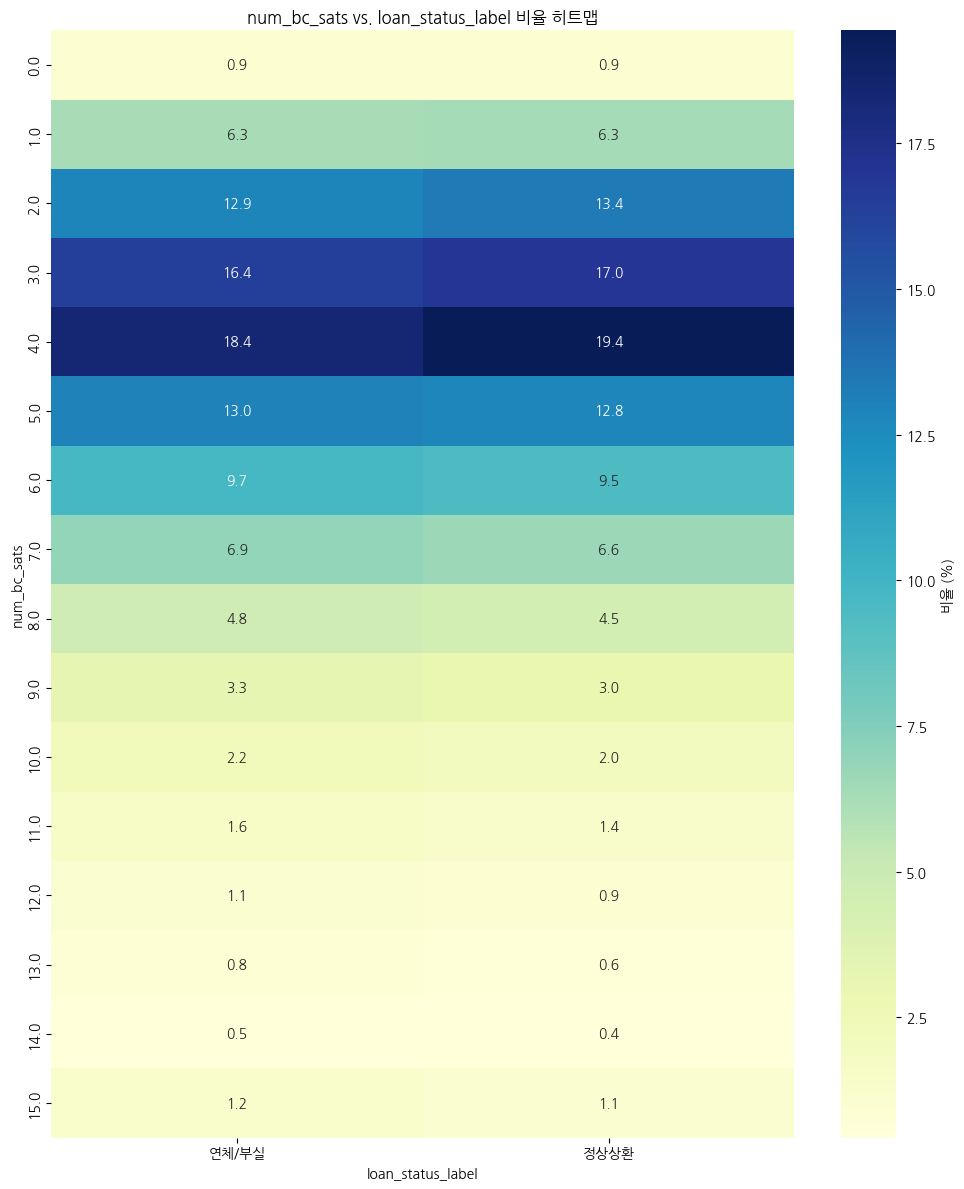

In [1416]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_bc_sats'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_bc_sats vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_bc_sats')
plt.tight_layout()
plt.show()

# num_actv_bc_tl

In [1417]:
check(df, 'num_actv_bc_tl')

count 1,033,382.00
mean 3.66  std 2.28
min 0.00
25% 2.00  50% 3.00  75% 5.00
max 50.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [ 8.  6.  3.  5.  2.  1.  4. 11.  7. 19.  0.  9. nan 12. 15. 14. 16. 10.
 13. 17. 20. 29. 18. 21. 24. 22. 27. 23. 50. 32. 25. 28. 46. 26. 30. 35.
 33. 45.]
unique_num = 37
type = float64


In [1418]:
# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = df['num_actv_bc_tl'].median()

# 결측값(NaN)을 중앙값으로 대체
df['num_actv_bc_tl'] = df['num_actv_bc_tl'].fillna(median_val)

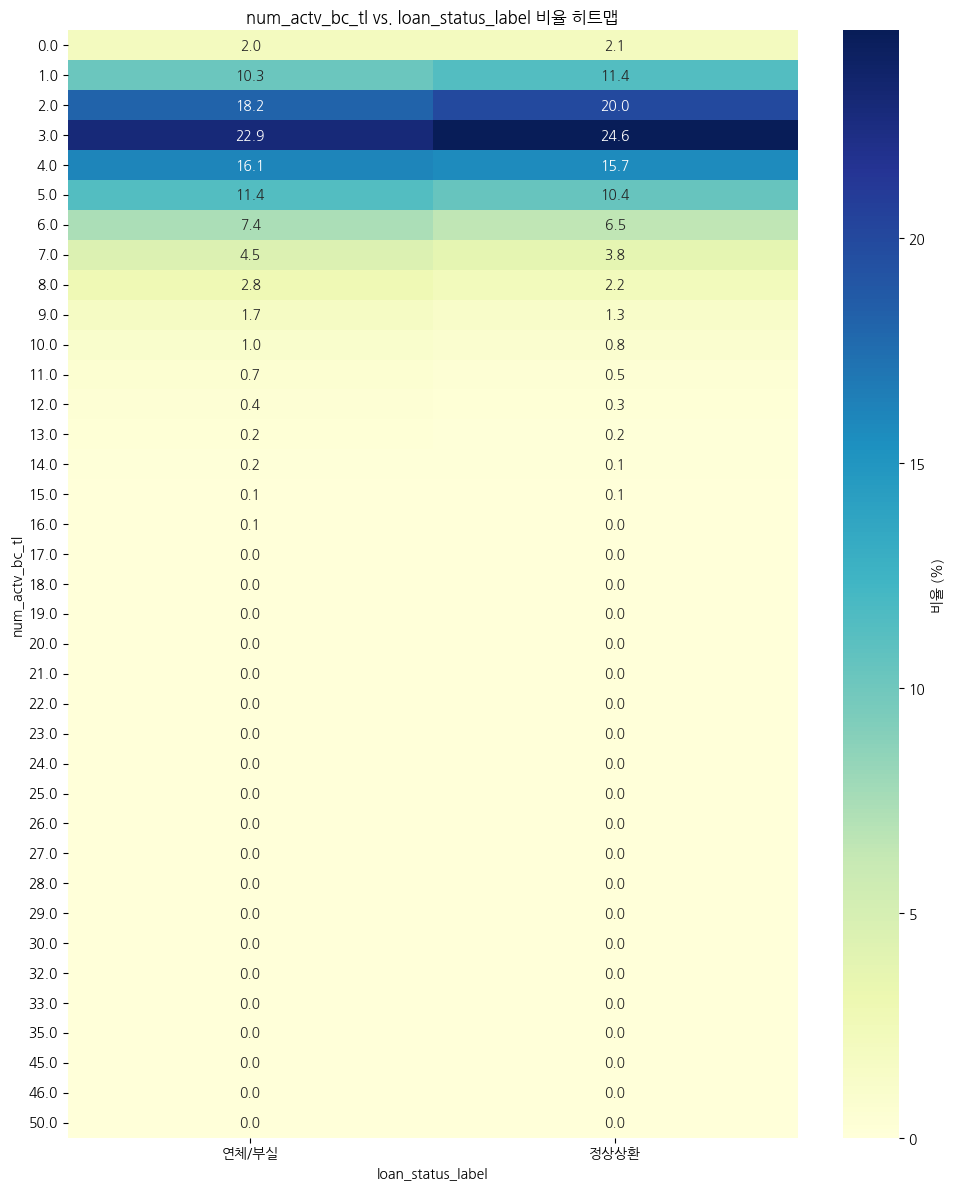

In [1419]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_actv_bc_tl'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_actv_bc_tl vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_actv_bc_tl')
plt.tight_layout()
plt.show()

In [1420]:
# 1) 99번째 백분위수(상위 1%) 값 계산
q99 = df['num_actv_bc_tl'].quantile(0.99)

# 2) 그 값으로 상한(capping) 적용
df['num_actv_bc_tl'] = df['num_actv_bc_tl'].clip(upper=q99)

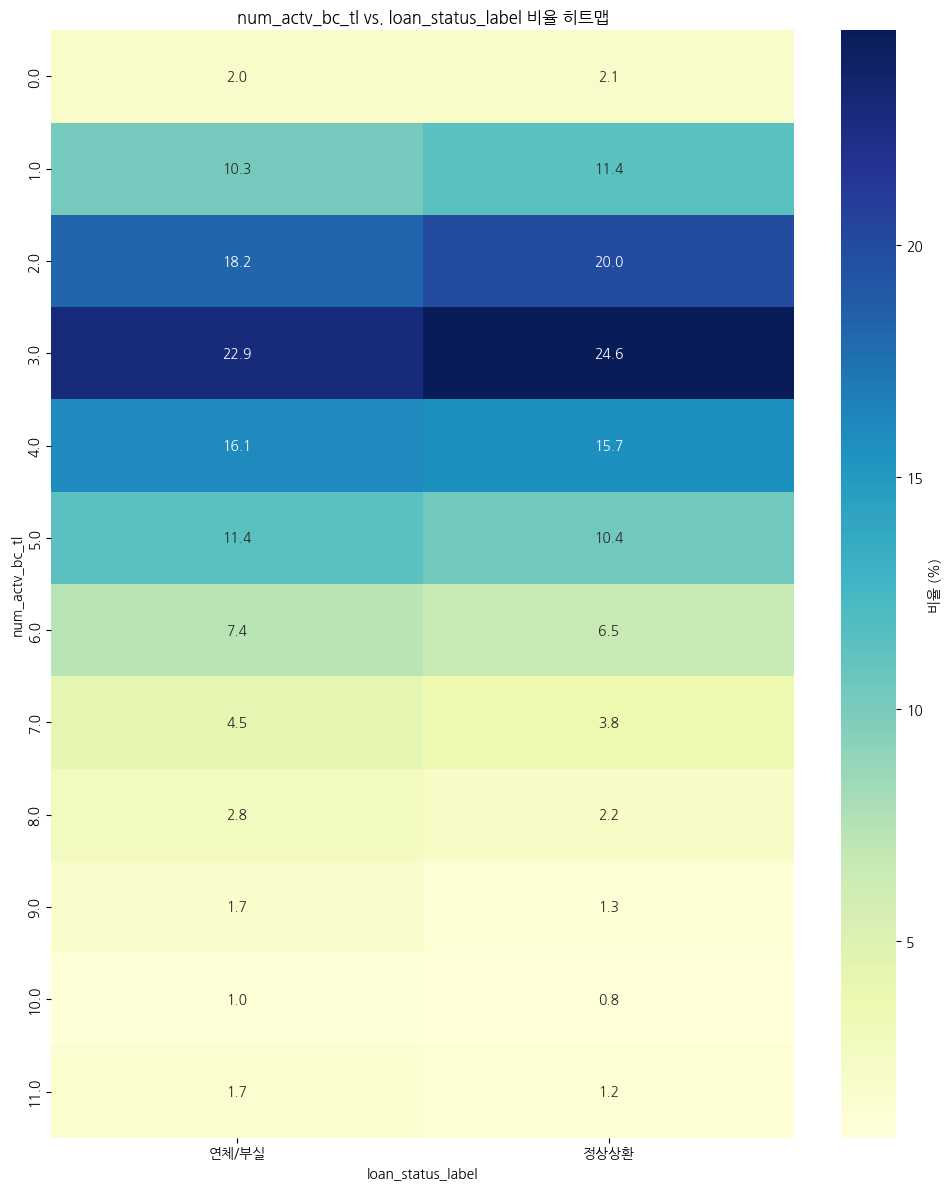

In [1421]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_actv_bc_tl'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_actv_bc_tl vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_actv_bc_tl')
plt.tight_layout()
plt.show()

# num_tl_120dpd_2m

In [1422]:
check(df, 'num_tl_120dpd_2m')

count 992,607.00
mean 0.00  std 0.03
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 6.00

nan_num = 82791
nan_ratio = 7.7 %
unique = [ 0. nan  1.  2.  3.  4.  6.]
unique_num = 6
type = float64


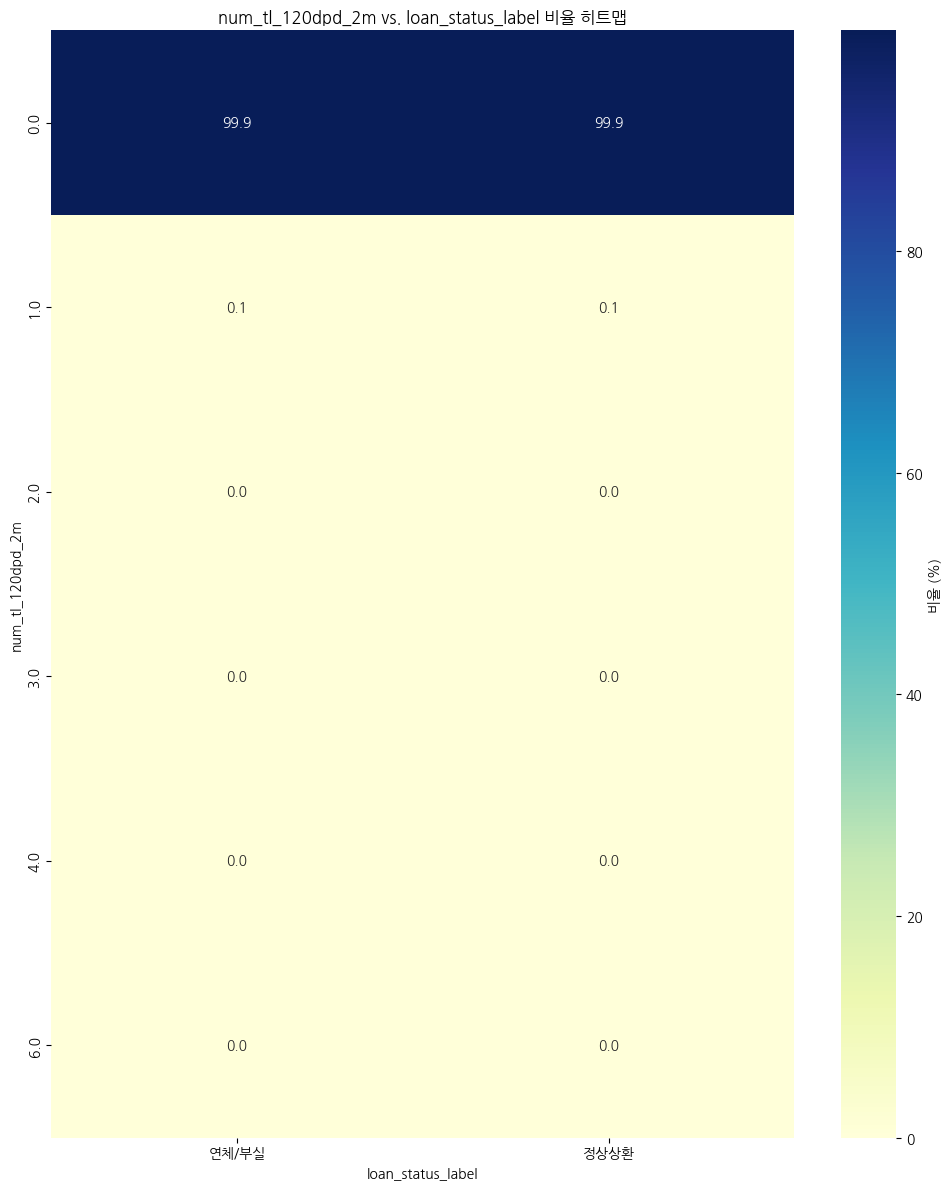

In [1423]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_tl_120dpd_2m'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_tl_120dpd_2m vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_tl_120dpd_2m')
plt.tight_layout()
plt.show()

In [1424]:
df['num_tl_120dpd_2m'] = df['num_tl_120dpd_2m'].fillna(0)

In [1425]:
df['num_tl_120dpd_2m'] = (df['num_tl_120dpd_2m'] > 0).astype(int)

# num_tl_30dpd

In [1426]:
check(df, 'num_tl_30dpd')

count 1,033,382.00
mean 0.00  std 0.06
min 0.00
25% 0.00  50% 0.00  75% 0.00
max 4.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [ 0.  1. nan  2.  3.  4.]
unique_num = 5
type = float64


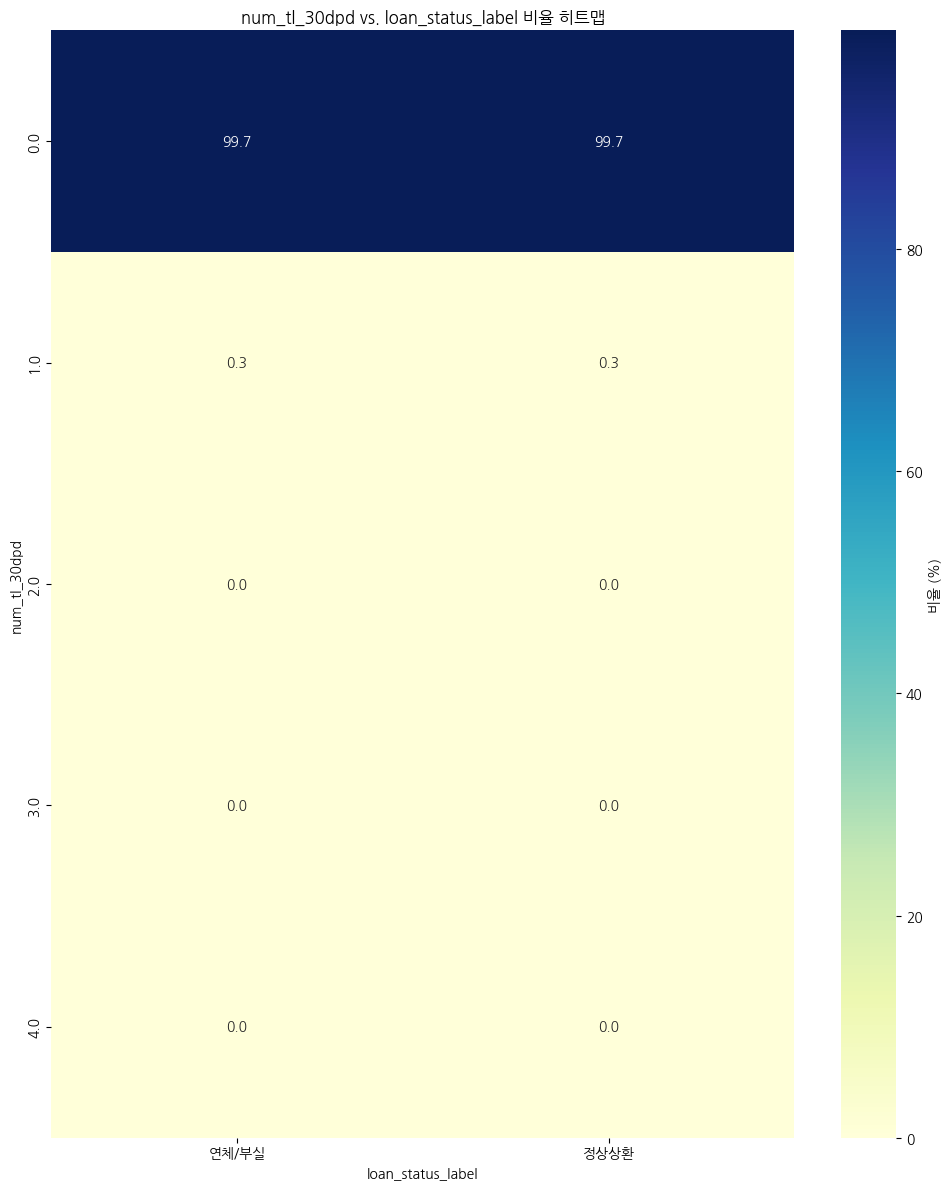

In [1427]:
# 1) num_actv_rev_tl 별 loan_status_label 비율 집계 (열 기준 100%)
pivot_pct = pd.crosstab(
    df['num_tl_30dpd'],
    df['loan_status_label'],
    normalize='columns'
) * 100

# 2) y축(활성 리볼빙 계좌 수) 오름차순 정렬
pivot_pct = pivot_pct.sort_index()

# 3) 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(
    pivot_pct,
    cmap='YlGnBu',
    annot=True,
    fmt='.1f',
    cbar_kws={'label': '비율 (%)'}
)
plt.title('num_tl_30dpd vs. loan_status_label 비율 히트맵')
plt.xlabel('loan_status_label')
plt.ylabel('num_tl_30dpd')
plt.tight_layout()
plt.show()

In [1428]:
df['num_tl_30dpd'] = df['num_tl_30dpd'].fillna(0)

In [1429]:
df['num_tl_30dpd'] = (df['num_tl_30dpd'] > 0).astype(int)

# total_rev_hi_lim

In [1430]:
check(df, 'total_rev_hi_lim')

count 1,033,382.00
mean 33720.92  std 35281.87
min 0.00
25% 14400.00  50% 24800.00  75% 41900.00
max 9999999.00

nan_num = 42016
nan_ratio = 3.91 %
unique = [30255. 70100. 13800. ... 68966. 14459. 14955.]
unique_num = 21641
type = float64


In [1431]:
# total_bal_ex_mort 컬럼의 중앙값 계산
median_val = df['total_rev_hi_lim'].median()

# 결측값(NaN)을 중앙값으로 대체
df['total_rev_hi_lim'] = df['total_rev_hi_lim'].fillna(median_val)

<Axes: xlabel='loan_status_label', ylabel='total_rev_hi_lim'>

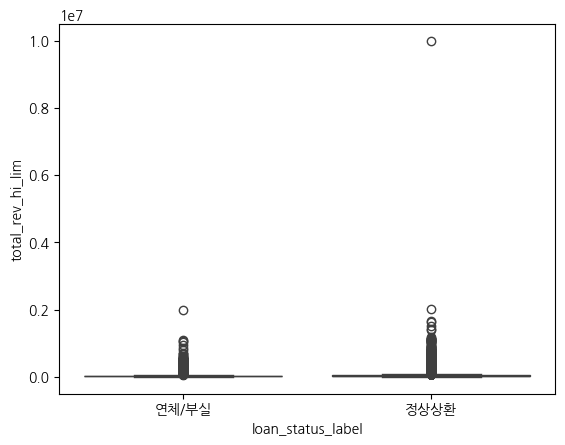

In [1432]:
sns.boxplot(df, x='loan_status_label', y='total_rev_hi_lim')

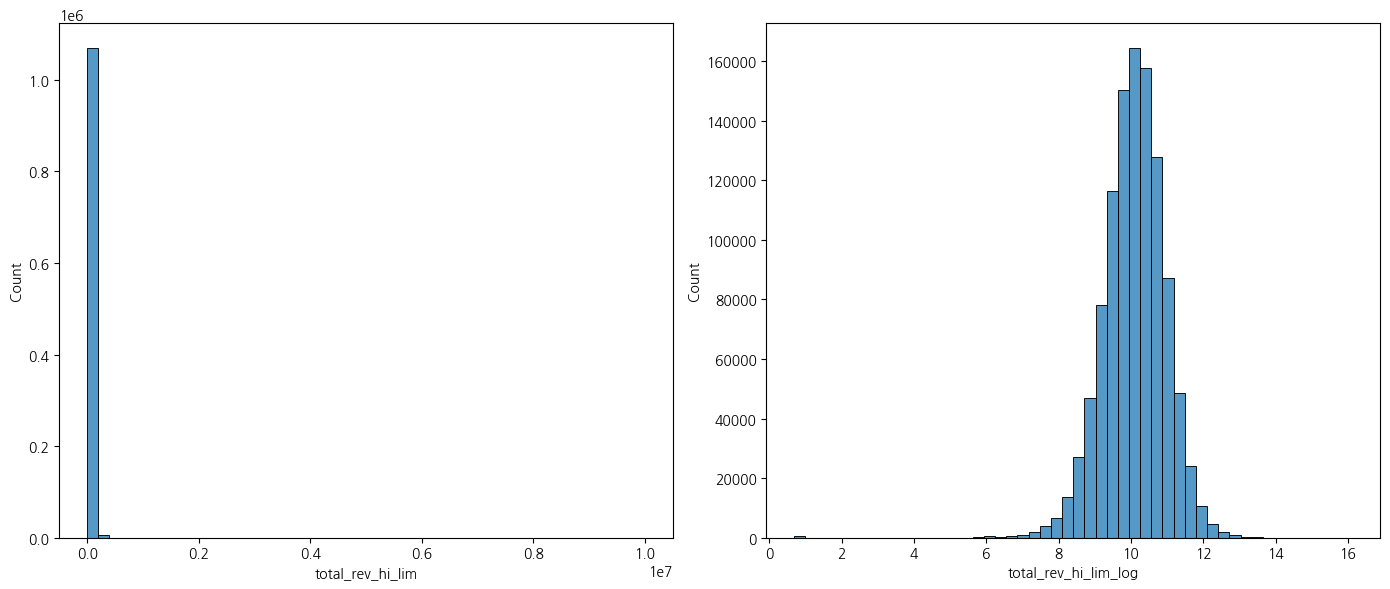

In [1433]:
temp = raw_df.copy()
temp['total_rev_hi_lim_log'] = np.log1p(1 + temp['total_rev_hi_lim'])  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 원래 annual_inc 분포
sns.histplot(temp['total_rev_hi_lim'], bins=50, ax=axes[0])

# 로그 변환 후 분포
sns.histplot(temp['total_rev_hi_lim_log'], bins=50, ax=axes[1])

plt.tight_layout()
plt.show()

In [1434]:
df['total_rev_hi_lim'] = np.log1p(1 + df['total_rev_hi_lim']) 

---

In [1435]:
# 각 컬럼별 결측치 비율 계산
missing_ratio = df.isnull().mean() * 100

# 비율이 높은 순서대로 정렬해서 출력
missing_ratio = missing_ratio.sort_values(ascending=False)

print("컬럼별 결측치 비율 (%)")
print(missing_ratio)

컬럼별 결측치 비율 (%)
total_bc_limit            2.782505
acc_now_delinq            0.000000
purpose                   0.000000
tot_hi_cred_lim           0.000000
tot_coll_amt              0.000000
                            ...   
mths_since_last_delinq    0.000000
mort_acc                  0.000000
mo_sin_rcnt_tl            0.000000
mo_sin_rcnt_rev_tl_op     0.000000
have_rev                  0.000000
Length: 78, dtype: float64


In [1439]:
df = df.drop('total_bc_limit', axis=1)

In [1440]:
df.to_csv('./data/preprocess_all_v1.csv', index=False)

In [1441]:
with open('./data/categorical_cols_v1.txt', 'w', encoding='utf-8') as f:
    for item in categorical_cols:
        f.write(f"{item}\n")

In [ ]:
# txt 가져올 때, 사용하는 코드
with open('./data/categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    loaded_list = [line.strip() for line in f]
print(loaded_list)

['addr_state', 'inq_last_6mths', 'emp_length', 'home_ownership', 'purpose', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'verification_status']


In [1443]:
selected_cols = set(df.columns) - set(cols)

In [1445]:
with open('./data/selected_cols_v1.txt', 'w', encoding='utf-8') as f:
    for item in selected_cols:
        f.write(f"{item}\n")

In [ ]:
cols # selected_cols 가 아닌데 df에 있는 컬럼들

['grade',
 'installment',
 'int_rate',
 'issue_d',
 'loan_amnt',
 'loan_status_label',
 'sub_grade',
 'total_pymnt',
 'loan_status']

# 국채 금리 데이터 merge

In [1496]:
treasury_3yr = pd.read_csv('./data/treasury_3yr.csv')
treasury_5yr = pd.read_csv('./data/treasury_5yr.csv')

In [1498]:
for df_tr in (treasury_3yr, treasury_5yr):
    df_tr['year_month'] = pd.to_datetime(df_tr['year_month'], format='%Y-%m')\
                             .dt.to_period('M')

In [1499]:
df['year_month']   = df['issue_d'].dt.to_period('M')

In [1501]:
df = (
    df
    .merge(treasury_3yr, on='year_month', how='left')
    .merge(treasury_5yr, on='year_month', how='left')
)

df['treasury'] = np.where(
    df['term'] == 1, df['treasury_rate_3yr'],
    np.where(df['term'] == 0, df['treasury_rate_5yr'], np.nan)
)

# 6) 불필요 컬럼(drop) 및 확인
df = df.drop(columns=['treasury_rate_3yr', 'treasury_rate_5yr', 'year_month'])
print(df[['issue_d','term','treasury']].head())

     issue_d  term  treasury
0 2016-07-01     0  1.071500
1 2017-10-01     1  1.682857
2 2017-05-01     1  1.483636
3 2015-09-01     1  1.013333
4 2019-05-01     0  2.187727


<Axes: ylabel='treasury'>

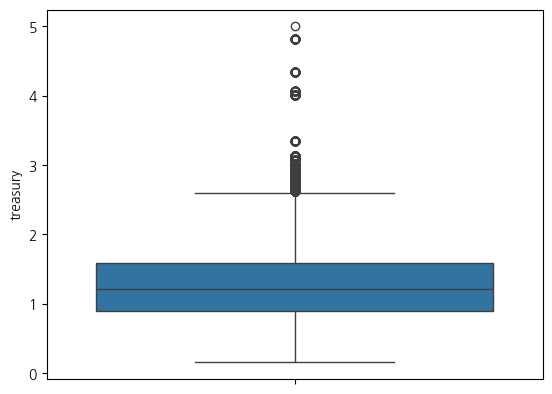

In [1503]:
sns.boxplot(df, y='treasury')

In [1506]:
df[df['treasury'] > 4.5][['issue_d']]

issue_d
321     2007-07-01
3984    2007-07-01
36306   2007-07-01
82006   2007-07-01
87804   2007-07-01
98022   2007-07-01
108707  2007-07-01
117607  2007-07-01
146756  2007-07-01
153597  2007-07-01
168263  2007-07-01
251786  2007-07-01
286516  2007-07-01
311666  2007-07-01
312783  2007-07-01
321160  2007-07-01
331295  2007-07-01
358826  2007-07-01
364121  2007-07-01
365989  2007-07-01
400581  2007-07-01
484595  2007-07-01
505531  2007-07-01
512850  2007-07-01
533007  2007-06-01
534316  2007-07-01
535751  2007-07-01
558136  2007-07-01
584573  2007-07-01
616566  2007-07-01
632014  2007-07-01
633934  2007-07-01
680288  2007-07-01
703786  2007-07-01
734955  2007-07-01
800713  2007-07-01
803846  2007-07-01
828847  2007-07-01
844190  2007-07-01
852376  2007-07-01
894076  2007-07-01
1010151 2007-07-01

In [1510]:
df.to_csv('./data/preprocess_all_v1.csv', index=False)